### Packages

In [1]:
# import cupy as cp
import torch
import hcp_utils as hcp # https://rmldj.github.io/hcp-utils/
from statsmodels.stats.multitest import multipletests
import matlab.engine
import os
import json
import psutil
import random
import numpy as np
import pandas as pd
import re
import psutil
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.linalg import eigh, svd
from scipy.stats import norm
from sklearn.decomposition import FastICA, PCA
from sklearn.covariance import LedoitWolf
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from nilearn import image as nimg
from nilearn import plotting
import nibabel as nib
from pyriemann.estimation import Covariances
from pyriemann.utils.mean import mean_covariance
from pyriemann.utils.tangentspace import tangent_space, untangent_space, log_map_riemann, unupper
from pyriemann.utils.distance import distance_riemann, distance
from pyriemann.utils.base import logm, expm
from concurrent.futures import ProcessPoolExecutor, TimeoutError
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


### Options

In [2]:
# Define your settings
settings = {
    "phenotype": "PicVocab_AgeAdj_PMAT24_A_CR",
    "percentile": 0.2,
    "outputfolder": "PicVocab_AgeAdj_PMAT24_A_CR_TangentSVM_logeuclid",
    "n_folds": 5,
    "TanSVM_C": 1,
    "random_state": 42,
    "n_filters_per_group": 1,
    "Tangent_Class": True,
    "metric": "logeuclid"
}

# Ensure the output folder exists
outputfolder = settings["outputfolder"]
if not os.path.exists(outputfolder):
    os.makedirs(outputfolder)

# Define the path for the settings file
settings_filepath = os.path.join(outputfolder, "settings.json")

# Save the settings to a JSON file
with open(settings_filepath, "w") as f:
    json.dump(settings, f, indent=4)

print(f"Settings have been saved to {settings_filepath}")
# Define the output folder
phenotype = settings["phenotype"]
percentile = settings["percentile"]
n_folds = settings["n_folds"]
TanSVM_C = settings["TanSVM_C"]
random_state = settings["random_state"]
n_filters_per_group = settings["n_filters_per_group"]
Tangent_Class = settings["Tangent_Class"]
# Pyriemannian Mean https://github.com/pyRiemann/pyRiemann/blob/master/pyriemann/utils/mean.py#L633 Metric for mean estimation, can be: "ale", "alm", "euclid", "harmonic", "identity", "kullback_sym", "logdet", "logeuclid", "riemann", "wasserstein", or a callable function.
# https://link.springer.com/article/10.1007/s12021-020-09473-9 <---- best descriptions/plots
# Geometric means in a novel vector space structure on symmetric positive-definite matrices <https://epubs.siam.org/doi/abs/10.1137/050637996?journalCode=sjmael>`_
metric = settings["metric"]

def load_array_from_outputfolder(filename):
    filepath = os.path.join(outputfolder, filename)
    return np.load(filepath)
# Function to save an array to the output folder
def save_array_to_outputfolder(filename, array):
    filepath = os.path.join(outputfolder, filename)
    np.save(filepath, array)

def save_text_results(text, filename="results.txt"):
    """Save text results to a file."""
    filepath = os.path.join(outputfolder, filename)
    with open(filepath, "a") as f:  # Using 'a' to append results to the file
        f.write(text + "\n")

Settings have been saved to PicVocab_AgeAdj_PMAT24_A_CR_TangentSVM_logeuclid/settings.json


### Memory and Processor Usage/Limits Checks

In [3]:
# https://www.kernel.org/doc/Documentation/cgroup-v1/memory.txt
#Open terminal for job
# srun --jobid=68974 --overlap --pty /bin/bash 

# #SLURM RAM
!cgget -r memory.limit_in_bytes /slurm/uid_$SLURM_JOB_UID/job_$SLURM_JOB_ID

#SLURM VM
!cgget -r memory.memsw.limit_in_bytes /slurm/uid_$SLURM_JOB_UID/job_$SLURM_JOB_ID

#SLURM USAGE
!cgget -r memory.memsw.usage_in_bytes /slurm/uid_$SLURM_JOB_UID/job_$SLURM_JOB_ID

!echo "SLURM_JOB_ID: $SLURM_JOB_ID"
!echo "SLURM_JOB_NAME: $SLURM_JOB_NAME"
!echo "SLURM_JOB_NODELIST: $SLURM_JOB_NODELIST"
!echo "SLURM_MEM_PER_NODE: $SLURM_MEM_PER_NODE"
!echo "SLURM_CPUS_ON_NODE: $SLURM_CPUS_ON_NODE"
!echo "SLURM_MEM_PER_CPU: $SLURM_MEM_PER_CPU"

!free -h

import resource

# Get the soft and hard limits of virtual memory (address space)
soft, hard = resource.getrlimit(resource.RLIMIT_AS)
print(f"Soft limit: {soft / (1024 ** 3):.2f} GB")
print(f"Hard limit: {hard / (1024 ** 3):.2f} GB")

# Get the soft and hard limits of the data segment (physical memory usage)
soft, hard = resource.getrlimit(resource.RLIMIT_DATA)
print(f"Soft limit: {soft / (1024 ** 3):.2f} GB")
print(f"Hard limit: {hard / (1024 ** 3):.2f} GB")

#TORQUE Virtual Memory
# !cgget -r memory.memsw.limit_in_bytes /torque/$PBS_JOBID

# #TORQUE RAM
# !cgget -r memory.limit_in_bytes /torque/$PBS_JOBID

# #TORQUE USAGE
# !cgget -r memory.memsw.usage_in_bytes /torque/$PBS_JOBID
# print(int(os.environ['PBS_NP']))
!nvidia-smi

def gpu_mem():
    # Memory usage information
    print(f"Total memory available: {(torch.cuda.get_device_properties('cuda').total_memory / 1024**3):.2f} GB")
    print(f"Allocated memory: {torch.cuda.memory_allocated() / 1024**3:.2f} GB")
    print(f"Reserved memory: {torch.cuda.memory_reserved() / 1024**3:.2f} GB")

def cpu_mem():
   # Display memory information
    print(f"Total Memory: { psutil.virtual_memory().total / (1024**3):.2f} GB")
    print(f"Available Memory: { psutil.virtual_memory().available / (1024**3):.2f} GB")
    print(f"Used Memory: { psutil.virtual_memory().used / (1024**3):.2f} GB")
    print(f"Memory Usage: { psutil.virtual_memory().percent}%")

gpu_mem()
cpu_mem()

/slurm/uid_13034/job_46208382:
memory.limit_in_bytes: 268435456000

/slurm/uid_13034/job_46208382:
memory.memsw.limit_in_bytes: 308700774400

/slurm/uid_13034/job_46208382:
memory.memsw.usage_in_bytes: 957063168

SLURM_JOB_ID: 46208382
SLURM_JOB_NAME: run_jupyter_SLURM.sh
SLURM_JOB_NODELIST: dccn-c064
SLURM_MEM_PER_NODE: 256000
SLURM_CPUS_ON_NODE: 1
SLURM_MEM_PER_CPU: 
              total        used        free      shared  buff/cache   available
Mem:          503Gi        22Gi       224Gi       429Mi       256Gi       478Gi
Swap:          19Gi        13Mi        19Gi
Soft limit: -0.00 GB
Hard limit: -0.00 GB
Soft limit: -0.00 GB
Hard limit: -0.00 GB
/bin/bash: nvidia-smi: command not found


RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

### Select Paths, Parcellate, Standardize, and Save

In [4]:
def load(phenotype, percentile, folder1=0):
    """
    Load data for a specified number of subjects and fMRI tasks, only if they have not been parcellated.
    """

    base_directory = "/project_cephfs/3022017.01/S1200"
    subdirectory = "MNINonLinear/Results"
    
    folders = [
        "rfMRI_REST1_LR", "rfMRI_REST1_RL", "rfMRI_REST2_LR", "rfMRI_REST2_RL",
        "tfMRI_EMOTION_LR", "tfMRI_EMOTION_RL", "tfMRI_GAMBLING_LR", "tfMRI_GAMBLING_RL",
        "tfMRI_LANGUAGE_LR", "tfMRI_LANGUAGE_RL", "tfMRI_MOTOR_LR", "tfMRI_MOTOR_RL",
        "tfMRI_RELATIONAL_LR", "tfMRI_RELATIONAL_RL", "tfMRI_SOCIAL_LR", "tfMRI_SOCIAL_RL",
        "tfMRI_WM_LR", "tfMRI_WM_RL"
    ]


    if folder1 + 1 >= len(folders):
        raise IndexError(f"Invalid folder1 index: {folder1}. Check folder list.")

    if folder1 + 2 >= len(folders):
        raise IndexError(f"Invalid folder1 index: {folder1}. Check folder list.")

    if folder1 + 3 >= len(folders):
        raise IndexError(f"Invalid folder1 index: {folder1}. Check folder list.")

    subids = [sub for sub in os.listdir(base_directory) if os.path.isdir(os.path.join(base_directory, sub))]

    file_path_restricted = r'../HCP/RESTRICTED_zainsou_8_6_2024_2_11_21.csv'
    file_path_unrestricted = r'../HCP/unrestricted_zainsou_8_2_2024_6_13_22.csv'

    try:
        # Load the data from CSV files
        data_r = pd.read_csv(file_path_restricted)
        data_ur = pd.read_csv(file_path_unrestricted)
        print("Files loaded successfully.")
    except FileNotFoundError:
        print(f"File not found: {file_path_restricted} or {file_path_unrestricted}")
        raise

    # Combine restricted and unrestricted data on Subject ID
    data = pd.merge(data_r, data_ur, on='Subject', how='outer')

    filtered_data = data[data['Subject'].astype(str).isin(subids)]
    # plt.hist(filtered_data["SSAGA_FTND_Score"], bins=10)
    # plt.show()
    # picvocab_low_threshold = filtered_data["PicVocab_AgeAdj"].quantile(.2)
    # picvocab_high_threshold = filtered_data["PicVocab_AgeAdj"].quantile(0.8)
    low_threshold = filtered_data[phenotype].quantile(percentile)
    high_threshold = filtered_data[phenotype].quantile(1.0 - percentile)

    # pmat24_low_threshold = filtered_data["PMAT24_A_CR"].quantile(.2)
    # pmat24_high_threshold = filtered_data["PMAT24_A_CR"].quantile(.8)

    # psqi_low_threshold = filtered_data["PSQI_Score"].quantile(.7)
    # psqi_high_threshold = filtered_data["PSQI_Score"].quantile(.3)

    # ssaga_educ_low_threshold = filtered_data["SSAGA_Educ"].quantile(.3)
    # ssaga_educ_high_threshold = filtered_data["SSAGA_Educ"].quantile(.7)

    # lifesatisf_low_threshold = filtered_data["LifeSatisf_Unadj"].quantile(.2)
    # lifesatisf_high_threshold = filtered_data["LifeSatisf_Unadj"].quantile(.8)

    # DDisc_low_threshold = filtered_data["DDisc_AUC_200"].quantile(.2)
    # DDisc_high_threshold = filtered_data["DDisc_AUC_200"].quantile(.8)


    # # Handedness_low_threshold = 0
    # Handedness_high_threshold = 0
    # tobacco_low_threshold = 4
    # tobacco_high_threshold = 0
    # # Binary variables - set the thresholds manually
    # fam_hist_threshold_high = 0
    # fam_hist_threshold_low = 1

    # thc_threshold_high = 0
    # thc_threshold_low = 1


    # Filtering Group 1 (high tail) and Group 2 (low tail)
    group_1 = np.array(filtered_data[
        (filtered_data[phenotype] >= high_threshold)
    ]['Subject']).astype(str)

    group_2 = np.array(filtered_data[
        (filtered_data[phenotype] <= low_threshold)
    ]['Subject']).astype(str)

    # Print the number of subjects in each group
    print(f"Group 1 (high tail): {len(group_1)} subjects")
    print(f"Group 2 (low tail): {len(group_2)} subjects")

    group_1_paths = []
    for subject in group_1:
        subject_data1 = os.path.join(base_directory, subject, subdirectory, folders[folder1], folders[folder1] + "_Atlas_MSMAll_hp2000_clean.dtseries.nii")
        subject_data2 = os.path.join(base_directory, subject, subdirectory, folders[folder1 + 1], folders[folder1 + 1] + "_Atlas_MSMAll_hp2000_clean.dtseries.nii")
        subject_data3 = os.path.join(base_directory, subject, subdirectory, folders[folder1 + 2], folders[folder1 + 2] + "_Atlas_MSMAll_hp2000_clean.dtseries.nii")
        subject_data4 = os.path.join(base_directory, subject, subdirectory, folders[folder1 + 3], folders[folder1 + 3] + "_Atlas_MSMAll_hp2000_clean.dtseries.nii")

        if os.path.exists(subject_data1) and os.path.exists(subject_data2) and os.path.exists(subject_data3) and os.path.exists(subject_data4):
            group_1_paths.append((subject_data1, subject_data2,subject_data3,subject_data4))
    
    group_2_paths = []
    for subject in group_2:
        subject_data1 = os.path.join(base_directory, subject, subdirectory, folders[folder1], folders[folder1] + "_Atlas_MSMAll_hp2000_clean.dtseries.nii")
        subject_data2 = os.path.join(base_directory, subject, subdirectory, folders[folder1 + 1], folders[folder1 + 1] + "_Atlas_MSMAll_hp2000_clean.dtseries.nii")
        subject_data3 = os.path.join(base_directory, subject, subdirectory, folders[folder1 + 2], folders[folder1 + 2] + "_Atlas_MSMAll_hp2000_clean.dtseries.nii")
        subject_data4 = os.path.join(base_directory, subject, subdirectory, folders[folder1 + 3], folders[folder1 + 3] + "_Atlas_MSMAll_hp2000_clean.dtseries.nii")

        if os.path.exists(subject_data1) and os.path.exists(subject_data2) and os.path.exists(subject_data3) and os.path.exists(subject_data4):
            group_2_paths.append((subject_data1, subject_data2,subject_data3,subject_data4))

    
    print("Length of Group 1:", len(group_1_paths))
    print("Length of Group 2:", len(group_2_paths))

    # # Determine the minimum length
    # min_length = min(len(group_1_paths), len(group_2_paths))

    # # Randomly sample from the larger group to match the size of the smaller group
    # if len(group_1_paths) > min_length:
    #     group_1_paths = random.sample(group_1_paths, min_length)
    # elif len(group_2_paths) > min_length:
    #     group_2_paths = random.sample(group_2_paths, min_length)

    # Print the new sizes of both groups
    print("New Length of Group 1:", len(group_1_paths))
    print("New Length of Group 2:", len(group_2_paths))
    return group_1_paths,group_2_paths

groupA_paths,groupB_paths = load(phenotype=phenotype,percentile=percentile,folder1=0)

Files loaded successfully.


KeyError: 'PicVocab_AgeAdj_PMAT24_A_CR'

In [ ]:
import traceback

def process_subject(sub):
    try:
        concatenated_data = []
        for task in sub:
            X = nib.load(task).get_fdata(dtype=np.float32)
            Xn = hcp.normalize(X-X.mean(axis=1, keepdims=True))
            concatenated_data.append(Xn)
            del X, Xn

        # Concatenate data along the first axis
        subject = np.concatenate(concatenated_data, axis=0)
        del concatenated_data  # Explicitly delete the concatenated data list

        Xp = hcp.parcellate(hcp.normalize(subject - subject.mean(axis=1,keepdims=True)), hcp.mmp)
        Xp = hcp.normalize(Xp - Xp.mean(axis=1,keepdims=True))
        del subject  # Explicitly delete the subject array

        return Xp

    except Exception as e:
        print(f"Error processing subject: {e}")
        traceback.print_exc()  # Print the full traceback
        return None


def parcellate(group):
    try:
        with ProcessPoolExecutor(max_workers=(int(os.cpu_count()*.3))) as executor:
            # Use map to process subjects in parallel
            group_parcellated = list(executor.map(process_subject, group))
        
        # Filter out any None results to continue with successful parcellations
        group_parcellated = [result for result in group_parcellated if result is not None]
        return group_parcellated
    
    except Exception as e:
        print(f"Error in parcellation process: {e}")
        traceback.print_exc()
        return []

# Example usage
try:
    cpu_mem()  # Monitor CPU and memory usage before the operation
    groupA_parcellated = parcellate(groupA_paths)
    cpu_mem()  # Monitor CPU and memory usage after processing group A
    groupB_parcellated = parcellate(groupB_paths)
    cpu_mem()  # Monitor CPU and memory usage after processing group B

except Exception as e:
    print(f"An error occurred during the outer loop: {e}")
    traceback.print_exc()

target_shape = (4800, 379)
# Initialize lists to collect indices of mismatched arrays
mismatched_indices_A = []
mismatched_indices_B = []

# Create the array for group A, collecting indices of mismatches
groupA_parcellated_array = np.array([
    array for index, array in enumerate(groupA_parcellated) 
    if array.shape == target_shape or mismatched_indices_A.append(index)
])

# Create the array for group B, collecting indices of mismatches
groupB_parcellated_array = np.array([
    array for index, array in enumerate(groupB_parcellated) 
    if array.shape == target_shape or mismatched_indices_B.append(index)
])
# Print the indices of arrays that did not match the target shape
print("Mismatched indices in group A:", mismatched_indices_A)
print("Mismatched indices in group B:", mismatched_indices_B)
groupA_paths_filtered = np.array([path for i, path in enumerate(groupA_paths) if i not in mismatched_indices_A])
groupB_paths_filtered = np.array([path for i, path in enumerate(groupB_paths) if i not in mismatched_indices_B])
print(len(groupA_parcellated_array))
print(len(groupB_parcellated_array))
# Save the arrays in the specified output folder
# Example usage to save the arrays
save_array_to_outputfolder("groupA_parcellated_array.npy", groupA_parcellated_array)
save_array_to_outputfolder("groupB_parcellated_array.npy", groupB_parcellated_array)
save_array_to_outputfolder("groupA_paths_filtered.npy", groupA_paths_filtered)
save_array_to_outputfolder("groupB_paths_filtered.npy", groupB_paths_filtered)

### Load Paths & Parcellated

In [8]:
groupA_parcellated_array = load_array_from_outputfolder("groupA_parcellated_array.npy")
groupB_parcellated_array = load_array_from_outputfolder("groupB_parcellated_array.npy")
groupA_paths_filtered = load_array_from_outputfolder("groupA_paths_filtered.npy")
groupB_paths_filtered = load_array_from_outputfolder("groupB_paths_filtered.npy")

In [ ]:
print(groupA_parcellated_array.shape)
print(groupB_parcellated_array.shape)
total_subjects = groupA_parcellated_array.shape[0] + groupB_parcellated_array.shape[0]

save_text_results(f"Group A: {groupA_parcellated_array.shape}")
save_text_results(f"Group B: {groupB_parcellated_array.shape}")
save_text_results(f"Total subjects: {total_subjects}")


### Test Linear Seperability of Groups Full Parcellated Tangent Covs

In [5]:
def extract_sample_weights(train_subject_ids, y_train):
    """
    Compute sample weights based on normalized phenotype scores for the training data,
    ensuring equal total contribution from both groups.
    """
    file_path_restricted = '../HCP/RESTRICTED_zainsou_8_6_2024_2_11_21.csv'
    file_path_unrestricted = '../HCP/unrestricted_zainsou_8_2_2024_6_13_22.csv'

    try:
        data_r = pd.read_csv(file_path_restricted)
        data_ur = pd.read_csv(file_path_unrestricted)
    except FileNotFoundError:
        print(f"File not found: {file_path_restricted} or {file_path_unrestricted}")
        raise

    # Combine restricted and unrestricted data on Subject ID
    data = pd.merge(data_r, data_ur, on='Subject', how='outer')

    # Convert Subject IDs to string for consistency
    data['Subject'] = data['Subject'].astype(str)
    train_subject_ids = train_subject_ids.astype(str)

    # Filter data for training subjects
    train_data = data[data['Subject'].isin(train_subject_ids)]

    # Ensure the order matches the training data
    train_data = train_data.set_index('Subject').loc[train_subject_ids].reset_index()

    # Extract individual phenotype scores
    # pic_vocab_scores = train_data['PicVocab_AgeAdj']
    # pmat24_scores = train_data['PMAT24_A_CR']

    # Normalize each phenotype score individually between 0 and 1
    # pic_vocab_min = pic_vocab_scores.min()
    # pic_vocab_max = pic_vocab_scores.max()
    # pic_vocab_norm = (pic_vocab_scores - pic_vocab_min) / (pic_vocab_max - pic_vocab_min)

    # pmat24_min = pmat24_scores.min()
    # pmat24_max = pmat24_scores.max()
    # pmat24_norm = (pmat24_scores - pmat24_min) / (pmat24_max - pmat24_min)
    # phenotype_scores = (pic_vocab_norm + pmat24_norm) / 2
    
    pheno_score = train_data['CogCrystalComp_Unadj']
    pheno_min = pheno_score.min()
    pheno_max = pheno_score.max()
    pheno_norm = (pheno_score - pheno_min) / (pheno_max - pheno_min)
    phenotype_scores = pheno_norm



    # Initialize sample weights array
    sample_weights = np.zeros(len(y_train))

    # Assign weights based on group labels
    for idx, label in enumerate(y_train):
        if label == 1:
            # For Group 1: Higher scores ⇒ Higher weights
            sample_weights[idx] = phenotype_scores.iloc[idx]
        else:
            # For Group 2: Higher scores ⇒ Lower weights
            sample_weights[idx] = 1 - phenotype_scores.iloc[idx]

    # Optional: Raise weights to a power to accentuate differences (if desired)
    # sample_weights = sample_weights ** exponent  # Adjust the exponent as needed

    # Ensure total weights for each group are equal
    group1_indices = np.where(y_train == 1)[0]
    group2_indices = np.where(y_train == 0)[0]

    sum_group1_weights = np.sum(sample_weights[group1_indices])
    sum_group2_weights = np.sum(sample_weights[group2_indices])

    # Compute the scaling factor for each group
    total_weight = (sum_group1_weights + sum_group2_weights) / 2
    scale_group1 = total_weight / sum_group1_weights if sum_group1_weights != 0 else 1
    scale_group2 = total_weight / sum_group2_weights if sum_group2_weights != 0 else 1

    # Apply scaling factors to ensure equal total weight per group
    sample_weights[group1_indices] *= scale_group1
    sample_weights[group2_indices] *= scale_group2

    # Plotting to visualize the sample weights
    plt.figure(figsize=(10, 6))
    plt.scatter(phenotype_scores, sample_weights, c=y_train, cmap='coolwarm', alpha=0.7)
    plt.xlabel('Normalized Combined Phenotype Score')
    plt.ylabel('Sample Weight')
    plt.title('Sample Weights After Scaling')
    plt.colorbar(label='Group Label')
    plt.show()

    return sample_weights

    
def tangent_transform(group1_train_cov, group1_test_cov, group2_train_cov, group2_test_cov, metric):        
    # Compute the Fréchet mean using only the training data from both groups
    Frechet_Mean = mean_covariance(
        np.concatenate((group1_train_cov, group2_train_cov)), 
        metric=metric
    )
    # Perform tangent space projection
    train_1 = tangent_space(group1_train_cov, Frechet_Mean, metric=metric)
    train_2 = tangent_space(group2_train_cov, Frechet_Mean, metric=metric)
    test_1 = tangent_space(group1_test_cov, Frechet_Mean, metric=metric)
    test_2 = tangent_space(group2_test_cov, Frechet_Mean, metric=metric)

    return train_1, train_2, test_1, test_2

def test_classifiers(train_1, test_1, train_2, test_2, sample_weights_train=None):
    # Dictionary with keys for each classifier
    clf_dict = {
        "SVM (C=1)": SVC(kernel='linear', C=1, class_weight='balanced'),
        "SVM (C=0.1)": SVC(kernel='linear', C=0.1, class_weight='balanced'),
        "SVM (C=0.01)": SVC(kernel='linear', C=0.01, class_weight='balanced'),
        "L2 SVM (C=1)": LinearSVC(penalty='l2',loss='squared_hinge',C=1,class_weight='balanced'),
        "L2 SVM (C=0.1)": LinearSVC(penalty='l2',loss='squared_hinge',C=.1,class_weight='balanced'),
        "L2 SVM (C=0.01)":  LinearSVC(penalty='l2',loss='squared_hinge',C=.01,class_weight='balanced'),
        "L2 SVM Hinge (C=1)": LinearSVC(penalty='l2',loss='hinge',C=1,class_weight='balanced'),
        "L2 SVM Hinge (C=0.1)": LinearSVC(penalty='l2',loss='hinge',C=.1,class_weight='balanced'),
        "L2 SVM Hinge (C=0.01)":  LinearSVC(penalty='l2',loss='hinge',C=.01,class_weight='balanced'),
        "L1 SVM (C=1)": LinearSVC(penalty='l1',loss='squared_hinge',dual=False,C=1,class_weight='balanced'),
        # "L1 SVM (C=0.1)": LinearSVC(penalty='l1',loss='squared_hinge',dual=False,C=.1,class_weight='balanced'),
        # "L1 SVM (C=0.01)":  LinearSVC(penalty='l1',loss='squared_hinge',dual=False,C=.01,class_weight='balanced'),
        "LDA": LDA(),
        "Logistic Regression (default)": LogisticRegression(),
        "Logistic Regression (l2)": LogisticRegression(penalty='l2', class_weight='balanced'),
        "Logistic Regression (l1)": LogisticRegression(penalty='l1', solver='liblinear', class_weight='balanced'),
    #     "Logistic Regression (elasticnet)": LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.2, class_weight='balanced')
    }

     # Combine training data and labels
    X_train = np.concatenate((train_1, train_2))
    y_train = np.concatenate((np.ones(len(train_1)), np.zeros(len(train_2))))

    # Combine test data and labels
    X_test = np.concatenate((test_1, test_2))
    y_test = np.concatenate((np.ones(len(test_1)), np.zeros(len(test_2))))

    # Ensure sample_weights_train aligns with X_train and y_train
    if sample_weights_train is not None:
        assert len(sample_weights_train) == len(y_train), "Sample weights length mismatch."


    # Calculate the distance between the two class means
    # mean_group1_train = np.mean(group1_test, axis=0)
    # mean_group2_train = np.mean(group2_test, axis=0)
    # distance_vars = np.linalg.norm(mean_group1_train - mean_group2_train)

    # Initialize a dictionary to store the metrics
    metrics_dict = {}
    
    # Iterate through each classifier and calculate accuracy
    for key, clf in clf_dict.items():
        clf.fit(X_train, y_train)
        # clf.fit(X_train, y_train, sample_weight=sample_weights_train)

        predictions = clf.predict(X_test)
        accuracy = accuracy_score(y_test, predictions)
        correct_predictions = np.sum(predictions == y_test)
        total_predictions = len(y_test)
        # Confusion matrix to get per-class accuracy
        cm = confusion_matrix(y_test, predictions, labels=[1, 0])
        per_class_correct = np.diag(cm)
        per_class_total = np.sum(cm, axis=1)
        per_class_accuracy = per_class_correct / per_class_total

        metrics_dict[key] = {
            'accuracy': accuracy,
            'correct_predictions': correct_predictions,
            'total_predictions': total_predictions,
            'per_class_correct': per_class_correct,
            'per_class_total': per_class_total,
            'per_class_accuracy': per_class_accuracy
        }
    # if test_data.shape[1] == 2:
    #     # Plot when n=1
    #     plt.figure(figsize=(8, 6))
    #     plt.scatter(group1_test[:, 0], group1_test[:, 1], label='Group 1 Log Variance (Test)', color='blue')
    #     plt.scatter(group2_test[:, 0], group2_test[:, 1], label='Group 2 Log Variance (Test)', color='red')

    #     # Plot the line connecting the two means
    #     plt.plot([mean_group1_train[0], mean_group2_train[0]], [mean_group1_train[1], mean_group2_train[1]], 'k--', label=f'Mean Distance: {distance_vars:.2f}')

    #     # Decision boundary
    #     x_values = np.array([data[:, 0].min(), data[:, 0].max()])
    #     y_values = -(max_clf.intercept_ + max_clf.coef_[0][0] * x_values) / max_clf.coef_[0][1]
    #     plt.plot(x_values, y_values, 'g-', label='Decision Boundary')

    #     # Display plot
    #     plt.xlabel('Log Variance Feature 1')
    #     plt.ylabel('Log Variance Feature 2')
    #     plt.title(f'Log Variance Comparison and {max_key} Decision Boundary')

    #     # Display classification accuracy on the plot
    #     plt.text(0.05, 0.95, f'Accuracy: {accuracy:.2f}', transform=plt.gca().transAxes, fontsize=12,
    #     verticalalignment='top', bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='lightgrey'))

    #     plt.legend()
    #     plt.grid(True)
    #     plt.show()
    return metrics_dict

    
def test_linear_sep(groupA_parcellated_array, groupB_parcellated_array,groupA_paths, groupB_paths,metric='riemann',n_splits=10):
    cov_est = Covariances(estimator='lwf')
    groupA_parcellated_covs = cov_est.transform(np.transpose(groupA_parcellated_array, (0, 2, 1)))
    groupB_parcellated_covs = cov_est.transform(np.transpose(groupB_parcellated_array, (0, 2, 1)))

    data = np.concatenate((groupA_parcellated_covs, groupB_parcellated_covs))
    labels = np.concatenate((np.ones(len(groupA_parcellated_covs)), np.zeros(len(groupB_parcellated_covs))))

    all_paths = np.concatenate((groupA_paths, groupB_paths))
    subject_ids = np.array([re.search(r'/(\d+)/', path[0]).group(1) for path in all_paths])

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    metrics_dict = {}

    for fold, (train_index, test_index) in enumerate(skf.split(data, labels)):
        print(f"\nProcessing Fold {fold + 1}/{n_splits}")
        data_train, data_test = data[train_index], data[test_index]
        labels_train, labels_test = labels[train_index], labels[test_index]

        group1_train_cov = data_train[labels_train == 1]
        group2_train_cov = data_train[labels_train == 0]
        group1_test_cov = data_test[labels_test == 1]
        group2_test_cov = data_test[labels_test == 0]

        # train_subject_ids = subject_ids[train_index]
        # # Compute sample weights for the training data
        # sample_weights_train = extract_sample_weights(train_subject_ids, labels_train)

        # Perform tangent space transformation
        train_1, train_2, test_1, test_2 = tangent_transform(
            group1_train_cov, group1_test_cov,
            group2_train_cov, group2_test_cov,
            metric=metric 
        )

        fold_metrics = test_classifiers(train_1, test_1, train_2, test_2, sample_weights_train=None)

        # Initialize metrics_dict keys on first fold
        if fold == 0:
            for clf_name in fold_metrics.keys():
                metrics_dict[clf_name] = {
                    'correct_predictions': 0,
                    'total_predictions': 0,
                    'accuracies': [],
                    'per_class_correct': np.array([0, 0]),
                    'per_class_total': np.array([0, 0])
                }

        # Aggregate metrics
        for clf_name, metrics in fold_metrics.items():
            # Update total correct predictions and total samples
            metrics_dict[clf_name]['correct_predictions'] += metrics['correct_predictions']
            metrics_dict[clf_name]['total_predictions'] += metrics['total_predictions']
            # Store accuracies for mean and std calculation
            metrics_dict[clf_name]['accuracies'].append(metrics['accuracy'])
            # Update per-class correct and total counts
            metrics_dict[clf_name]['per_class_correct'] += metrics['per_class_correct']
            metrics_dict[clf_name]['per_class_total'] += metrics['per_class_total']

            # Print per-fold metrics
            print(f"Classifier: {clf_name}")
            print(f"  Fold Accuracy: {metrics['accuracy'] * 100:.2f}%")
            print(f"  Correct Predictions: {metrics['correct_predictions']}/{metrics['total_predictions']}")
            print(f"  Per-Class Accuracy: {metrics['per_class_accuracy'] * 100}")

    # After all folds, compute overall metrics
    print("\nOverall Metrics Across All Folds:")
    for clf_name, clf_metrics in metrics_dict.items():
        overall_accuracy = clf_metrics['correct_predictions'] / clf_metrics['total_predictions']
        mean_accuracy = np.mean(clf_metrics['accuracies'])
        std_accuracy = np.std(clf_metrics['accuracies'])
        per_class_accuracy = clf_metrics['per_class_correct'] / clf_metrics['per_class_total']

        print(f"\nClassifier: {clf_name}")
        print(f"  Total Accuracy: {overall_accuracy * 100:.2f}%")
        print(f"  Average Fold Accuracy: {mean_accuracy * 100:.2f}%")
        print(f"  Fold Accuracy Std Dev: {std_accuracy * 100:.2f}%")
        print(f"  Per-Class Accuracy: {per_class_accuracy * 100}")

    return metrics_dict

In [ ]:
full_cov_cross_val = test_linear_sep(groupA_parcellated_array, groupB_parcellated_array,groupA_paths_filtered, groupB_paths_filtered, metric=metric,n_splits=10)
save_text_results(f"Tangent Space Classification Accuracy Results: {full_cov_cross_val}")

### FKT Functions and Cross Validate Filters

In [6]:
# def tangent_LDA(group1_covs=None, group2_covs=None, Frechet_Mean=None,tangent_projected_1=None, tangent_projected_2=None, tangent_calc=True, metric="riemann",k=1, visualize=False):
#     if tangent_calc:
#         all_covs = np.concatenate((group1_covs, group2_covs))
#         Frechet_Mean = mean_covariance(all_covs, metric=metric)
#         tangent_projected_1 = tangent_space(group1_covs, Frechet_Mean, metric=metric)
#         tangent_projected_2 = tangent_space(group2_covs, Frechet_Mean, metric=metric)
        

#     # Initialize the Covariances estimator
#     cov_estimator = Covariances(estimator='lwf')
#     tangent_projected_mean = np.mean(np.concatenate((tangent_projected_1, tangent_projected_2)),axis=0,keepdims=True)  
    
#     tangent_1_mean = np.mean(tangent_projected_1,axis=0,keepdims=True) - tangent_projected_mean
#     tangent_2_mean = np.mean(tangent_projected_2,axis=0,keepdims=True) - tangent_projected_mean
#     tangent_between_scatter = tangent_1_mean.T@tangent_1_mean + tangent_2_mean.T@tangent_2_mean
    
#     # Estimate the covariance matrices
#     cov_tangent_projected_1 = cov_estimator.transform(np.transpose(tangent_projected_1[np.newaxis,:,:],(0,2,1)))[0]
#     cov_tangent_projected_2 = cov_estimator.transform(np.transpose(tangent_projected_2[np.newaxis,:,:],(0,2,1)))[0]
    

#     # Convert to PyTorch tensors and move to GPU
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     print(("cuda" if torch.cuda.is_available() else "cpu"))
#     gpu_mem()
#     sum = torch.tensor(cov_tangent_projected_1, dtype=torch.float32, device="cuda") + torch.tensor(cov_tangent_projected_2, dtype=torch.float32, device="cuda")
#     gpu_mem()
#     # cov_tangent_projected_1 = torch.tensor(cov_tangent_projected_1, dtype=torch.float32, device=device)
#     # gpu_mem()
#     # cov_tangent_projected_2 = torch.tensor(cov_tangent_projected_2, dtype=torch.float32, device=device) 
#     # gpu_mem()
#     gpu_mem()

#     tangent_between_scatter = torch.tensor(tangent_between_scatter, dtype=torch.float32, device=device)
#     gpu_mem()
    
#     # For filtersA
#     _, eigvecs = torch.lobpcg(tangent_between_scatter, B=sum, k=k, largest=True)
#     del sum, tangent_between_scatter
#     torch.cuda.empty_cache()
#     gpu_mem()
#     eigvecs_array = eigvecs.clone().cpu().numpy()
#     filters = untangent_space(eigvecs_array.T, Frechet_Mean)
#     fkt_riem_eigs, filters, filtersA, filtersB = FKT(filters[0,:,:], Frechet_Mean, mean=metric, average=False, visualize=visualize)

#     return fkt_riem_eigs, filters, filtersA, filtersB

def tangent_CSP(group1_covs=None, group2_covs=None, Frechet_Mean=None,tangent_projected_1=None, tangent_projected_2=None, tangent_calc=True, metric="riemann",k=1, visualize=False):
    if tangent_calc:
        all_covs = np.concatenate((group1_covs, group2_covs))
        Frechet_Mean = mean_covariance(all_covs, metric=metric)
        tangent_projected_1 = tangent_space(group1_covs, Frechet_Mean, metric=metric)
        tangent_projected_2 = tangent_space(group2_covs, Frechet_Mean, metric=metric)
        
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(("cuda" if torch.cuda.is_available() else "cpu"))

    tangent_projected_1_gpu = torch.tensor(tangent_projected_1, dtype=torch.float32, device=device)
    cov_tangent_projected_1 = (tangent_projected_1_gpu.T@tangent_projected_1_gpu)/tangent_projected_1_gpu.shape[0]
    del tangent_projected_1_gpu
    torch.cuda.empty_cache()

    tangent_projected_2_gpu = torch.tensor(tangent_projected_2, dtype=torch.float32, device=device)
    cov_tangent_projected_2 = (tangent_projected_2_gpu.T@tangent_projected_2_gpu)/tangent_projected_2_gpu.shape[0]
    del tangent_projected_2_gpu
    torch.cuda.empty_cache()

    sum = cov_tangent_projected_1 + cov_tangent_projected_2
    
    #  Group 1 Filters
    _, tangent_eigvecs1 = torch.lobpcg(cov_tangent_projected_1, B=sum, method='ortho', k=k, largest=True)
    # Convert tangent eigvecs1 back to NumPy and CPU
    tangent_eigvecs1_np = tangent_eigvecs1.cpu().numpy()
    del cov_tangent_projected_1, tangent_eigvecs1
    torch.cuda.empty_cache()

    filters1 = []
    for i in range(0,k):
        filters_untangent_1_i = untangent_space(tangent_eigvecs1_np.T, Frechet_Mean)[i,:,:]
        _, filters_1_i  = eigh(filters_untangent_1_i, Frechet_Mean)
        for j in range(0,k):
            filters1.append(filters_1_i[:,-j])
    filters1 = np.array(filters1).T
        
    #  Group 2 Filters
    _, tangent_eigvecs2 = torch.lobpcg(cov_tangent_projected_2, B=sum,method='ortho', k=k, largest=True)
    tangent_eigvecs2_np = tangent_eigvecs2.cpu().numpy()
    del sum,cov_tangent_projected_2, tangent_eigvecs2
    torch.cuda.empty_cache()

    filters2 = []
    for i in range(0,k):
        filters_untangent_2_i = untangent_space(tangent_eigvecs2_np.T, Frechet_Mean)[i,:,:]
        _, filters_2_i  = eigh(filters_untangent_2_i, Frechet_Mean)
        for j in range(0,k):
            filters2.append(filters_2_i[:,-j])
    filters2 = np.array(filters2).T

    filters = np.concatenate((filters2[:, ::-1], filters1), axis=1)
    print(filters.shape, filters1.shape, filters2.shape)
    return None, filters, filters1, filters2

    
def FKT(groupA_cov_matrices, groupB_cov_matrices, mean="riemann", average=True, visualize=True, n=0):
    # Eigenvalues in ascending order from scipy eigh https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.eigh.html
    if average:
        groupA_cov = mean_covariance(groupA_cov_matrices, metric=mean)
        groupB_cov = mean_covariance(groupB_cov_matrices, metric=mean)    
        # eigs, filters  = eigh(groupA_cov, groupA_cov + groupB_cov + gamma*np.identity(groupB_cov.shape[0]),eigvals_only=False)
    else:
        groupA_cov = groupA_cov_matrices
        groupB_cov = groupB_cov_matrices
    if n > 0:
        eigsA, filtersA  = eigh(groupA_cov, groupA_cov + groupB_cov,eigvals_only=False,subset_by_index=[groupA_cov.shape[0]-n, groupA_cov.shape[0]-1])
        eigsB, filtersB = eigh(groupB_cov, groupA_cov + groupB_cov,eigvals_only=False,subset_by_index=[groupB_cov.shape[0]-n, groupB_cov.shape[0]-1])
    else:
        eigsA, filtersA  = eigh(groupA_cov, groupA_cov + groupB_cov,eigvals_only=False,subset_by_value=[0.5,np.inf])
        eigsB, filtersB = eigh(groupB_cov, groupA_cov + groupB_cov,eigvals_only=False,subset_by_value=[0.5,np.inf])
       
    eigs = np.concatenate((eigsB[::-1], eigsA))
    filters = np.concatenate((filtersB[:, ::-1], filtersA), axis=1)
    fkt_riem_eigs = np.abs(np.log(eigs/(1-eigs)))**2
    
    if visualize:
        plt.figure(figsize=(10, 5))
        plt.scatter(range(0,fkt_riem_eigs.shape[0]),fkt_riem_eigs)
        plt.show()
    return fkt_riem_eigs, filters, filtersA, filtersB

def tangent_classifier(group1_covs=None, group2_covs=None, Frechet_Mean=None, tangent_projected_1=None, tangent_projected_2=None, TSVM=True, TLDA=False, tangent_calc=True,metric="riemann",visualize=False,n=0):
    if tangent_calc:
        all_covs = np.concatenate((group1_covs, group2_covs))
        Frechet_Mean = mean_covariance(all_covs, metric=metric)
        tangent_projected_1 = tangent_space(group1_covs, Frechet_Mean, metric=metric)
        tangent_projected_2 = tangent_space(group2_covs, Frechet_Mean, metric=metric)
    # Create labels for each group
    labels_1 = np.ones(len(tangent_projected_1))  # Labels for group 1
    labels_2 = np.zeros(len(tangent_projected_2))   # Labels for group 2

    data = np.concatenate((tangent_projected_1, tangent_projected_2))
    labels = np.concatenate((labels_1, labels_2))

    if TSVM:
        # Create SVM classifier (adjust kernel and parameters as needed)
        # C_values = [0.001, 0.01, 0.1, 1, 10]
        # clf = LinearSVC(penalty='l1',loss='squared_hinge',dual=False,C=.1,class_weight='balanced')
        # clf =  LogisticRegression(class_weight='balanced')

        # clf = LinearSVC(penalty='l2',loss='hinge',C=1,class_weight='balanced')  
        clf = SVC(kernel='linear', C=1, class_weight='balanced')  
        # clf = LogisticRegression()

        # Train the classifier
        clf.fit(data, labels)
        # normalized_coef = normalize(clf.coef_, axis=1)
        filters_SVM = untangent_space(clf.coef_, Frechet_Mean)[0,:,:]
        fkt_riem_eigs_tangent_SVM, fkt_filters_tangent_SVM  = eigh(filters_SVM, Frechet_Mean)
        
        # If test data is provided, project the test data to tangent space
        # tangent_projected_1_discrim_reconstruction = np.mean(tangent_projected_1@np.linalg.pinv(clf.coef_)@clf.coef_,axis=0)
        # print(tangent_projected_1_discrim_reconstruction.shape)
        # tangent_projected_2_discrim_reconstruction = np.mean(tangent_projected_2@np.linalg.pinv(clf.coef_)@clf.coef_,axis=0)
        # print(tangent_projected_2_discrim_reconstruction.shape)
        # group1_discrim_mean = untangent_space(tangent_projected_1_discrim_reconstruction, Frechet_Mean)
        # print(group1_discrim_mean.shape)
        # group2_discrim_mean = untangent_space(tangent_projected_2_discrim_reconstruction, Frechet_Mean)
        # print(group2_discrim_mean.shape)
        # fkt_riem_eigs_tangent_SVM, fkt_filters_tangent_SVM, filtersA, filtersB = FKT(group1_discrim_mean, group2_discrim_mean, mean=metric, average=False, visualize=visualize, n=n)


        # Return accuracy along with filters
        # fkt_riem_eigs_tangent_SVM, fkt_filters_tangent_SVM, filtersA, filtersB = FKT(filters_SVM[0, :, :], Frechet_Mean, mean=metric, average=False, visualize=visualize, n=n)
        # eigs1, filters1  = eigh(filters_SVM, mean_covariance(group2_covs, metric=metric) ,eigvals_only=False,subset_by_value=[0.5,np.inf])
        # eigs2, filters2 = eigh(filters_SVM, mean_covariance(group1_covs, metric=metric) ,eigvals_only=False,subset_by_value=[0.5,np.inf])
        # eigs = np.concatenate((eigs2[::-1], eigs1))
        # fkt_filters_tangent_SVM = np.concatenate((filters2[:, ::-1], filters1), axis=1)
        # fkt_riem_eigs_tangent_SVM = np.abs(np.log(eigs))**2
        if visualize:
            plt.scatter(range(0,fkt_riem_eigs_tangent_SVM.shape[0]),np.abs(np.log(fkt_riem_eigs_tangent_SVM)))
            plt.show()

        return fkt_riem_eigs_tangent_SVM, fkt_filters_tangent_SVM, _, _

    if TLDA:
        # Create LDA classifier
        lda = LDA()
        # Train the classifier
        lda.fit(data, labels)
        # Get the coefficients from LDA
        normalized_coef = normalize(lda.coef_, axis=1)
        filters_LDA = untangent_space(normalized_coef, Frechet_Mean)
        fkt_filters_tangent_LDA, fkt_riem_eigs_tangent_LDA, filtersA, filtersB = FKT(filters_LDA[0,:,:], Frechet_Mean, mean=metric, average=False, visualize=visualize,n=n)
        return fkt_filters_tangent_LDA, fkt_riem_eigs_tangent_LDA, filtersA, filtersB
    
def tangent_classifier_multi(group1_covs=None, group2_covs=None, Frechet_Mean=None, tangent_projected_1=None, tangent_projected_2=None, TSVM=True, TLDA=False, tangent_calc=True,metric="riemann",visualize=False,k=1):
    if tangent_calc:
        all_covs = np.concatenate((group1_covs, group2_covs))
        Frechet_Mean = mean_covariance(all_covs, metric=metric)
        tangent_projected_1 = tangent_space(group1_covs, Frechet_Mean, metric=metric)
        tangent_projected_2 = tangent_space(group2_covs, Frechet_Mean, metric=metric)
    # Create labels for each group
    labels_1 = np.ones(len(tangent_projected_1))  # Labels for group 1
    labels_2 = np.zeros(len(tangent_projected_2))   # Labels for group 2

    data = np.concatenate((tangent_projected_1, tangent_projected_2))
    labels = np.concatenate((labels_1, labels_2))
    tan_vecs = None
    for i in range(k):
        clf = SVC(kernel='linear', C=1, class_weight='balanced')
        # Collect classifier coefficients (clf.coef_ for linear SVM)
        if i == 0:
            clf.fit(data, labels)
            tan_vecs = clf.coef_
        else:
            residual_proj = data - (data@np.linalg.pinv(tan_vecs))@tan_vecs
            clf.fit(residual_proj, labels)
            tan_vecs = np.concatenate((tan_vecs, clf.coef_), axis=0)  # Concatenate along the row axis
        tan_vecs = np.array(tan_vecs)
    
    untan_vecs =  untangent_space(tan_vecs, Frechet_Mean)
    filters1 = []
    filters2 = []
    for i in range(0,k):
        _, filters_iter  = eigh(untan_vecs[i,:,:], Frechet_Mean)
        filters1.append(filters_iter[:,-1:])
        filters2.append(filters_iter[:,0:1])
    # filters1 = np.array(filters1).T
    # filters2 = np.array(filters2).T
    
    # Convert lists to NumPy arrays for proper shape handling and transpose if needed
    filters1 = np.hstack(filters1)  # Stack horizontally
    filters2 = np.hstack(filters2)  # Stack horizontally

    print("Filters1 shape (largest eigenvectors):", filters1.shape)
    print("Filters2 shape (smallest eigenvectors):", filters2.shape)

    filters = np.concatenate((filters2, filters1[:, ::-1]), axis=1)

    return None, filters, filters1, filters2


In [ ]:
def feature_generation(group1_train,group1_test, group2_train, group2_test, filters,method='log-var',metric='riemann'):
    group1_train_transformed = group1_train @ filters
    group2_train_transformed = group2_train @ filters
    group1_test_transformed = group1_test @ filters
    group2_test_transformed = group2_test @ filters

    if method == 'log-var':
        train_1 = np.log(np.var(group1_train_transformed, axis=1))
        train_2 = np.log(np.var(group2_train_transformed, axis=1))
        test_1 = np.log(np.var(group1_test_transformed, axis=1))
        test_2 = np.log(np.var(group2_test_transformed, axis=1))
    
    elif method == 'log-cov':
        cov_est = Covariances(estimator='lwf')
        train_1_cov = cov_est.transform(np.transpose(group1_train_transformed, (0, 2, 1)))
        train_2_cov = cov_est.transform(np.transpose(group2_train_transformed, (0, 2, 1)))
        test_1_cov = cov_est.transform(np.transpose(group1_test_transformed, (0, 2, 1)))
        test_2_cov = cov_est.transform(np.transpose(group2_test_transformed, (0, 2, 1)))
        train_1, train_2, test_1, test_2 = tangent_transform(train_1_cov, test_1_cov, train_2_cov, test_2_cov, metric)
    
    return train_1, test_1, train_2, test_2


def validate_parcellated_filters(groupA_parcellated_array, groupB_parcellated_array, metric='riemann',method='log-var',n_splits=10,filters_per_group=1,Tangent_Class=True):
    cov_est = Covariances(estimator='lwf')
    groupA_parcellated_covs = cov_est.transform(np.transpose(groupA_parcellated_array, (0, 2, 1)))
    groupB_parcellated_covs = cov_est.transform(np.transpose(groupB_parcellated_array, (0, 2, 1)))

    covs = np.concatenate((groupA_parcellated_covs, groupB_parcellated_covs))
    data = np.concatenate((groupA_parcellated_array, groupB_parcellated_array))
    labels = np.concatenate((np.ones(len(groupA_parcellated_covs)), np.zeros(len(groupB_parcellated_covs))))

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    metrics_dict = {}

    for fold, (train_index, test_index) in enumerate(skf.split(data, labels)):
        print(f"\nProcessing Fold {fold + 1}/{n_splits}")
        data_train, data_test = data[train_index], data[test_index]
        covs_train, covs_test = covs[train_index], covs[test_index]
        labels_train, labels_test = labels[train_index], labels[test_index]

        data1_train = data_train[labels_train == 1]
        data2_train = data_train[labels_train == 0]
        data1_test = data_test[labels_test == 1]
        data2_test = data_test[labels_test == 0]

        cov1_train = covs_train[labels_train == 1]
        cov2_train = covs_train[labels_train == 0]

        if Tangent_Class:
            _, filters, _, _ = tangent_classifier(cov1_train,  cov2_train, TSVM=True, TLDA=False, tangent_calc=True, metric=metric,visualize=False,n=0)
        else:
            _, filters, _, _ = FKT(cov1_train, cov2_train, mean=metric, average=True, visualize=False, n=0)

        selected_filters = np.concatenate((filters[:, :filters_per_group], filters[:, -filters_per_group:]), axis=1)

        train_1, test_1, train_2, test_2 = feature_generation(data1_train, data1_test, data2_train, data2_test, selected_filters,method=method,metric=metric)
        fold_metrics = test_classifiers(train_1, test_1, train_2, test_2, sample_weights_train=None)
        
        if fold == 0:
            for clf_name in fold_metrics.keys():
                metrics_dict[clf_name] = {
                    'correct_predictions': 0,
                    'total_predictions': 0,
                    'accuracies': [],
                    'per_class_correct': np.array([0, 0]),
                    'per_class_total': np.array([0, 0])
                }

        # Aggregate metrics
        for clf_name, metrics in fold_metrics.items():
            # Update total correct predictions and total samples
            metrics_dict[clf_name]['correct_predictions'] += metrics['correct_predictions']
            metrics_dict[clf_name]['total_predictions'] += metrics['total_predictions']
            # Store accuracies for mean and std calculation
            metrics_dict[clf_name]['accuracies'].append(metrics['accuracy'])
            # Update per-class correct and total counts
            metrics_dict[clf_name]['per_class_correct'] += metrics['per_class_correct']
            metrics_dict[clf_name]['per_class_total'] += metrics['per_class_total']

            # Print per-fold metrics
            print(f"Classifier: {clf_name}")
            print(f"  Fold Accuracy: {metrics['accuracy'] * 100:.2f}%")
            print(f"  Correct Predictions: {metrics['correct_predictions']}/{metrics['total_predictions']}")
            print(f"  Per-Class Accuracy: {metrics['per_class_accuracy'] * 100}")

    # After all folds, compute overall metrics
    print("\nOverall Metrics Across All Folds:")
    for clf_name, clf_metrics in metrics_dict.items():
        overall_accuracy = clf_metrics['correct_predictions'] / clf_metrics['total_predictions']
        mean_accuracy = np.mean(clf_metrics['accuracies'])
        std_accuracy = np.std(clf_metrics['accuracies'])
        per_class_accuracy = clf_metrics['per_class_correct'] / clf_metrics['per_class_total']

        print(f"\nClassifier: {clf_name}")
        print(f"  Total Accuracy: {overall_accuracy * 100:.2f}%")
        print(f"  Average Fold Accuracy: {mean_accuracy * 100:.2f}%")
        print(f"  Fold Accuracy Std Dev: {std_accuracy * 100:.2f}%")
        print(f"  Per-Class Accuracy: {per_class_accuracy * 100}")

    return metrics_dict


In [ ]:
filters_cross_val_log_var = validate_parcellated_filters(groupA_parcellated_array, groupB_parcellated_array, metric=metric,method='log-var',n_splits=10,filters_per_group=n_filters_per_group,Tangent_Class=Tangent_Class)
save_text_results(f"Parcellated Log Var Filter Classification Accuracy Results: {filters_cross_val_log_var}")
filters_cross_val_log_cov = validate_parcellated_filters(groupA_parcellated_array, groupB_parcellated_array, metric=metric,method='log-cov',n_splits=10,filters_per_group=n_filters_per_group,Tangent_Class=Tangent_Class)
save_text_results(f"Parcellated Log Cov Filter Classification Accuracy Results: {filters_cross_val_log_cov}")

### Regression

In [7]:
from  sklearn.svm import LinearSVR
from sklearn.linear_model import LassoCV, LinearRegression, Lasso, Ridge
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import KBinsDiscretizer
from scipy.stats import pearsonr


def FKT_proj(data, filters, method="basic", alpha=1, beta=0, l1_ratio=0.5, lambda1=.01, lambda2=.01):
    S = (data @ filters)
    
    if method == "basic":
        proj = (np.linalg.pinv(S)@ data)
    elif method == "covs":
        cov_est_scm = Covariances(estimator='scm')
        s_cov = cov_est_scm.transform(S.T[np.newaxis,:,:])[0,:,:]
        data_cov = cov_est_scm.transform(data.T[np.newaxis,:,:])[0,:,:]
        proj = (data_cov @ filters @ np.linalg.inv(s_cov)).T
    elif method == "linreg":
        reg = LinearRegression()
        reg.fit(S, data)
        proj = reg.coef_.T
    elif method == "grouplassolinreg":
        reg = MultiTaskLasso(alpha=alpha)  # Using 5-fold cross-validation
        reg.fit(S, data)
        proj = reg.coef_.T
    elif method == "lassolinreg":
        reg = Lasso(alpha=alpha)  # Using 5-fold cross-validation
        reg.fit(S, data)
        proj = reg.coef_.T
    elif method == "elasticlinreg":
        reg = ElasticNet(alpha=alpha, l1_ratio=l1_ratio)
        reg.fit(S, data)
        proj = reg.coef_.T
    elif method == "growl":
        # Proximal Operator for GrOWL targeting columns
        def prox_growl(V, lambda1, lambda2, tau):
            p, r = V.shape
            norms = np.linalg.norm(V, axis=0)  # Norms of columns
            indices = np.argsort(-norms)  # Sort indices by descending norms
            weights = lambda1 + lambda2 * np.linspace(1, 0, r)  # Weights decrease
            V_new = np.zeros_like(V)
            for i in range(r):
                idx = indices[i]
                if norms[idx] > weights[i] * tau:
                    V_new[:, idx] = (1 - tau * weights[i] / norms[idx]) * V[:, idx]
            return V_new
        
        # Initialization
        B = np.zeros((filters.shape[1], data.shape[1]))
        
        # Optimization Loop
        max_iter = 100
        learning_rate = 0.01
        for _ in range(max_iter):
            gradient = S.T @ (S @ B - data)
            B -= learning_rate * gradient
            B = prox_growl(B, lambda1, lambda2, tau=learning_rate)
            if np.linalg.norm(gradient) < 1e-1:
                break
        
        proj = B.T
    
    return proj

# Combine group A and B data and paths
def combine_groups(groupA_parcellated_array, groupB_parcellated_array, groupA_paths_filtered, groupB_paths_filtered):
    # Combine data arrays
    combined_data = np.concatenate((groupA_parcellated_array, groupB_parcellated_array), axis=0)

    # Combine paths arrays
    combined_paths = np.concatenate((groupA_paths_filtered, groupB_paths_filtered), axis=0)

    return combined_data, combined_paths

# Extract subject IDs from the combined paths
def extract_subject_ids(combined_paths):
    subject_ids = np.array([re.search(r'/(\d+)/', path[0]).group(1) for path in combined_paths])
    return np.array(subject_ids)

def extract_phenotype(subids,phenotype):
    file_path_restricted = '../HCP/RESTRICTED_zainsou_8_6_2024_2_11_21.csv'
    file_path_unrestricted = '../HCP/unrestricted_zainsou_8_2_2024_6_13_22.csv'

    try:
        data_r = pd.read_csv(file_path_restricted)
        data_ur = pd.read_csv(file_path_unrestricted)
    except FileNotFoundError:
        print(f"File not found: {file_path_restricted} or {file_path_unrestricted}")
        raise

    # Combine restricted and unrestricted data on Subject ID
    data = pd.merge(data_r, data_ur, on='Subject', how='outer')

    # Convert Subject IDs to string for consistency
    data['Subject'] = data['Subject'].astype(str)
    subids = subids.astype(str)

    # Filter data for training subjects
    train_data = data[data['Subject'].isin(subids)]
    # Ensure the order matches the training data
    train_data = train_data.set_index('Subject').loc[subids].reset_index()
    pheno_score = train_data[phenotype]
    return pheno_score

# Regress out age from predictors
def regress_out_age(predictor, age):
    reg = Ridge(alpha=1)
    # reg = LinearRegression()

    reg.fit(age.reshape(-1, 1), predictor)  # Age is the independent variable

    # reg = LinearSVR(C=1,fit_intercept=False)
    # reg.fit(predictor, age)  # Age is the independent variable

    return reg

def preproc(train, test,method="zscore"):
    if method == "zscore":
        scaler = StandardScaler()
        train_zscore = scaler.fit_transform(train)
        test_zscore = scaler.transform(test)
    else:
        mean = train.mean(axis=0)
        train_zscore = train - mean
        test_zscore = test - mean
    return train_zscore, test_zscore 

# Helper function to plot regression results
def plot_predictions(true_values, predicted_values, title, train_or_test):
    plt.scatter(true_values, predicted_values, label=f'{train_or_test} Predictions', color='blue', alpha=0.6)
    
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.title(title)
    plt.legend()
    plt.show()

# Helper function to plot residuals vs true values
def plot_residuals(true_values, predicted_values, title, train_or_test):
    residuals = true_values - predicted_values
    plt.scatter(true_values, residuals, label=f'{train_or_test} Residuals', color='red', alpha=0.6)
    plt.axhline(y=0, color='black', linestyle='--')  # Add a horizontal line at y=0 for reference
    plt.xlabel('True Values')
    plt.ylabel('Residuals')
    plt.title(title)
    plt.legend()
    plt.show()

# Tangent space regression with centering
def tan_regression(data, values, age, metric="riemann", pre="znorm", n_splits=5):
    # Binning the continuous target variable for stratified splits
    n_bins = 10  # Adjust this based on your target distribution
    binner = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='uniform')
    values_binned = binner.fit_transform(values.reshape(-1, 1))

    cov_est = Covariances(estimator='lwf')
    # cov_est = Covariances(estimator='corr')
    covs = cov_est.transform(np.transpose(data, (0, 2, 1)))
    
    # Initialize Stratified K-Fold cross-validation
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=10)
    
    fold_scores = []
    fold_corrs = []
    filter_fold_scores = []
    filter_fold_corrs = []

    count = 0
    # Perform Stratified K-Fold Cross-Validation
    for train_index, test_index in kf.split(data, values_binned):
        print("Fold", count)
        count += 1
        train, test = data[train_index], data[test_index]

        values_train, values_test = values[train_index], values[test_index]
        values_train, values_test = preproc(values_train[:,np.newaxis],values_test[:,np.newaxis], method="center")
        values_train = values_train[:,0]
        values_test = values_test[:,0]

        # Plot the histogram of training data and calculated weights
        plt.figure(figsize=(10, 6))
        # Plot histogram of training target values
        plt.hist(values_train, bins=n_bins, alpha=0.7, color='blue', edgecolor='black', label='Train Data')
        plt.title(f'Train Data Histogram and Weights - Fold {count}')
        plt.xlabel('Target Value')
        plt.ylabel('Frequency / Weight')
        plt.legend()
        plt.show()

        age_train, age_test = age[train_index], age[test_index]
        age_train, age_test = preproc(age_train[:,np.newaxis], age_test[:,np.newaxis], method="center")
        age_train = age_train[:,0]
        age_test = age_test[:,0]


        train_covs, test_covs = covs[train_index], covs[test_index]
        train_mean = mean_covariance(train_covs, metric=metric)
        tan_train = tangent_space(train_covs,train_mean,metric=metric)
        tan_test = tangent_space(test_covs,train_mean,metric=metric)

        if pre == "center":
            # Mean center the tangent space data
            tan_mean = np.mean(tan_train, axis=0)
            tan_train_centered = tan_train - tan_mean
            tan_test_centered = tan_test - tan_mean
        elif pre == "znorm":
            tan_train_centered,  tan_test_centered = preproc(tan_train,tan_test)
        else:
            tan_train_centered = tan_train
            tan_test_centered = tan_test


        # Regress out age using only the training data
        age_reg = regress_out_age(tan_train_centered, age_train)
        # tan_train_centered = tan_train_centered - (tan_train_centered@np.linalg.pinv(age_reg.coef_[np.newaxis,:]))@age_reg.coef_[np.newaxis,:]
        # tan_test_centered = tan_test_centered - (tan_test_centered@np.linalg.pinv(age_reg.coef_[np.newaxis,:]))@age_reg.coef_[np.newaxis,:]
        tan_train_centered = tan_train_centered - age_reg.predict(age_train.reshape(-1, 1))
        tan_test_centered = tan_test_centered - age_reg.predict(age_test.reshape(-1, 1))

        # Choose the regression model
        # reg_model = LinearSVR(C=1,fit_intercept=False)
        # reg_model = LinearSVR(C=1)
        # reg_model = Lasso(alpha=0.001,fit_intercept=False)
        reg_model = Ridge(alpha=1)
        # reg_model = LinearRegression(fit_intercept=False)
        # reg_model = LassoCV(cv=5)  # Use 5-fold cross-validation within each fold to tune Lasso
        reg_model.fit(tan_train_centered, values_train)

        # Evaluate the model on the test set
        test_score = reg_model.score(tan_test_centered, values_test)
        predictions = reg_model.predict(tan_test_centered)
        fold_corr, _ = pearsonr(values_test, predictions)
        fold_scores.append(test_score)
        fold_corrs.append(fold_corr)

        print(f"Fold Test R² Score: {test_score}")
        print(f"Fold Test R Score: {fold_corr}")
        
        # Plot predictions vs true values for test fold
        plot_predictions(values_test, predictions,f'Test Predictions vs True Values - Fold R²: {test_score:.2f}', 'Test')
        # Now plot for train fold
        predictions_train = reg_model.predict(tan_train_centered)
        plot_predictions(values_train, predictions_train, f'Train Predictions vs True Values - Fold R²: {test_score:.2f}', 'Train')
         # Plot residuals vs true values for test fold
        plot_residuals(values_test, predictions, f'Test Residuals vs True Values - Fold R²: {test_score:.2f}', 'Test')

        # Plot residuals vs true values for train fold
        plot_residuals(values_train, predictions_train, f'Train Residuals vs True Values - Fold R²: {test_score:.2f}', 'Train')

        # (tan_train@np.linalg.pinv(reg_model.coef_))@reg_model.coef_
        # hauf_coef = FKT_proj(tan_train,reg_model.coef_[:,np.newaxis],method="basic")
        # hauf_coef = FKT_proj(tan_train,reg_model.coef_[:,np.newaxis],method="covs")
        hauf_coef = FKT_proj(tan_train_centered,reg_model.coef_[:,np.newaxis],method="linreg")

        weights_matrix = untangent_space(hauf_coef.T[:,0],train_mean,metric=metric)
        # weights_matrix = untangent_space(reg_model.coef_,train_mean,metric=metric)
        eigs, filters_all = eigh(weights_matrix,train_mean)
        # plt.scatter(range(0,eigs.shape[0]),np.abs(eigs))
        # plt.show()
        inds = np.argsort(np.abs(eigs))[-4:]
        filters = filters_all[:,inds]

        train_transformed = train @ filters
        test_transformed = test @ filters

        train_transformed_cov = cov_est.transform(np.transpose(train_transformed, (0, 2, 1)))
        test_transformed_cov = cov_est.transform(np.transpose(test_transformed, (0, 2, 1)))

        reduced_mean = mean_covariance(train_transformed_cov, metric=metric)
        tangent_transform_train = tangent_space(train_transformed_cov, reduced_mean, metric=metric)
        tangent_transform_test = tangent_space(test_transformed_cov, reduced_mean, metric=metric)
        
        if pre == "center":
            tangent_transform_mean = np.mean(tangent_transform_train, axis=0)
            tangent_transform_train_centered = tangent_transform_train - tangent_transform_mean
            tangent_transform_test_centered = tangent_transform_test - tangent_transform_mean
        elif pre == "znorm":
            tangent_transform_train_centered, tangent_transform_test_centered = preproc(tangent_transform_train,tangent_transform_test)
        else:
            tangent_transform_train_centered = tangent_transform_train
            tangent_transform_test_centered = tangent_transform_test

        # Regress out age using only the training data
        age_reg_transformed = regress_out_age(tangent_transform_train_centered, age_train)
        # tangent_transform_train_centered = tangent_transform_train_centered - (tangent_transform_train_centered@np.linalg.pinv(age_reg_transformed.coef_[np.newaxis,:]))@age_reg_transformed.coef_[np.newaxis,:]
        # tangent_transform_test_centered = tangent_transform_test_centered - (tangent_transform_test_centered@np.linalg.pinv(age_reg_transformed.coef_[np.newaxis,:]))@age_reg_transformed.coef_[np.newaxis,:]
        tangent_transform_train_centered = tangent_transform_train_centered - age_reg_transformed.predict(age_train.reshape(-1, 1))
        tangent_transform_test_centered = tangent_transform_test_centered - age_reg_transformed.predict(age_test.reshape(-1, 1))

        # reg_model_reduced = LinearSVR(C=1,fit_intercept=False)
        reg_model_reduced = Ridge(alpha=10)
        reg_model_reduced.fit(tangent_transform_train_centered, values_train)
        
        test_score_reduced = reg_model_reduced.score(tangent_transform_test_centered, values_test)
        predictions_reduced = reg_model_reduced.predict(tangent_transform_test_centered)
        test_corr_reduced, _ = pearsonr(values_test, predictions_reduced)
        filter_fold_scores.append(test_score_reduced)
        filter_fold_corrs.append(test_corr_reduced)

        print(f"Fold Reduced Test R² Score: {test_score_reduced}")
        print(f"Fold Reduced Test R Score: {test_corr_reduced}")
        # Plot for filter fold
        # Plot for filter fold
        plot_predictions(values_test, predictions_reduced, f'Filter Fold Predictions vs True Values - Filter Fold R²: {test_score_reduced:.2f}', 'Filter Test')
         # Now plot for train fold
        predictions_reduced_train = reg_model_reduced.predict(tangent_transform_train_centered)
        plot_predictions(values_train, predictions_reduced_train, f'Train Filter Predictions vs True Values - Fold R²: {test_score:.2f}', 'Filter Train')
        # Plot residuals vs true values for test fold
        plot_residuals(values_test, predictions_reduced, f'Test Filter Residuals vs True Values - Fold R²: {test_score:.2f}', 'Test')

        # Plot residuals vs true values for train fold
        plot_residuals(values_train, predictions_reduced_train, f'Train Filter Residuals vs True Values - Fold R²: {test_score:.2f}', 'Train')




    # Output the average R² score across all folds
    mean_score = np.mean(fold_scores)
    mean_corr = np.mean(fold_corrs)

    mean_filter_score = np.mean(filter_fold_scores)
    mean_filter_corr = np.mean(filter_fold_corrs)

    print(f"Mean R² Score across {n_splits} folds: {mean_score}")
    print(f"Mean R Score across {n_splits} folds: {mean_corr}")

    print(f"Mean R² Filter Score across {n_splits} folds: {mean_filter_score}")
    print(f"Mean R Filter Score across {n_splits} folds: {mean_filter_corr}")
    return mean_score, mean_corr, mean_filter_score, mean_filter_corr, fold_scores, fold_corrs, filter_fold_scores, filter_fold_corrs

combined_data, combined_paths = combine_groups(groupA_parcellated_array, groupB_parcellated_array, groupA_paths_filtered, groupB_paths_filtered)
subject_ids = extract_subject_ids(combined_paths)
scores = np.array(extract_phenotype(subject_ids,phenotype))
age = np.array(extract_phenotype(subject_ids, 'Age_in_Yrs'))

NameError: name 'groupA_parcellated_array' is not defined

Fold 0


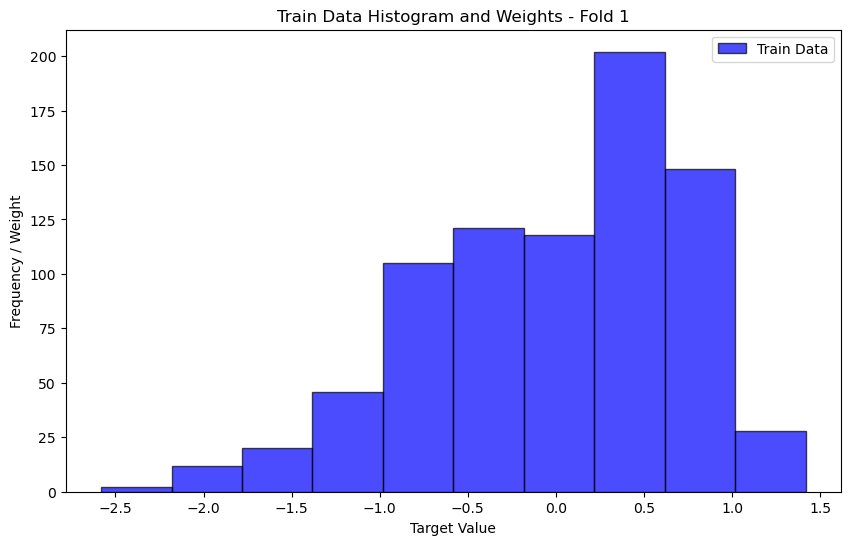

KeyboardInterrupt: 

In [73]:
mean_score, mean_corr, mean_filter_score, mean_filter_corr, fold_scores, fold_corrs, filter_fold_scores, filter_fold_corrs = tan_regression(combined_data,scores,age, metric=metric,pre="center",n_splits=5)

In [ ]:
# from joblib import Parallel, delayed
# from sklearn.utils import shuffle

# def permutation_test(data, scores, age, metric="riemann", pre="znorm", n_splits=10, n_permutations=1000, n_jobs=1):
#     # Lists to store results for all permutations
#     perm_mean_scores = []
#     perm_mean_corrs = []
#     perm_mean_filter_scores = []
#     perm_mean_filter_corrs = []
    
#     perm_fold_scores = []  # To store fold scores for all permutations
#     perm_fold_corrs = []
#     perm_filter_fold_scores = []
#     perm_filter_fold_corrs = []
    
#     # Function to run one permutation
#     def run_permutation(i):
#         # Shuffle the scores
#         shuffled_scores = shuffle(scores, random_state=i)
        
#         # Fit the model with shuffled data
#         perm_mean_score, perm_mean_corr, perm_mean_filter_score, perm_mean_filter_corr, fold_scores, fold_corrs, filter_fold_scores, filter_fold_corrs = tan_regression(data, shuffled_scores, age, metric, pre, n_splits)
        
#         # Append the mean results to the lists
#         perm_mean_scores.append(perm_mean_score)
#         perm_mean_corrs.append(perm_mean_corr)
#         perm_mean_filter_scores.append(perm_mean_filter_score)
#         perm_mean_filter_corrs.append(perm_mean_filter_corr)
        
#         # Append the fold-specific results to the lists
#         perm_fold_scores.append(fold_scores)
#         perm_fold_corrs.append(fold_corrs)
#         perm_filter_fold_scores.append(filter_fold_scores)
#         perm_filter_fold_corrs.append(filter_fold_corrs)
    
#     # Run the permutations in parallel
#     Parallel(n_jobs=n_jobs)(delayed(run_permutation)(i) for i in range(n_permutations))
    
#     # Return all the stored results
#     return perm_mean_scores, perm_mean_corrs, perm_mean_filter_scores, perm_mean_filter_corrs, perm_fold_scores, perm_fold_corrs, perm_filter_fold_scores, perm_filter_fold_corrs

# # Example of running the permutation test
# n_permutations = 6  # Set the number of permutations you want
# results = permutation_test(combined_data, scores, age, metric=metric, pre="center", n_splits=10, n_permutations=n_permutations, n_jobs=-1)

# # Extract individual results
# perm_mean_scores, perm_mean_corrs, perm_mean_filter_scores, perm_mean_filter_corrs, perm_fold_scores, perm_fold_corrs, perm_filter_fold_scores, perm_filter_fold_corrs = results

# # Save the permutation test results as numpy arrays
# save_array_to_outputfolder("perm_mean_scores.npy", np.array(perm_mean_scores))
# save_array_to_outputfolder("perm_mean_corrs.npy", np.array(perm_mean_corrs))
# save_array_to_outputfolder("perm_mean_filter_scores.npy", np.array(perm_mean_filter_scores))
# save_array_to_outputfolder("perm_mean_filter_corrs.npy", np.array(perm_mean_filter_corrs))
# save_array_to_outputfolder("perm_fold_scores.npy", np.array(perm_fold_scores))
# save_array_to_outputfolder("perm_fold_corrs.npy", np.array(perm_fold_corrs))
# save_array_to_outputfolder("perm_filter_fold_scores.npy", np.array(perm_filter_fold_scores))
# save_array_to_outputfolder("perm_filter_fold_corrs.npy", np.array(perm_filter_fold_corrs))

# print("All arrays have been saved to the output folder.")

/home/mrstats/zaisou/.conda/envs/IFAslurmv2/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/mrstats/zaisou/.conda/envs/IFAslurmv2/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


KeyboardInterrupt: 

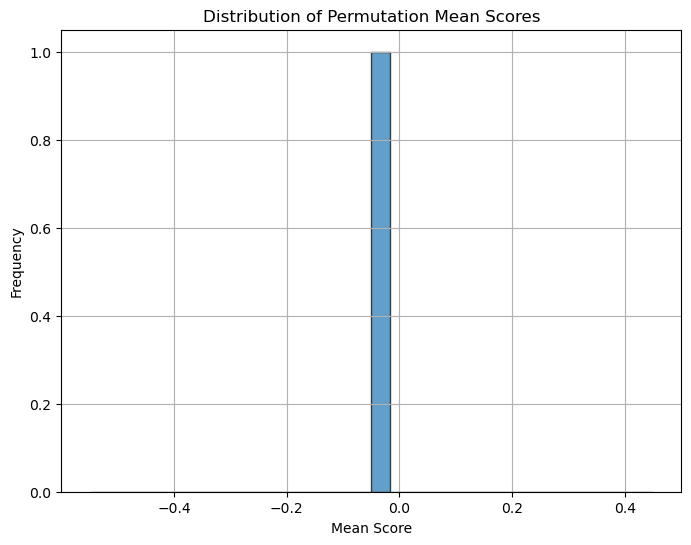

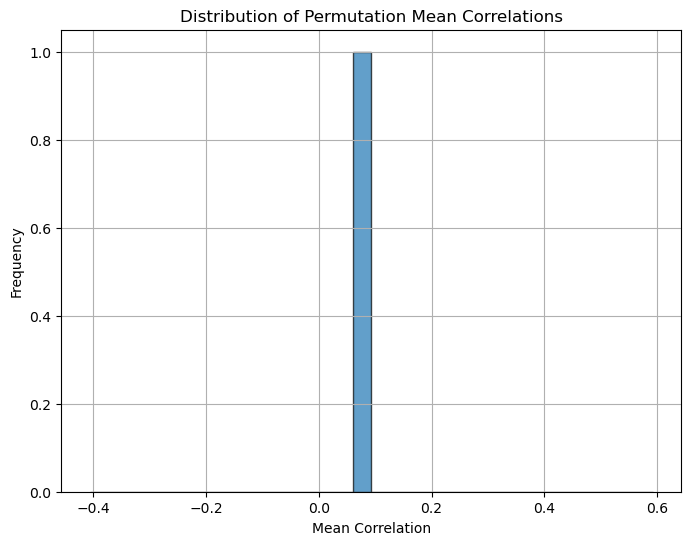

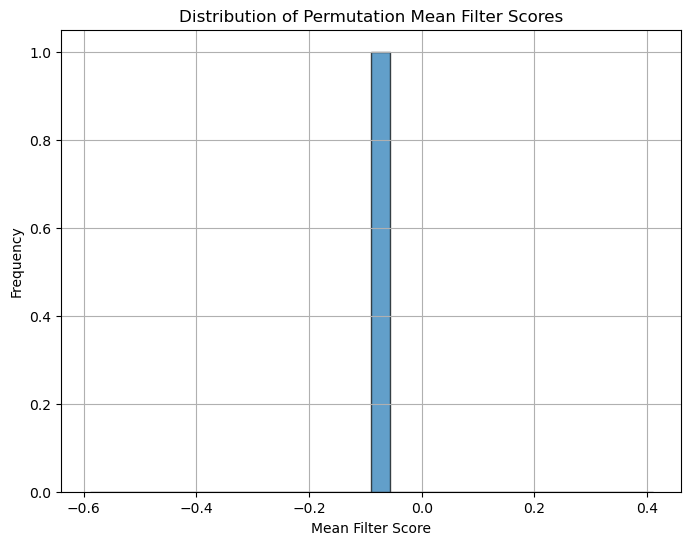

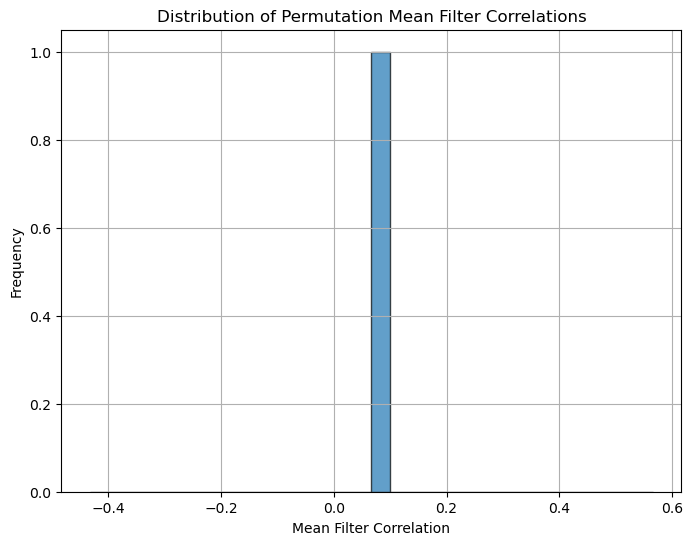

(1, 10)


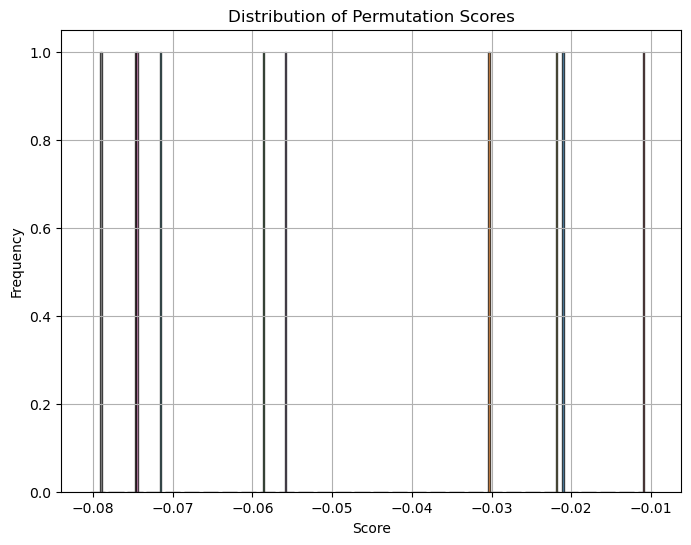

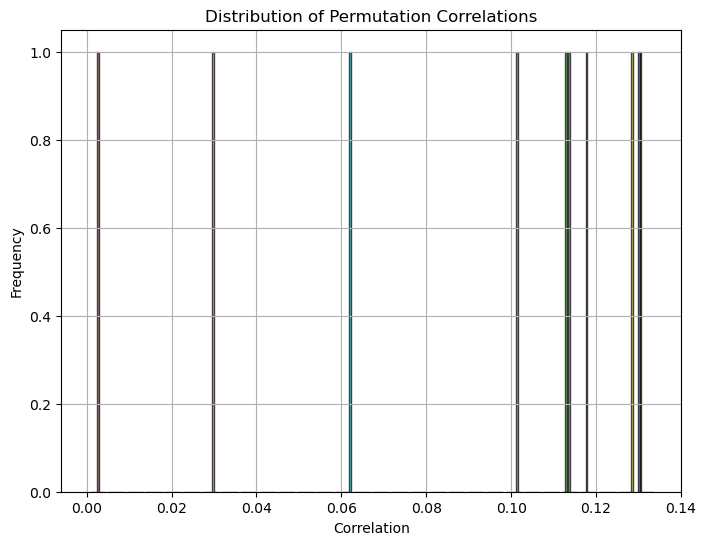

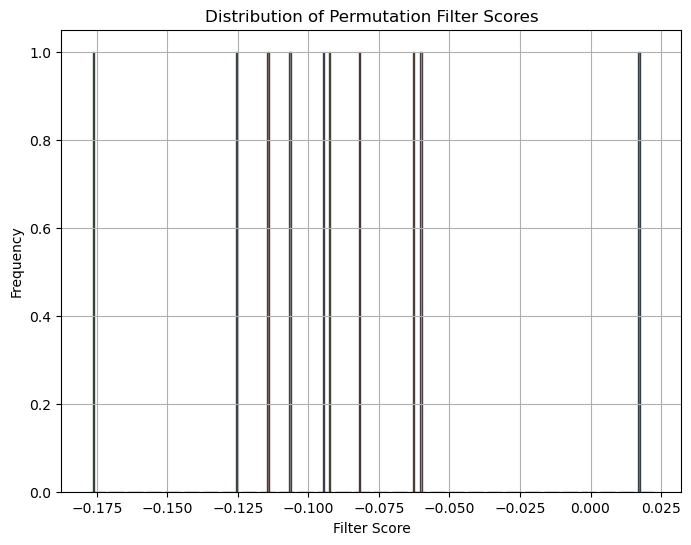

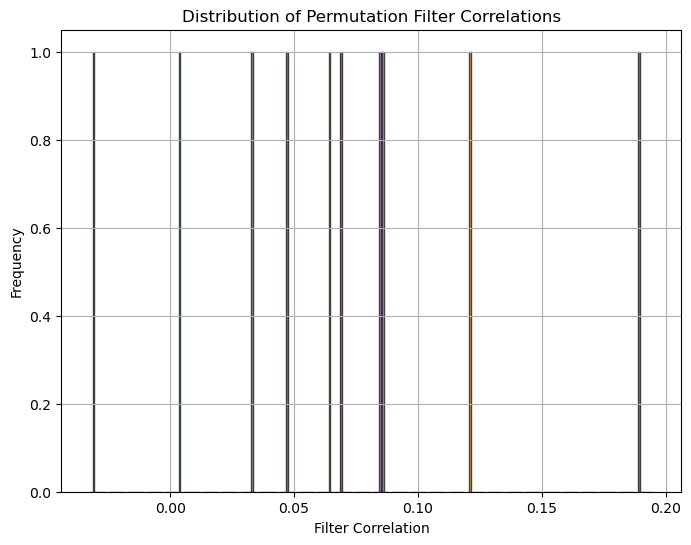

In [7]:
# Load the arrays
perm_mean_scores = load_array_from_outputfolder("perm_mean_scores.npy")
perm_mean_corrs = load_array_from_outputfolder("perm_mean_corrs.npy")
perm_mean_filter_scores = load_array_from_outputfolder("perm_mean_filter_scores.npy")
perm_mean_filter_corrs = load_array_from_outputfolder("perm_mean_filter_corrs.npy")
perm_fold_scores = load_array_from_outputfolder("perm_fold_scores.npy")
perm_fold_corrs = load_array_from_outputfolder("perm_fold_corrs.npy")
perm_filter_fold_scores = load_array_from_outputfolder("perm_filter_fold_scores.npy")
perm_filter_fold_corrs = load_array_from_outputfolder("perm_filter_fold_corrs.npy")

# Plot the distributions
def plot_distribution(data, title, xlabel, ylabel):
    plt.figure(figsize=(8, 6))
    plt.hist(data, bins=30, edgecolor='black', alpha=0.7)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.show()

# Plot mean scores distribution
plot_distribution(perm_mean_scores, "Distribution of Permutation Mean Scores", "Mean Score", "Frequency")
# Plot mean correlations distribution
plot_distribution(perm_mean_corrs, "Distribution of Permutation Mean Correlations", "Mean Correlation", "Frequency")
# Plot mean filter scores distribution
plot_distribution(perm_mean_filter_scores, "Distribution of Permutation Mean Filter Scores", "Mean Filter Score", "Frequency")
# Plot mean filter correlations distribution
plot_distribution(perm_mean_filter_corrs, "Distribution of Permutation Mean Filter Correlations", "Mean Filter Correlation", "Frequency")

print(perm_fold_scores.shape)
# Plot mean scores distribution
plot_distribution(perm_fold_scores, "Distribution of Permutation Scores", "Score", "Frequency")
# Plot mean correlations distribution
plot_distribution(perm_fold_corrs, "Distribution of Permutation Correlations", "Correlation", "Frequency")
# Plot mean filter scores distribution
plot_distribution(perm_filter_fold_scores, "Distribution of Permutation Filter Scores", "Filter Score", "Frequency")
# Plot mean filter correlations distribution
plot_distribution(perm_filter_fold_corrs, "Distribution of Permutation Filter Correlations", "Filter Correlation", "Frequency")

### Create 1 Fold and Filters for Rest of Pipeline

In [9]:
data = np.concatenate((groupA_parcellated_array, groupB_parcellated_array))
labels = np.concatenate((np.ones(len(groupA_parcellated_array)), np.zeros(len(groupB_parcellated_array))))
paths = np.concatenate((groupA_paths_filtered, groupB_paths_filtered))
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=random_state)
splits = list(skf.split(data, labels))

In [10]:
fold = 0
fold_outputfolder = f"fold_{fold}"
if not os.path.exists(os.path.join(outputfolder, f"fold_{fold}")):
    os.makedirs(os.path.join(outputfolder, f"fold_{fold}"))
if not os.path.exists(os.path.join(outputfolder, f"fold_{fold}", "results")):
    os.makedirs(os.path.join(outputfolder, f"fold_{fold}", "results"))

train_parcellated, test_parcellated = data[splits[fold][0]], data[splits[fold][1]]
train_labels, test_labels = labels[splits[fold][0]], labels[splits[fold][1]]
train_paths, test_paths = paths[splits[fold][0]], paths[splits[fold][1]]

groupA_train_parcellated = train_parcellated[train_labels == 1]
groupA_test_parcellated = test_parcellated[test_labels == 1]
groupA_train_paths = train_paths[train_labels == 1]
groupA_test_paths = test_paths[test_labels == 1]

groupB_train_parcellated = train_parcellated[train_labels == 0]
groupB_test_parcellated = test_parcellated[test_labels == 0]
groupB_train_paths = train_paths[train_labels == 0]
groupB_test_paths = test_paths[test_labels == 0]

In [ ]:
# https://pyriemann.readthedocs.io/en/latest/auto_examples/signal/plot_covariance_estimation.html
cov_est = Covariances(estimator='lwf')
groupA_train_parcellated_covs = cov_est.transform(np.transpose(groupA_train_parcellated, (0, 2, 1)))
groupB_train_parcellated_covs = cov_est.transform(np.transpose(groupB_train_parcellated, (0, 2, 1)))

In [ ]:
if Tangent_Class:
    fkt_riem_eigs, filters, _, _ =  tangent_classifier(groupA_train_parcellated_covs,  groupB_train_parcellated_covs, TSVM=True, TLDA=False, tangent_calc=True, metric=metric,visualize=True,n=0)
else:
    fkt_riem_eigs, filters, filtersA, filtersB = FKT(groupA_train_parcellated_covs, groupB_train_parcellated_covs, mean=metric, average=True, visualize=True, n=0)
n_filters_per_group

filtersA = filters[:, -n_filters_per_group:]
filtersB = filters[:, :n_filters_per_group]
filters = np.concatenate((filtersB, filtersA), axis=1)

In [ ]:
_, filters, _, _ = tangent_classifier_multi(groupA_train_parcellated_covs,  groupB_train_parcellated_covs, TSVM=True, TLDA=False, tangent_calc=True, metric=metric,visualize=False,k=3)

In [ ]:
def test_filters(group1_train, group1_test, group_2_train,group2_test, filters, metric="riemann", method='log-cov'):
    train_1, test_1, train_2, test_2 = feature_generation(group1_train, group1_test, group_2_train, group2_test, filters,method=method,metric=metric)
    fold_metrics = test_classifiers(train_1, test_1, train_2, test_2, sample_weights_train=None)
    return fold_metrics

print(test_filters(groupA_train_parcellated, groupA_test_parcellated, groupB_train_parcellated, groupB_test_parcellated, filters, metric=metric,method='log-cov'))
print(test_filters(groupA_train_parcellated, groupA_test_parcellated, groupB_train_parcellated, groupB_test_parcellated, filters, metric=metric,method='log-var'))

In [ ]:
def test_visualize_variance(train_1, train_2, two_filter):
    train_1_transform = np.var(train_1@two_filter,axis=1)
    train_2_transform = np.var(train_2@two_filter,axis=1)

    # Plot when n=1
    plt.figure(figsize=(8, 6))
    plt.scatter(train_1_transform[:, 0], train_1_transform[:, 1], label='Group A Variance', color='blue')
    plt.scatter(train_2_transform[:, 0], train_2_transform[:, 1], label='Group B Variance', color='red')

    # Display plot
    plt.xlabel('Variance Feature B')
    plt.ylabel('Variance Feature A')
    plt.title(f'Variance Comparison')
    
    plt.legend()
    plt.grid(True)
    plt.show()

for i in range(0,3):
    test_visualize_variance(groupA_train_parcellated, groupB_train_parcellated,filters[:,[i,-(i+1)]])

In [ ]:
def test_visualize_variance(train_1, train_2, two_filter):
    import matplotlib.gridspec as gridspec

    # Project data onto filters
    train_1_proj = np.var(train_1@two_filter,axis=1)
    train_2_proj = np.var(train_2@two_filter,axis=1)

    # Create figure and gridspec layout
    fig = plt.figure(figsize=(8, 8))
    gs = gridspec.GridSpec(4, 4)

    # Define the axes
    ax_scatter = fig.add_subplot(gs[1:4, 0:3])
    ax_hist_x = fig.add_subplot(gs[0, 0:3], sharex=ax_scatter)
    ax_hist_y = fig.add_subplot(gs[1:4, 3], sharey=ax_scatter)

    # Scatter plot
    ax_scatter.scatter(train_1_proj[:, 0], train_1_proj[:, 1], label='Group A', color='blue', alpha=0.5)
    ax_scatter.scatter(train_2_proj[:, 0], train_2_proj[:, 1], label='Group B', color='red', alpha=0.5)
    ax_scatter.set_xlabel('Projection onto Filter B')
    ax_scatter.set_ylabel('Projection onto Filter A')
    ax_scatter.legend()
    ax_scatter.grid(True)

    # Histograms
    bins = 30

    # Histograms for X axis (top)
    ax_hist_x.hist(train_1_proj[:, 0], bins=bins, color='blue', alpha=0.5, density=True, label='Group A')
    ax_hist_x.hist(train_2_proj[:, 0], bins=bins, color='red', alpha=0.5, density=True, label='Group B')
    ax_hist_x.set_ylabel('Density')
    ax_hist_x.legend()
    ax_hist_x.grid(True)

    # Histograms for Y axis (right)
    ax_hist_y.hist(train_1_proj[:, 1], bins=bins, orientation='horizontal', color='blue', alpha=0.5, density=True)
    ax_hist_y.hist(train_2_proj[:, 1], bins=bins, orientation='horizontal', color='red', alpha=0.5, density=True)
    ax_hist_y.set_xlabel('Density')
    ax_hist_y.grid(True)

    # Hide tick labels on histograms to avoid clutter
    plt.setp(ax_hist_x.get_xticklabels(), visible=False)
    plt.setp(ax_hist_y.get_yticklabels(), visible=False)

    # Adjust layout
    plt.tight_layout()
    plt.show()


for i in range(0,3):
    test_visualize_variance(groupA_train_parcellated, groupB_train_parcellated,filters[:,[i,-(i+1)]])

In [ ]:
# plotting.view_surf(hcp.mesh.inflated, hcp.cortex_data(hcp.unparcellate(filters[:,0], hcp.mmp)), threshold=np.percentile(np.abs(filters[:,0]), 95), bg_map=hcp.mesh.sulc)

### Calculate MIGP

In [ ]:
def migp(subs, batch_size=2, m=4800):
    W_gpu = None
    for batch_start in range(0, len(subs), batch_size):
        # Select the current batch of subjects
        batch_subs = subs[batch_start:batch_start + batch_size]
        batch_paths = [path for sublist in batch_subs for path in sublist]

        concatenated_data = []

        for task in batch_paths:
            X = nib.load(task).get_fdata()
            Xn = hcp.normalize(X-X.mean(axis=1, keepdims=True))
            # print(Xn.mean(axis=0).mean())
            # print(Xn.std(axis=0).mean())
            concatenated_data.append(Xn)
            del X, Xn
            
        try:
            # Concatenate data along the first axis using numpy
            batch = np.concatenate(concatenated_data, axis=0)
            batch = hcp.normalize(batch - batch.mean(axis=1,keepdims=True))
            del concatenated_data

            with torch.no_grad():
                # Convert to torch tensor and move to GPU
                batch_gpu = torch.tensor(batch, dtype=torch.float32, device="cuda")
                del batch
                if torch.isnan(batch_gpu).any():
                    print("NaNs detected in the batch data. Aborting SVD operation.")
                    del batch_gpu
                    torch.cuda.empty_cache()
                    return None
                if W_gpu is None:
                    combined_data_gpu = batch_gpu
                else:
                    combined_data_gpu = torch.cat([W_gpu, batch_gpu], dim=0)
                del batch_gpu
                torch.cuda.empty_cache()

                # # Calculate size in GB
                # size_in_gb = combined_data_gpu.element_size() * combined_data_gpu.nelement() / (1024**3)
                # print(f"Size of the array: {size_in_gb:.2f} GB")
                # cpu_mem()
                # gpu_mem()
                # Perform SVD on the GPU
                # Check for NaNs in the data

                # _, S_gpu, Vh_gpu = torch.linalg.svd(combined_data_gpu, full_matrices=False)
                _, Q = torch.linalg.eigh(combined_data_gpu@combined_data_gpu.T)
                # cpu_mem()
                # gpu_mem()
                # Compute the updated W on the GPU
                # W_gpu = torch.diag(S_gpu[:m]) @ Vh_gpu[:m, :]
                # Returned in Ascending order
                W_gpu = Q[:, -m:].T@combined_data_gpu
                del Q, combined_data_gpu  # Free up GPU memory
                torch.cuda.empty_cache()
                print(batch_start, "done")
        except Exception as e:
            print(f"Failed during GPU processing: {e}")
            if "combined_data_gpu" in locals():
                del combined_data_gpu
            if "Q" in locals():
                del Q
            if "W_gpu" in locals():
                del W_gpu
            torch.cuda.empty_cache()
            return None

    # Transfer W back to CPU only at the end
    W = W_gpu.cpu().numpy()
    del W_gpu  # Free up GPU memory

    return W

In [ ]:
reducedsubsA = migp((groupA_train_paths))
save_array_to_outputfolder(os.path.join(fold_outputfolder,'reducedsubsA.npy'), reducedsubsA)

In [ ]:
reducedsubsB = migp((groupB_train_paths))
save_array_to_outputfolder(os.path.join(fold_outputfolder,'reducedsubsB.npy'), reducedsubsB)

### Load MIGP

In [ ]:
if "reducedsubsA" in locals():
    del reducedsubsA
if "reducedsubsB" in locals():
    del reducedsubsB
reducedsubsA_loaded = load_array_from_outputfolder(os.path.join(fold_outputfolder,'reducedsubsA.npy'))
reducedsubsB_loaded = load_array_from_outputfolder(os.path.join(fold_outputfolder,'reducedsubsB.npy'))

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

reducedsubs_combined_gpu = torch.tensor(np.concatenate((reducedsubsA_loaded,reducedsubsB_loaded),axis=0),dtype=torch.float32,device=device)
# Returned in Descending Order
Urc,_,_ = torch.linalg.svd(reducedsubs_combined_gpu, full_matrices=False)
reducedsubs_combined = (Urc[:,:4800].T@reducedsubs_combined_gpu).cpu().numpy()
del Urc, reducedsubs_combined_gpu

reducedsubs_gpu = torch.tensor(reducedsubs_combined, dtype=torch.float32, device=device)
U,_,_ = torch.linalg.svd(reducedsubs_gpu, full_matrices=False)
reducedsubs= (U[:,:1000].T@reducedsubs_gpu).cpu().numpy()
del U, reducedsubs_gpu

### Run Haufe Transform

1. Should I pinv(F) or just multiply by F

In [ ]:
def process_subject_haufe(sub,pinv_TF):
    try:
        concatenated_data = []
        for task in sub:
            X = nib.load(task).get_fdata(dtype=np.float32)
            Xn = hcp.normalize(X-X.mean(axis=1, keepdims=True))
            concatenated_data.append(Xn)
            del X, Xn

        # Concatenate data along the first axis
        subject = np.concatenate(concatenated_data, axis=0)
        del concatenated_data  # Explicitly delete the concatenated data list

        Xp = hcp.normalize(subject - subject.mean(axis=1, keepdims=True))
        del subject
        Xpf = pinv_TF@Xp
        del Xp
        return Xpf

    except Exception as e:
        print(f"Error processing subject: {e}")
        traceback.print_exc()  # Print the full traceback
        return None


def haufe_transform(F, parcellated,paths):
    
    # Ensure the tensors are on the correct device
    pinv_TF = np.linalg.pinv(parcellated.reshape(-1,parcellated.shape[-1]) @ np.linalg.pinv(F.T))


    # pinv_TF_list = pinv_TF.reshape(len(paths),F.shape[1],pinv_TF.shape[0])
    pinv_TF_list = (np.array_split(pinv_TF, len(paths), axis=1))

    with ProcessPoolExecutor(max_workers=(int(os.cpu_count()*.5))) as executor:
        # Use map to process subjects in parallel
        blocks = np.array(list(executor.map(process_subject_haufe, paths,pinv_TF_list)))
        print(blocks.shape)
        return (blocks.sum(axis=0))

In [ ]:
# filtersA_transform = haufe_transform(filtersA[:,-n_filters_per_group:],groupA_train_parcellated,groupA_train_paths)
# save_array_to_outputfolder("filtersA_transform.npy", filtersA_transform)

filtersA_transform = haufe_transform(filtersA,groupA_train_parcellated,groupA_train_paths)
save_array_to_outputfolder(os.path.join(fold_outputfolder,"filtersA_transform.npy"), filtersA_transform)

In [ ]:
# filtersB_transform = haufe_transform(filtersB[:,-n_filters_per_group:],groupB_train_parcellated,groupB_train_paths)
# save_array_to_outputfolder("filtersB_transform.npy", filtersB_transform)

filtersB_transform = haufe_transform(filtersB,groupB_train_parcellated,groupB_train_paths)
save_array_to_outputfolder(os.path.join(fold_outputfolder,"filtersB_transform.npy"), filtersB_transform)

### Load Haufe Transform

In [ ]:
filtersA_transform = load_array_from_outputfolder(os.path.join(fold_outputfolder,'filtersA_transform.npy'))
filtersB_transform = load_array_from_outputfolder(os.path.join(fold_outputfolder,'filtersB_transform.npy'))

### Orthonormalize Filters

In [ ]:
def orthonormalize_filters(W1, W2):
    # Stack the two filters into a single matrix
    W = np.concatenate((W1, W2)).T  # shape: (features x 2)
    print(W.shape)
    
    # Perform QR decomposition to orthonormalize the filters
    Q, _ = np.linalg.qr(W)
    
    print(Q.shape)

    # Verify that the inner product between the two orthonormalized vectors is 0 (orthogonality)
    print(f'Inner product between Q[:, 0] and Q[:, 1]: {np.dot(Q[:, 0].T, Q[:, 1])} (should be 0)')
    
    # Verify that the inner product within each vector is 1 (normalization)
    print(f'Norm of Q[:, 0]: {np.dot(Q[:, 0].T, Q[:, 0])} (should be 1)')
    print(f'Norm of Q[:, 1]: {np.dot(Q[:, 1].T, Q[:, 1])} (should be 1)')
    
    return Q
# Example usage

filters = orthonormalize_filters(filtersA_transform, filtersB_transform)

In [ ]:
plotting.view_surf(hcp.mesh.inflated, hcp.cortex_data(filters[:,0]), threshold=np.percentile(np.abs(filters[:,0]), 90), bg_map=hcp.mesh.sulc)

In [ ]:
plotting.view_surf(hcp.mesh.inflated, hcp.cortex_data(filters[:,3]), threshold=np.percentile(np.abs(filters[:,3]), 90), bg_map=hcp.mesh.sulc)

### PPCA

In [ ]:
def call_pca_dim(Data=None,eigs=None,N=None):
   # Start MATLAB engine
    eng = matlab.engine.start_matlab()
    
    # Add the path to the MATLAB function
    eng.addpath("/project/3022057.01/IFA/melodic", nargout=0)
    
    if Data is not None:
      # Call the MATLAB function
      prob = eng.pca_dim(matlab.double(Data))
      eig_vectors = np.array(prob['E'])
    else:
      prob = eng.pca_dim_eigs(matlab.double(eigs.tolist()), matlab.double([N]))

    # Extract and convert each variable
    lap = np.array(prob['lap']).flatten().reshape(-1, 1)
    bic = np.array(prob['bic']).flatten().reshape(-1, 1)
    rrn = np.array(prob['rrn']).flatten().reshape(-1, 1)
    AIC = np.array(prob['AIC']).flatten().reshape(-1, 1)
    MDL = np.array(prob['MDL']).flatten().reshape(-1, 1)
    eig = np.array(prob['eig']).flatten()
    orig_eig = np.array(prob['orig_eig']).flatten()
    leig = np.array(prob['leig']).flatten()

    # Stop MATLAB engine
    eng.eval('clearvars', nargout=0)
    eng.quit()
    
    plt.figure(figsize=(10, 6))
    plt.scatter(np.arange(len(eig)),eig,label="Adjusted Eigenspectrum")
    plt.scatter(np.arange(len(orig_eig)),orig_eig,label="Eigenspectrum")
    plt.xlabel('Index')
    plt.ylabel('Eigenvalue')
    plt.legend()
    plt.title('Scree Plot')
    plt.show()


    # Use SimpleImputer to handle any missing values
    imputer = SimpleImputer(strategy='mean')
    lap = imputer.fit_transform(lap)
    bic = imputer.fit_transform(bic)
    rrn = imputer.fit_transform(rrn)
    AIC = imputer.fit_transform(AIC)
    MDL = imputer.fit_transform(MDL)
    
    # Use StandardScaler to standardize the data
    scaler = StandardScaler()
    lap_std = scaler.fit_transform(lap)
    bic_std = scaler.fit_transform(bic)
    rrn_std = scaler.fit_transform(rrn)
    AIC_std = scaler.fit_transform(AIC)
    MDL_std = scaler.fit_transform(MDL)
    
    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.scatter(np.arange(len(lap_std)), lap_std, label='Laplacian')
    plt.scatter(np.arange(len(bic_std)), bic_std, label='BIC')
    plt.scatter(np.arange(len(rrn_std)), rrn_std, label='RRN')
    plt.scatter(np.arange(len(AIC_std)), AIC_std, label='AIC')
    plt.scatter(np.arange(len(MDL_std)), MDL_std, label='MDL')
    
    plt.xlabel('Index')
    plt.ylabel('Standardized Value')
    plt.legend()
    plt.title('Scatter Plot of Standardized Eigenvalues and Model Order Selection Values')
    plt.show()
   
    return np.argmax(rrn_std)+1

def get_n_and_some(data):
    # Check the shape of the data and determine the axis for mean subtraction

    # Move data to GPU if available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    data_gpu = data.to(device, dtype=torch.float32)
    groupN = data_gpu.shape[1] - 1

    # Subtract the mean along the specified axis
    data_centered = data_gpu - torch.mean(data_gpu, dim=1, keepdim=True)
    del data_gpu  # Free up GPU memory
    torch.cuda.empty_cache()
    # Perform SVD decomposition
    _, d, v = torch.svd(data_centered)
    del data_centered  # Free up GPU memory
    torch.cuda.empty_cache()
    
    # Convert singular values to eigenvalues
    e = (d ** 2) / groupN

    # Move eigenvalues to CPU and convert to NumPy array
    e_np = e.cpu().numpy()
    del e, d  # Free up GPU memory
    torch.cuda.empty_cache()

    # Determine the number of components
    n_components = torch.tensor(call_pca_dim(eigs=e_np, N=groupN),device=device,dtype=torch.int32)

    return n_components, v.T

def PPCA(data, filters=None, threshold=1.6, niters=10, n=-1):
    n_components = -1
    n_prev = -2
    i = 0

    # Move data to GPU if available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    data_gpu = torch.tensor(data,device=device, dtype=torch.float32)

    while n_components != n_prev and i < niters:
        n_prev = n_components
        if filters is not None:
            basis_gpu =  torch.tensor(filters.T,device=device, dtype=torch.float32)
        else:
            n_components, vt = get_n_and_some(data_gpu)
            if n <= 0:
                basis_gpu = vt[:n_components, :]
            else:
                print(n)
                basis_gpu = vt[:n, :]
            del vt
            torch.cuda.empty_cache()
        
        print(n_prev, n_components)

        # Estimate noise and residual standard deviation
        est_noise = data_gpu - (data_gpu @ torch.linalg.pinv(basis_gpu)) @ basis_gpu
        est_residual_std = torch.std(est_noise,dim=0,correction=torch.linalg.matrix_rank(basis_gpu))
        del est_noise
        torch.cuda.empty_cache()

        # Normalize the data
        data_gpu = (data_gpu / est_residual_std)
        i += 1

    data = data_gpu.cpu().numpy()
    basis = basis_gpu.cpu().numpy()
    # del data_gpu, basis_gpu, est_residual_std
    del data_gpu, basis_gpu
    torch.cuda.empty_cache()
    return data, basis

In [ ]:
subs_data_VN, vt = PPCA(reducedsubs.copy(), threshold=0.0, niters=1)
save_array_to_outputfolder(os.path.join(fold_outputfolder,"subs_data_VN.npy"), subs_data_VN)
save_array_to_outputfolder(os.path.join(fold_outputfolder,"vt.npy"), vt)

### Load PPCA Results

In [ ]:
subs_data_VN = load_array_from_outputfolder(os.path.join(fold_outputfolder,"subs_data_VN.npy"))
vt = load_array_from_outputfolder(os.path.join(fold_outputfolder,"vt.npy"))

### Combine Basis

In [ ]:
# Columns are samples i.e. XXT is the covariance matrix formed
def whiten(X,n_components, method="SVD", visualize=False):
    # -1 to account for demean
    n_samples = X.shape[-1]-1
    X_mean = X.mean(axis=-1)
    X -= X_mean[:, np.newaxis]

    if method == "SVD":
        u, d = svd(X, full_matrices=False, check_finite=False)[:2]
        # Give consistent eigenvectors for both svd solvers
        # u *= np.sign(u[0])
        K = (u / d).T[:n_components]  # see (6.33) p.140
        del u, d
        whitening_matrix = np.sqrt(n_samples)*K
    elif method == "Cholesky":
    # Does not Orthogonalize, just has unit covariance
        # Step 2: Perform Cholesky decomposition
        L = np.linalg.cholesky(np.cov(X,ddof=1))
        # Step 3:
        whitening_matrix = np.linalg.inv(L)
    elif method == "InvCov":
        # Calculate the covariance matrix of the centered data
        cov_matrix = np.cov(X)
        # Perform eigenvalue decomposition of the covariance matrix
        eigvals, eigvecs = np.linalg.eigh(cov_matrix)
        # Calculate the whitening matrix
        D_inv_sqrt = np.diag(1.0 / np.sqrt(eigvals))
        whitening_matrix = eigvecs @ D_inv_sqrt @ eigvecs.T
   
    whitened_data = whitening_matrix@X

    return whitened_data, whitening_matrix

# Combine Basis
combined_spatial = np.vstack((vt,filters.T))

# Whiten
whitened_basis, whitening_matrix_pre = whiten(combined_spatial,n_components=combined_spatial.shape[0],method="InvCov",visualize=True)
subs_data_com_VN, _ = PPCA(reducedsubs_combined.copy(), filters=whitened_basis.T, threshold=0.0, niters=1)

# tempbasis = np.linalg.pinv(subs_data_com_VN@np.linalg.pinv(whitened_basis))@subs_data_com_VN
# whitened_basis, _ = whiten(tempbasis,n_components=tempbasis.shape[0],method="InvCov",visualize=True)

# for i in range(0,3):
#     # Readjust the MiGP data based on the new basis
#     subs_data_com_VN, _ = PPCA(subs_data_com_VN.copy(), filters=whitened_basis.T, threshold=0.0, niters=1)

#     # Recalculate the basis via Haufe transform based on adjusted MIGP data
#     tempbasis = np.linalg.pinv(subs_data_com_VN@np.linalg.pinv(whitened_basis))@subs_data_com_VN

#     # Rewhiten the basis
#     whitened_basis, whitening_matrix = whiten(tempbasis,n_components=combined_spatial.shape[0],method="InvCov",visualize=True)
    

### ICA

In [ ]:
def plot_scree(data, n_components=None):
    """
    Perform PCA on the provided dataset and plot a scree plot.

    Parameters:
    - data: np.array or pd.DataFrame, the dataset to perform PCA on.
    - n_components: int or None, the number of principal components to compute. 
                    If None, all components are computed.

    Returns:
    - pca: PCA object after fitting to the data.
    """    
    # # Standardize the data
    # # Initialize PCA
    # pca = PCA()
    
    # # Fit PCA on the data
    # pca.fit(data)
    
    # # Calculate explained variance ratio
    # explained_variance_ratio = pca.explained_variance_ratio_
    _, S, _ = np.linalg.svd(data, full_matrices=False)
    e = (S ** 2) / (data.shape[-1]-1)
    # Create the scree plot
    print(e)
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(S) + 1), e, marker='o', linestyle='--')
    plt.title('Scree Plot')
    plt.xlabel('Principal Component')
    plt.ylabel('Explained Variance Ratio')
    plt.xticks(range(1, len(S) + 1))
    plt.grid()
    plt.show()

Atemp = np.linalg.pinv(subs_data_com_VN@np.linalg.pinv(whitened_basis))
plot_scree(Atemp@subs_data_com_VN)

In [ ]:
def ICA(data,whitened_data):
    ica = FastICA(whiten=False)
    # Takes in array-like of shape (n_samples, n_features) and returns ndarray of shape (n_samples, n_components)
    IFA_components = ica.fit_transform(whitened_data.T).T
    A = data@np.linalg.pinv(IFA_components)
    W = np.linalg.pinv(A)
    print("The combined unmixing matrix correctly calculates the components: ", np.allclose(W@data, IFA_components))
    print("The combined mixing matrix correctly reconstructs the low rank data_demean: ", np.allclose(A@IFA_components, A@(W@data)))


    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    # Heat map for the combined unmixing matrix
    sns.heatmap(W@data, cmap='viridis', ax=axes[0])
    axes[0].set_title('Combined Unmixing Matrix (W @ data)')
    axes[0].set_xlabel('Components')
    axes[0].set_ylabel('Samples')

    # Heat map for the IFA components
    sns.heatmap(IFA_components, cmap='viridis', ax=axes[1])
    axes[1].set_title('IFA Components')
    axes[1].set_xlabel('Components')
    axes[1].set_ylabel('Samples')

    # Adjust layout
    plt.tight_layout()
    plt.show()

    return IFA_components, A, W

In [ ]:
raw_components_combined, A_combined, W_combined = ICA(subs_data_com_VN,whitened_basis)

In [ ]:
vtwhiten,_ = whiten(vt,n_components=vt.shape[0],method="SVD")
subs_data_VN, _ = PPCA(reducedsubs_combined.copy(), filters=vtwhiten.T, threshold=0.0, niters=1)
raw_components_major, A_major, W_major = ICA(subs_data_VN,vtwhiten)

In [ ]:
subs_data_VN_more, vtmore = PPCA(reducedsubs.copy(), threshold=0.0, niters=1,n=vt.shape[0]+filters.shape[1])
vtmorewhiten,_ = whiten(vtmore,n_components=vtmore.shape[0],method="SVD")
subs_data_VN_more, _ = PPCA(reducedsubs_combined.copy(), filters=vtmorewhiten.T, threshold=0.0, niters=1)

raw_components_major_more, A_major_more, W_major_more = ICA(subs_data_VN_more,vtmorewhiten)

In [ ]:
save_array_to_outputfolder(os.path.join(fold_outputfolder,"raw_components_combined.npy"), raw_components_combined)
save_array_to_outputfolder(os.path.join(fold_outputfolder,"A_combined.npy"), A_combined)
save_array_to_outputfolder(os.path.join(fold_outputfolder,"W_combined.npy"), W_combined)
save_array_to_outputfolder(os.path.join(fold_outputfolder,"raw_components_major.npy"), raw_components_major)
save_array_to_outputfolder(os.path.join(fold_outputfolder,"A_major.npy"), A_major)
save_array_to_outputfolder(os.path.join(fold_outputfolder,"W_major.npy"), W_major)
save_array_to_outputfolder(os.path.join(fold_outputfolder,"raw_components_major_more.npy"), raw_components_major_more)
save_array_to_outputfolder(os.path.join(fold_outputfolder,"A_major_more.npy"), A_major_more)
save_array_to_outputfolder(os.path.join(fold_outputfolder,"W_major_more.npy"), W_major_more)

### Load ICA

In [ ]:
raw_components_combined = load_array_from_outputfolder(os.path.join(fold_outputfolder,"raw_components_combined.npy"))
A_combined = load_array_from_outputfolder(os.path.join(fold_outputfolder,"A_combined.npy"))
W_combined = load_array_from_outputfolder(os.path.join(fold_outputfolder,"W_combined.npy"))
raw_components_major = load_array_from_outputfolder(os.path.join(fold_outputfolder,"raw_components_major.npy"))
A_major = load_array_from_outputfolder(os.path.join(fold_outputfolder,"A_major.npy"))
W_major = load_array_from_outputfolder(os.path.join(fold_outputfolder,"W_major.npy"))
raw_components_major_more = load_array_from_outputfolder(os.path.join(fold_outputfolder,"raw_components_major_more.npy"))
A_major_more = load_array_from_outputfolder(os.path.join(fold_outputfolder,"A_major_more.npy"))
W_major_more = load_array_from_outputfolder(os.path.join(fold_outputfolder,"W_major_more.npy"))

### Threshold

In [ ]:
def noise_projection(W,data, visualize=True):

    Signals = np.linalg.pinv(W)@(W@data)
    Residuals = data - Signals
    residual_std = np.std(Residuals,axis=0,ddof=np.linalg.matrix_rank(W))
    # Trace of I-pinv(W)(W) is equal to the nullity (n-m gvien n > m) of the reconstructed matrix 
    # trace = data.shape[0] - np.linalg.matrix_rank(W)
    # residual_std2 = (np.einsum('ij,ij->j', Residuals, Residuals)/(trace))**.5


    if visualize:
        n=1000
        plt.figure()
        plt.plot(Signals[:n,0:1])
        plt.plot(Residuals[:n,0:1])
        # plt.plot(data[:n,0:1])
        # plt.plot(data[:n,0:1] - (Signals[:n,0:1]+Residuals[:n,0:1]))
        plt.legend(['Signal','Noise', 'Data' ,'Reconstruction Error'])
        plt.title("Calculations based on pinv(W)W Projection Matrix")
        plt.show()

        plt.scatter(range(0,residual_std.shape[0]), residual_std)
        plt.title("Noise std Per Voxel based on pinv(W)W Projection Matrix")
        plt.show()
    return residual_std


def threshold_and_visualize(data, W, components,visualize=False):
    
    voxel_noise = noise_projection(W,data)[:, np.newaxis]
    z_scores_array = np.zeros_like(components)
    z_scores = np.zeros_like(components)

    # Process each filter individually
    for i in range(components.shape[1]):
        z_score = ((components[:, i:i+1]))/voxel_noise
        # P(Z < -z \text{ or } Z > z) = (1 - \text{CDF}(z)) + (1 - \text{CDF}(z)) = 2 \times (1 - \text{CDF}(z))
        p_values = 2 * (1 - norm.cdf(np.abs(z_score)))
        # Apply multiple comparisons correction for the current filter https://www.statsmodels.org/dev/generated/statsmodels.stats.multitest.multipletests.html
        reject, pvals_corrected, _, _ = multipletests(p_values.flatten(), alpha=0.05, method='fdr_bh')
        masked_comp = z_score*(reject[:,np.newaxis])
        # print(masked_comp, reject[:,np.newaxis],z_score)
        z_scores_array[:, i:i+1] = masked_comp        
        z_scores[:,i:i+1] = z_score

       # Skip the iteration if there are no significant values
        if not np.any(reject) and visualize:
            print(f'Component {i} did not contain any significant values')
            plt.figure()
            plt.hist(z_score, bins=30, color='blue', alpha=0.7)
            plt.title(f"Histogram for Filter {i} NO SIGNIFICANT VALUES")
            plt.xlabel('Value')
            plt.ylabel('Frequency')
            plt.show()
        else:
            if visualize:
                # Create a figure and axes for subplots (1 row of 2 plots per filter)
                fig, axes = plt.subplots(1, 2, figsize=(18, 10))

                ax_hist1 = axes[0]
                ax_img = axes[1]

                # Plot the histogram of the current filter
                ax_hist1.hist(z_score, bins=30, color='blue', alpha=0.7)
                ax_hist1.set_title(f"Histogram for Filter {i}")
                ax_hist1.set_xlabel('Value')
                ax_hist1.set_ylabel('Frequency')
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    # Heat map for the combined unmixing matrix
    sns.heatmap(z_scores, cmap='viridis', ax=axes[0])
    axes[0].set_title('z_score')
    axes[0].set_xlabel('Components')
    axes[0].set_ylabel('Samples')

    # Heat map for the IFA components
    sns.heatmap(z_scores_array, cmap='viridis', ax=axes[1])
    axes[1].set_title('z_score thresh')
    axes[1].set_xlabel('Components')
    axes[1].set_ylabel('Samples')

    # Adjust layout
    plt.tight_layout()
    plt.show()

    return z_scores, z_scores_array

In [ ]:
z_scores_unthresh, z_scores_thresh = threshold_and_visualize(subs_data_com_VN, W_combined, raw_components_combined.T, visualize=False)

In [ ]:
z_scores_unthresh_major, z_scores_thresh_major = threshold_and_visualize(subs_data_VN, W_major, raw_components_major.T, visualize=False)

In [ ]:
z_scores_unthresh_major_more, z_scores_thresh_major_more = threshold_and_visualize(subs_data_VN_more, W_major_more, raw_components_major_more.T, visualize=False)

In [ ]:
save_array_to_outputfolder(os.path.join(fold_outputfolder,"z_scores_unthresh.npy"), z_scores_unthresh)
save_array_to_outputfolder(os.path.join(fold_outputfolder,"z_scores_thresh.npy"), z_scores_thresh)
save_array_to_outputfolder(os.path.join(fold_outputfolder,"z_scores_unthresh_major.npy"), z_scores_unthresh_major)
save_array_to_outputfolder(os.path.join(fold_outputfolder,"z_scores_thresh_major.npy"), z_scores_thresh_major)
save_array_to_outputfolder(os.path.join(fold_outputfolder,"z_scores_unthresh_major_more.npy"), z_scores_unthresh_major_more)
save_array_to_outputfolder(os.path.join(fold_outputfolder,"z_scores_thresh_major_more.npy"), z_scores_thresh_major_more)

### Load Z maps (Thresholded and Unthresholded)

In [ ]:
z_scores_unthresh = load_array_from_outputfolder(os.path.join(fold_outputfolder,"z_scores_unthresh.npy"))
z_scores_thresh = load_array_from_outputfolder(os.path.join(fold_outputfolder,"z_scores_thresh.npy"))
z_scores_unthresh_major = load_array_from_outputfolder(os.path.join(fold_outputfolder,"z_scores_unthresh_major.npy"))
z_scores_thresh_major = load_array_from_outputfolder(os.path.join(fold_outputfolder,"z_scores_thresh_major.npy"))
z_scores_unthresh_major_more = load_array_from_outputfolder(os.path.join(fold_outputfolder,"z_scores_unthresh_major_more.npy"))
z_scores_thresh_major_more = load_array_from_outputfolder(os.path.join(fold_outputfolder,"z_scores_thresh_major_more.npy"))

In [ ]:
# plotting.view_surf(hcp.mesh.inflated, hcp.cortex_data(z_scores_unthresh[:,20]), threshold=0, bg_map=hcp.mesh.sulc)

### Run and Save Netmats + Dual Regression

In [ ]:
from functools import partial

# https://www.frontiersin.org/journals/neuroscience/articles/10.3389/fnins.2017.00115/full

def calculate_netmat_and_spatial_map(Xn, z_maps):
    """
    Calculate the network matrix (netmat) and spatial map for a given subject and z_maps.
    
    Parameters:
    Xn (array): Time x Grayordinates normalized data matrix (Time x V)
    z_maps (array): Grayordinates x Components map (V x C)

    Returns:
    netmat (array): Components x Components network matrix (C x C)
    spatial_map (array): Components x Grayordinates matrix (C x V)
    """
    # Time x Components
    # Demean the regressors (z_maps)
    z_maps_demeaned = z_maps - z_maps.mean(axis=0, keepdims=True)  # Demean the columns of z_maps (V x C)
    
    # Time x Components
    A = (Xn @ np.linalg.pinv(z_maps_demeaned.T))  # A is Time x Components (T x C)
   
    
    # Normalized Time x Components matrix
    An = hcp.normalize(A)  # An is Time x Components (T x C)
    del A

    # Components x Components network matrix
    netmat = (An.T @ An) / (Xn.shape[0] - 1)  # Netmat is Components x Components (C x C)

    # Components x Grayordinates spatial map
    spatial_map = np.linalg.pinv(An) @ Xn  # Spatial map is Components x Grayordinates (C x V)

    return An, netmat, spatial_map

def dual_regress_sub(sub_path, z_maps_1, z_maps_2):
    try:
        concatenated_data = []
        for task in sub_path:
            # Load and preprocess each task
            X = nib.load(task).get_fdata(dtype=np.float32)  # Grayordinates x Time (V x T)
            Xn = hcp.normalize(X - X.mean(axis=1, keepdims=True))  # Normalizing (V x T)
            concatenated_data.append(Xn)
            del X, Xn
        
        # Concatenate data along the first axis (all tasks into one big matrix)
        subject = np.concatenate(concatenated_data, axis=0)  # Time x Grayordinates (T x V)
        del concatenated_data
        
        # Normalize the concatenated data
        Xn = hcp.normalize(subject - subject.mean(axis=1,keepdims=True))  # Time x Grayordinates normalized data (T x V)
        del subject
        
        # Calculate netmat and spatial map for the first set of z_maps
        An_1, netmat_1, spatial_map_1 = calculate_netmat_and_spatial_map(Xn, z_maps_1)

        # Calculate netmat and spatial map for the second set of z_maps
        An_2, netmat_2, spatial_map_2 = calculate_netmat_and_spatial_map(Xn, z_maps_2)

        return (An_1, netmat_1, spatial_map_1), (An_2, netmat_2, spatial_map_2)

    except Exception as e:
        print(f"Error processing subject: {e}")
        return None, None

def dual_regress(group_paths, z_maps_1, z_maps_2):
    # Use partial to avoid duplicating z_maps in memory
    with ProcessPoolExecutor(max_workers=int(os.cpu_count() * 0.7)) as executor:
        # Create a partial function that "binds" the z_maps_1 and z_maps_2 without duplicating them
        partial_func = partial(dual_regress_sub, z_maps_1=z_maps_1, z_maps_2=z_maps_2)

        # Pass the subject paths to the executor without copying z_maps
        results = list(executor.map(partial_func, group_paths))
        
        # Separate the results for the two bases, collecting An, netmat, and spatial_map
        An_1, netmats_1, spatial_maps_1 = zip(*[(res[0][0], res[0][1], res[0][2]) for res in results if res[0] is not None])
        An_2, netmats_2, spatial_maps_2 = zip(*[(res[1][0], res[1][1], res[1][2]) for res in results if res[1] is not None])

        return (np.array(An_1), np.array(netmats_1), np.array(spatial_maps_1)), (np.array(An_2), np.array(netmats_2), np.array(spatial_maps_2))

# Save function for An, netmats, and spatial maps
def save_numpy_arrays(output_prefix, An_1, netmats_1, spatial_maps_1, An_2, netmats_2, spatial_maps_2):
    """
    Saves the An arrays, netmats, and spatial maps to disk using np.save.
    
    Parameters:
    output_prefix (str): Prefix for the output files.
    An_1 (np.array): Time x Components matrix for z_maps_1.
    netmats_1 (np.array): Network matrices for z_maps_1.
    spatial_maps_1 (np.array): Spatial maps for z_maps_1.
    An_2 (np.array): Time x Components matrix for z_maps_2.
    netmats_2 (np.array): Network matrices for z_maps_2.
    spatial_maps_2 (np.array): Spatial maps for z_maps_2.
    """
    save_array_to_outputfolder(f"{output_prefix}_An_1.npy", An_1)
    save_array_to_outputfolder(f"{output_prefix}_netmats_1.npy", netmats_1)
    save_array_to_outputfolder(f"{output_prefix}_spatial_maps_1.npy", spatial_maps_1)
    save_array_to_outputfolder(f"{output_prefix}_An_2.npy", An_2)
    save_array_to_outputfolder(f"{output_prefix}_netmats_2.npy", netmats_2)
    save_array_to_outputfolder(f"{output_prefix}_spatial_maps_2.npy", spatial_maps_2)


In [ ]:
# For Group A - Training Set
(groupA_An_1_train, groupA_netmats_1_train, groupA_spatial_maps_1_train), (groupA_An_2_train, groupA_netmats_2_train, groupA_spatial_maps_2_train) = dual_regress(groupA_train_paths, z_scores_unthresh, z_scores_unthresh_major_more)
save_numpy_arrays("groupA_train", groupA_An_1_train, groupA_netmats_1_train, groupA_spatial_maps_1_train, groupA_An_2_train, groupA_netmats_2_train, groupA_spatial_maps_2_train)

In [ ]:
# For Group A - Test Set
(groupA_An_1_test, groupA_netmats_1_test, groupA_spatial_maps_1_test), (groupA_An_2_test, groupA_netmats_2_test, groupA_spatial_maps_2_test) = dual_regress(groupA_test_paths, z_scores_unthresh, z_scores_unthresh_major_more)
save_numpy_arrays("groupA_test", groupA_An_1_test, groupA_netmats_1_test, groupA_spatial_maps_1_test, groupA_An_2_test, groupA_netmats_2_test, groupA_spatial_maps_2_test)

In [ ]:
# For Group B - Training Set
(groupB_An_1_train, groupB_netmats_1_train, groupB_spatial_maps_1_train), (groupB_An_2_train, groupB_netmats_2_train, groupB_spatial_maps_2_train) = dual_regress(groupB_train_paths, z_scores_unthresh, z_scores_unthresh_major_more)
save_numpy_arrays("groupB_train", groupB_An_1_train, groupB_netmats_1_train, groupB_spatial_maps_1_train, groupB_An_2_train, groupB_netmats_2_train, groupB_spatial_maps_2_train)

In [ ]:
# For Group B - Test Set
(groupB_An_1_test, groupB_netmats_1_test, groupB_spatial_maps_1_test), (groupB_An_2_test, groupB_netmats_2_test, groupB_spatial_maps_2_test) = dual_regress(groupB_test_paths, z_scores_unthresh, z_scores_unthresh_major_more)
save_numpy_arrays("groupB_test", groupB_An_1_test, groupB_netmats_1_test, groupB_spatial_maps_1_test, groupB_An_2_test, groupB_netmats_2_test, groupB_spatial_maps_2_test)

In [ ]:
# For Group A - Training Set
(groupA_An_1_train, groupA_netmats_1_train, groupA_spatial_maps_1_train), (groupA_An_2_train, groupA_netmats_2_train, groupA_spatial_maps_2_train) = dual_regress(groupA_train_paths, z_scores_unthresh, z_scores_unthresh_major_more)
save_numpy_arrays(os.path.join(fold_outputfolder,"groupA_train"), groupA_An_1_train, groupA_netmats_1_train, groupA_spatial_maps_1_train, groupA_An_2_train, groupA_netmats_2_train, groupA_spatial_maps_2_train)
# For Group A - Test Set
(groupA_An_1_test, groupA_netmats_1_test, groupA_spatial_maps_1_test), (groupA_An_2_test, groupA_netmats_2_test, groupA_spatial_maps_2_test) = dual_regress(groupA_test_paths, z_scores_unthresh, z_scores_unthresh_major_more)
save_numpy_arrays(os.path.join(fold_outputfolder,"groupA_test"), groupA_An_1_test, groupA_netmats_1_test, groupA_spatial_maps_1_test, groupA_An_2_test, groupA_netmats_2_test, groupA_spatial_maps_2_test)
# For Group B - Training Set
(groupB_An_1_train, groupB_netmats_1_train, groupB_spatial_maps_1_train), (groupB_An_2_train, groupB_netmats_2_train, groupB_spatial_maps_2_train) = dual_regress(groupB_train_paths, z_scores_unthresh, z_scores_unthresh_major_more)
save_numpy_arrays(os.path.join(fold_outputfolder,"groupB_train"), groupB_An_1_train, groupB_netmats_1_train, groupB_spatial_maps_1_train, groupB_An_2_train, groupB_netmats_2_train, groupB_spatial_maps_2_train)
# For Group B - Test Set
(groupB_An_1_test, groupB_netmats_1_test, groupB_spatial_maps_1_test), (groupB_An_2_test, groupB_netmats_2_test, groupB_spatial_maps_2_test) = dual_regress(groupB_test_paths, z_scores_unthresh, z_scores_unthresh_major_more)
save_numpy_arrays(os.path.join(fold_outputfolder,"groupB_test"), groupB_An_1_test, groupB_netmats_1_test, groupB_spatial_maps_1_test, groupB_An_2_test, groupB_netmats_2_test, groupB_spatial_maps_2_test)

### Load Netmats + Dual Regression

In [11]:
# Load function for An, netmats, and spatial maps
def load_numpy_arrays(input_prefix):
    """
    Loads the An arrays, netmats, and spatial maps from disk using load_array_from_outputfolder.
    
    Parameters:
    input_prefix (str): Prefix for the input files.

    Returns:
    tuple: Six numpy arrays (An_1, netmats_1, spatial_maps_1, An_2, netmats_2, spatial_maps_2).
    """
    An_1 = load_array_from_outputfolder(f"{input_prefix}_An_1.npy")
    netmats_1 = load_array_from_outputfolder(f"{input_prefix}_netmats_1.npy")
    spatial_maps_1 = load_array_from_outputfolder(f"{input_prefix}_spatial_maps_1.npy")
    An_2 = load_array_from_outputfolder(f"{input_prefix}_An_2.npy")
    netmats_2 = load_array_from_outputfolder(f"{input_prefix}_netmats_2.npy")
    spatial_maps_2 = load_array_from_outputfolder(f"{input_prefix}_spatial_maps_2.npy")
    
    return An_1, netmats_1, spatial_maps_1, An_2, netmats_2, spatial_maps_2

# Example usage for loading Group A train and test results
groupA_An_1_train, groupA_netmats_1_train, groupA_spatial_maps_1_train, groupA_An_2_train, groupA_netmats_2_train, groupA_spatial_maps_2_train = load_numpy_arrays(os.path.join(fold_outputfolder,"groupA_train"))
groupA_An_1_test, groupA_netmats_1_test, groupA_spatial_maps_1_test, groupA_An_2_test, groupA_netmats_2_test, groupA_spatial_maps_2_test = load_numpy_arrays(os.path.join(fold_outputfolder,"groupA_test"))

# Example usage for loading Group B train and test results
groupB_An_1_train, groupB_netmats_1_train, groupB_spatial_maps_1_train, groupB_An_2_train, groupB_netmats_2_train, groupB_spatial_maps_2_train = load_numpy_arrays(os.path.join(fold_outputfolder,"groupB_train"))
groupB_An_1_test, groupB_netmats_1_test, groupB_spatial_maps_1_test, groupB_An_2_test, groupB_netmats_2_test, groupB_spatial_maps_2_test = load_numpy_arrays(os.path.join(fold_outputfolder,"groupB_test"))

# Sanity check for Group A train data
print("Group A Train:")
print(groupA_An_1_train.shape, groupA_netmats_1_train.shape, groupA_spatial_maps_1_train.shape)
print(groupA_An_2_train.shape, groupA_netmats_2_train.shape, groupA_spatial_maps_2_train.shape)

# Sanity check for Group A test data
print("Group A Test:")
print(groupA_An_1_test.shape, groupA_netmats_1_test.shape, groupA_spatial_maps_1_test.shape)
print(groupA_An_2_test.shape, groupA_netmats_2_test.shape, groupA_spatial_maps_2_test.shape)

# Sanity check for Group B train data
print("Group B Train:")
print(groupB_An_1_train.shape, groupB_netmats_1_train.shape, groupB_spatial_maps_1_train.shape)
print(groupB_An_2_train.shape, groupB_netmats_2_train.shape, groupB_spatial_maps_2_train.shape)

# Sanity check for Group B test data
print("Group B Test:")
print(groupB_An_1_test.shape, groupB_netmats_1_test.shape, groupB_spatial_maps_1_test.shape)
print(groupB_An_2_test.shape, groupB_netmats_2_test.shape, groupB_spatial_maps_2_test.shape)

Group A Train:
(76, 4800, 31) (76, 31, 31) (76, 31, 91282)
(76, 4800, 31) (76, 31, 31) (76, 31, 91282)
Group A Test:
(19, 4800, 31) (19, 31, 31) (19, 31, 91282)
(19, 4800, 31) (19, 31, 31) (19, 31, 91282)
Group B Train:
(73, 4800, 31) (73, 31, 31) (73, 31, 91282)
(73, 4800, 31) (73, 31, 31) (73, 31, 91282)
Group B Test:
(19, 4800, 31) (19, 31, 31) (19, 31, 91282)
(19, 4800, 31) (19, 31, 31) (19, 31, 91282)


In [26]:
def extract_phenotype_two(subids,phenotype):
    file_path_restricted = '../HCP/RESTRICTED_zainsou_8_6_2024_2_11_21.csv'
    file_path_unrestricted = '../HCP/unrestricted_zainsou_8_2_2024_6_13_22.csv'

    try:
        data_r = pd.read_csv(file_path_restricted)
        data_ur = pd.read_csv(file_path_unrestricted)
    except FileNotFoundError:
        print(f"File not found: {file_path_restricted} or {file_path_unrestricted}")
        raise

    # Combine restricted and unrestricted data on Subject ID
    data = pd.merge(data_r, data_ur, on='Subject', how='outer')

    # Convert Subject IDs to string for consistency
    data['Subject'] = data['Subject'].astype(str)
    subids = subids.astype(str)

    # Filter data for training subjects
    train_data = data[data['Subject'].isin(subids)]
    # Ensure the order matches the training data
    train_data = train_data.set_index('Subject').loc[subids].reset_index()
    pheno_score = train_data["PicVocab_AgeAdj"] + train_data["PMAT24_A_CR"]
    return pheno_score

# Combine train data from Group A and Group B
group_netmats_1_test = np.concatenate((groupA_netmats_1_test, groupB_netmats_1_test), axis=0)
group_netmats_2_test = np.concatenate((groupA_netmats_2_test, groupB_netmats_2_test), axis=0)

# Combine train data from Group A and Group B
group_netmats_1_test = np.concatenate((groupA_netmats_1_test, groupB_netmats_1_test), axis=0)
group_netmats_2_test = np.concatenate((groupA_netmats_2_test, groupB_netmats_2_test), axis=0)

groupA_train_paths = train_paths[train_labels == 1]
groupA_test_paths = test_paths[test_labels == 1]
groupB_train_paths = train_paths[train_labels == 0]
groupB_test_paths = test_paths[test_labels == 0]

groupA_train_subject_ids = extract_subject_ids(groupA_train_paths)
groupB_train_subject_ids = extract_subject_ids(groupB_train_paths)
groupA_test_subject_ids = extract_subject_ids(groupA_test_paths)
groupB_test_subject_ids = extract_subject_ids(groupB_test_paths)
train_subid = np.concatenate((groupA_train_subject_ids,groupB_train_subject_ids),axis=0)
test_subid = np.concatenate((groupA_test_subject_ids,groupB_test_subject_ids),axis=0)
print(train_subid.shape,test_subid.shape)

train_values = np.array(extract_phenotype_two(train_subid,phenotype))
train_age = np.array(extract_phenotype(train_subid, 'Age_in_Yrs'))

test_values = np.array(extract_phenotype_two(test_subid,phenotype))
test_age = np.array(extract_phenotype(test_subid, 'Age_in_Yrs'))



(149,) (38,)


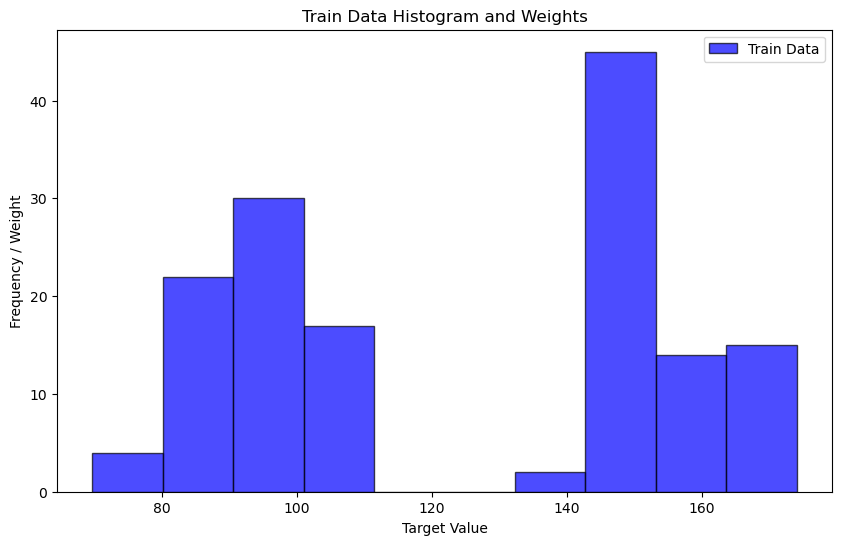

Fold Test R² Score: 0.5071195514980895
Fold Test R Score: [0.74124696]


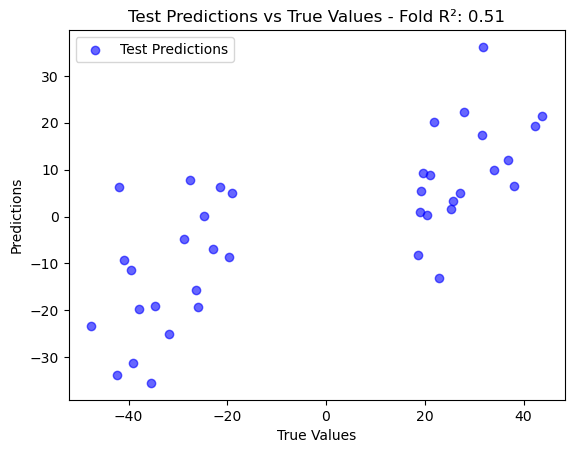

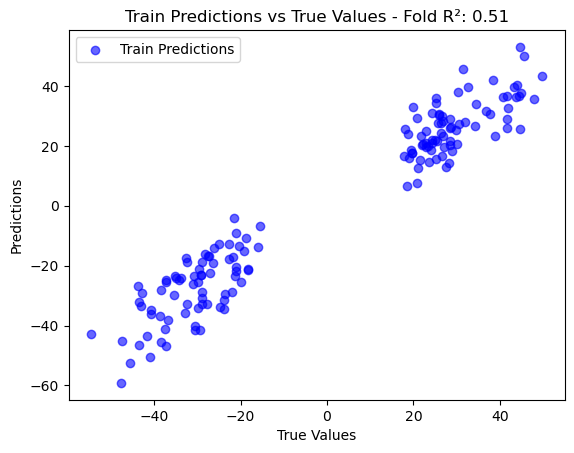

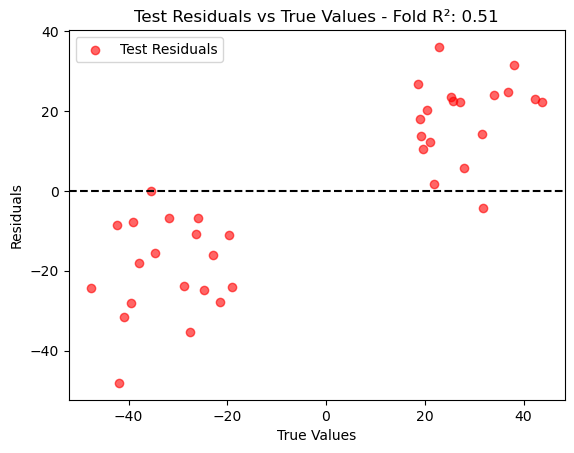

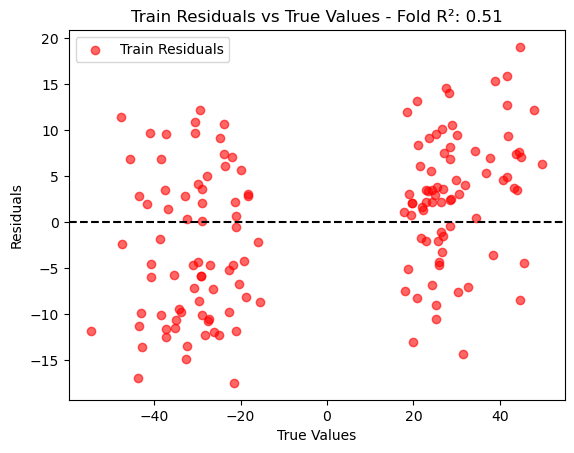

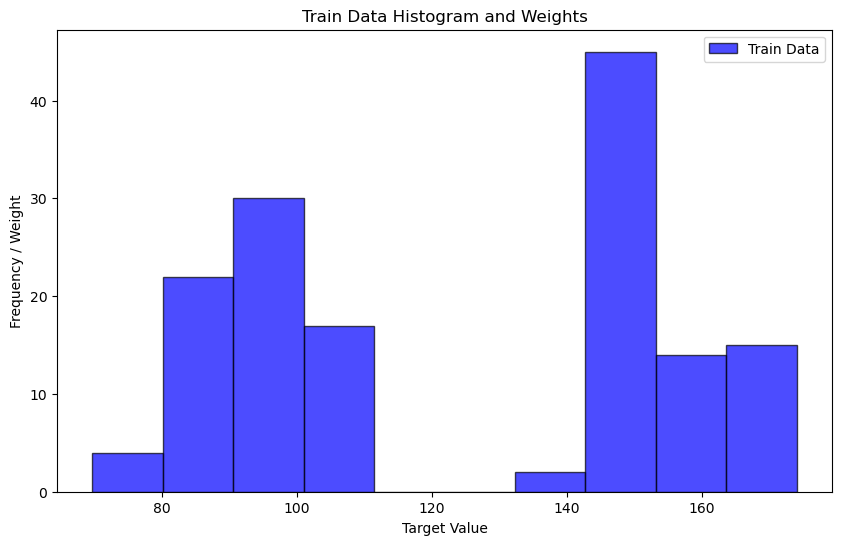

Fold Test R² Score: 0.3631236771504859
Fold Test R Score: [0.60431055]


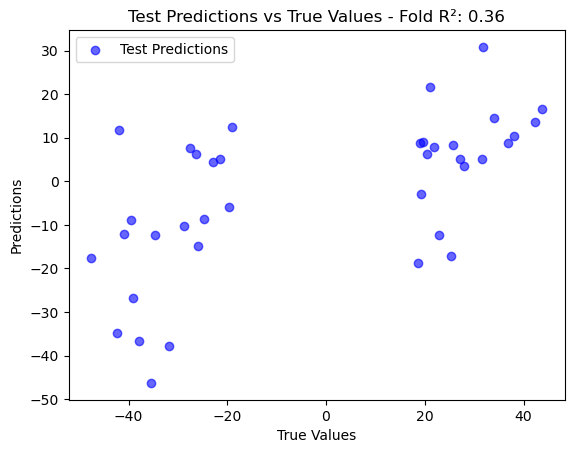

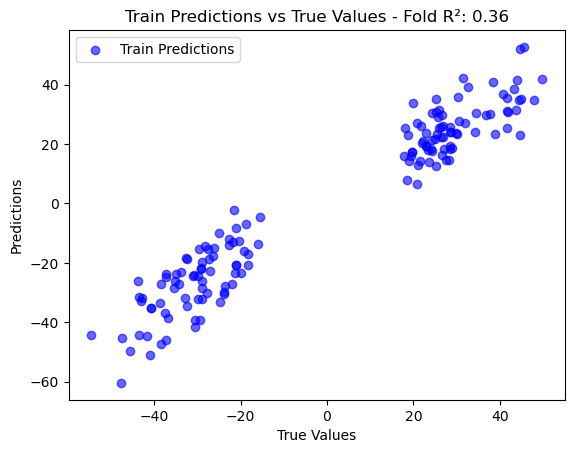

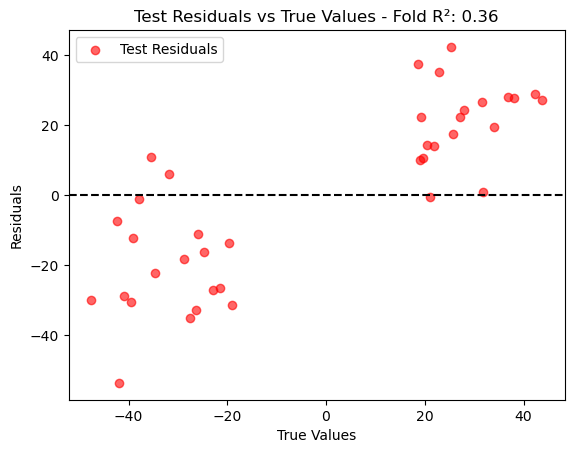

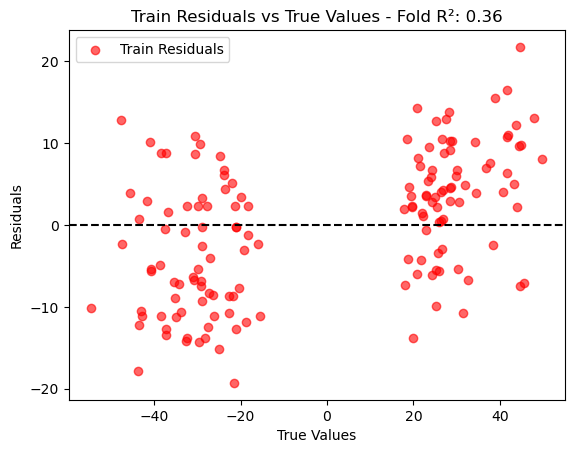

In [32]:
def tan_regression(train_netmats,test_netmats, train_values, test_values, train_age, test_age, metric=metric):
    
    # Plot the histogram of training data and calculated weights
    plt.figure(figsize=(10, 6))
    # Plot histogram of training target values
    plt.hist(train_values, bins=10, alpha=0.7, color='blue', edgecolor='black', label='Train Data')
    plt.title(f'Train Data Histogram and Weights')
    plt.xlabel('Target Value')
    plt.ylabel('Frequency / Weight')
    plt.legend()
    plt.show()
    
    train_values, test_values = preproc(train_values[:,np.newaxis],test_values[:,np.newaxis], method="center")
    train_age, test_age = preproc(train_age[:,np.newaxis], test_age[:,np.newaxis], method="center")


    train_mean = mean_covariance(train_netmats, metric=metric)
    tan_train = tangent_space(train_netmats, train_mean,metric=metric)
    tan_test = tangent_space(test_netmats, train_mean,metric=metric)

    tan_mean = np.mean(tan_train, axis=0)
    tan_train_centered = tan_train - tan_mean
    tan_test_centered = tan_test - tan_mean

    age_reg = regress_out_age(tan_train_centered, train_age)
    tan_train_centered = tan_train_centered - age_reg.predict(train_age.reshape(-1, 1))
    tan_test_centered = tan_test - age_reg.predict(test_age.reshape(-1, 1))

    reg_model = Ridge(alpha=1)
    # reg_model = LinearSVR(C=1,fit_intercept=True)

    reg_model.fit(tan_train_centered, train_values)
    
    # Evaluate the model on the test set
    test_score = reg_model.score(tan_test_centered, test_values)
    predictions = reg_model.predict(tan_test_centered)
    fold_corr, _ = pearsonr(test_values, predictions)

    print(f"Fold Test R² Score: {test_score}")
    print(f"Fold Test R Score: {fold_corr}")

    # Plot predictions vs true values for test fold
    plot_predictions(test_values, predictions,f'Test Predictions vs True Values - Fold R²: {test_score:.2f}', 'Test')
    # Now plot for train fold
    predictions_train = reg_model.predict(tan_train_centered)
    plot_predictions(train_values, predictions_train, f'Train Predictions vs True Values - Fold R²: {test_score:.2f}', 'Train')
     # Plot residuals vs true values for test fold
    plot_residuals(test_values, predictions, f'Test Residuals vs True Values - Fold R²: {test_score:.2f}', 'Test')

    # Plot residuals vs true values for train fold
    plot_residuals(train_values, predictions_train, f'Train Residuals vs True Values - Fold R²: {test_score:.2f}', 'Train')


tan_regression(group_netmats_1_train,group_netmats_1_test, train_values, test_values, train_age, test_age, metric=metric)
tan_regression(group_netmats_2_train,group_netmats_2_test, train_values, test_values, train_age, test_age, metric=metric)

### Analyze Discriminant Information via Netmats

In [ ]:
def migp_netmat(group_data,basis):
    group_data_dm = group_data - group_data.mean(axis=0, keepdims=True)
    basis_dm = basis - basis.mean(axis=0, keepdims=True)
    A = ((group_data_dm@np.linalg.pinv(basis_dm.T)))
    # Normalized Time x Components matrix
    An = hcp.normalize(A)  # An is Time x Components (T x C)
    del A

    timepoints = An.shape[0]
    group_netmat = (An.T@An)/(timepoints-1)
    return group_netmat

def group_dist(group_data1,group_data2,basis,metric="riemann"):
    netmat1 = migp_netmat(group_data1,basis)
    netmat2 = migp_netmat(group_data2,basis)
    return distance(netmat1,netmat2,metric=metric)

ICA_mean_dist = group_dist(reducedsubsA_loaded,reducedsubsB_loaded,z_scores_unthresh_major,metric=metric)
ICA_more_mean_dist = group_dist(reducedsubsA_loaded,reducedsubsB_loaded,z_scores_unthresh_major_more,metric=metric)
IFA_mean_dist = group_dist(reducedsubsA_loaded,reducedsubsB_loaded,z_scores_unthresh,metric=metric)

save_text_results(f'Distance between Group Average Netmats formed from MIGP on train data projected on {z_scores_unthresh_major.shape[1]} ICA components: {ICA_mean_dist}',os.path.join(f"fold_{fold}", "results","results.txt"))
save_text_results(f'Distance between Group Average Netmats formed from MIGP on train data projected on {z_scores_unthresh_major_more.shape[1]} ICA components: {ICA_more_mean_dist}',os.path.join(f"fold_{fold}", "results","results.txt"))
save_text_results(f'Distance between Group Average Netmats formed from MIGP on train data projected on {z_scores_unthresh.shape[1]} IFA components: {IFA_mean_dist}',os.path.join(f"fold_{fold}", "results","results.txt"))

In [ ]:

from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics.pairwise import euclidean_distances

# https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=5662067
def var_diff(group1_train, group1_test, group1_cov_train,group2_train, group2_test, group2_cov_train, metric):
    # clf = SVC(kernel='linear', class_weight='balanced')
    clf = LogisticRegression()

    
    # Compute the mean covariances using the training data only
    group1_mean = mean_covariance(group1_cov_train, metric=metric)
    group2_mean = mean_covariance(group2_cov_train, metric=metric)

    # # Eigen decomposition to get features
    _, feature_all = eigh(group1_mean, group2_mean + group2_mean, eigvals_only=False)
    # _, feature_all, _, _ = tangent_classifier(group1_cov_train, group2_cov_train, TSVM=True, TLDA=False, tangent_calc=True, metric=metric,visualize=False,n=0)


    # Initialize list to store results (accuracy and distance)
    results = []

    # Loop from n=1 to n=15 for selecting top and bottom eigenvectors
    for n in range(1, feature_all.shape[1] // 2 + 1): 
        # Perform eigen decomposition based on top and bottom n eigenvectors
        features = np.hstack([feature_all[:, :n], feature_all[:, -n:]])  # Select top and bottom n eigenvectors
        group1_train_logvar, group1_test_logvar, group2_train_logvar, group2_test_logvar = feature_generation(group1_train, group1_test,group2_train,group2_test, features, metric=metric,method="log-var")

        # Prepare the dataset for classification
        X_train = np.vstack([group1_train_logvar, group2_train_logvar])
        y_train = np.hstack([np.ones(group1_train_logvar.shape[0]), np.zeros(group2_train_logvar.shape[0])])
        X_test = np.vstack([group1_test_logvar, group2_test_logvar])
        y_test = np.hstack([np.ones(group1_test_logvar.shape[0]), np.zeros(group2_test_logvar.shape[0])])

        # Train logistic regression classifier on training data
        clf.fit(X_train, y_train)

        # Predict on the test data and calculate accuracy
        y_pred = clf.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)

        # Calculate class means for distance (using the training data)
        mean_group1_test = np.mean(group1_test_logvar, axis=0)
        mean_group2_test = np.mean(group2_test_logvar, axis=0)

        # Calculate the distance between the two class means
        mean_dist = np.linalg.norm(mean_group1_test - mean_group2_test)

        # Store accuracy and Riemannian distance for this n
        results.append((n, mean_dist, accuracy))
        # Plot when n=1
        if n == 1:
            
            plt.figure(figsize=(8, 6))
            plt.scatter(group1_test_logvar[:, 0], group1_test_logvar[:, 1], label='Group A Log Variance (Test)', color='blue')
            plt.scatter(group2_test_logvar[:, 0], group2_test_logvar[:, 1], label='Group B Log Variance (Test)', color='red')

            # Plot the line connecting the two means
            plt.plot([mean_group1_test[0], mean_group2_test[0]], [mean_group1_test[1], mean_group2_test[1]], 'k--', label=f'Mean Distance: {mean_dist:.2f}')

            # Decision boundary
            x_values = np.array([X_train[:, 0].min(), X_train[:, 0].max()])
            y_values = -(clf.intercept_ + clf.coef_[0][0] * x_values) / clf.coef_[0][1]
            plt.plot(x_values, y_values, 'g-', label='Decision Boundary')

            # Display plot
            plt.xlabel('Log Variance Feature B')
            plt.ylabel('Log Variance Feature A')
            plt.title('Log Variance FKT Feature Comparison and Logistic Regression Decision Boundary')

            # Display classification accuracy on the plot
            plt.text(0.05, 0.95, f'Accuracy: {accuracy:.2f}', transform=plt.gca().transAxes, fontsize=12,
                     verticalalignment='top', bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='lightgrey'))

            plt.legend()
            plt.grid(True)
            plt.show()
            # test_visualize_variance(group1_test, group2_test, features)

    # Return the list of accuracies and distances for each n
    return results

# Updated tangent_class_test function
def tangent_class_test(group1_cov_train, group1_cov_test, group2_cov_train, group2_cov_test, metric):
    # clf = SVC(kernel='linear', C=.01,class_weight='balanced')
    clf = LogisticRegression()
    tangent_projected_1_train, tangent_projected_2_train, tangent_projected_1_test, tangent_projected_2_test = tangent_transform(group1_cov_train, group1_cov_test, group2_cov_train, group2_cov_test, metric=metric)

    # Combine the tangent projections for training and testing
    X_train = np.vstack((tangent_projected_1_train, tangent_projected_2_train))
    X_test = np.vstack((tangent_projected_1_test, tangent_projected_2_test))
    y_train = np.hstack((np.ones(tangent_projected_1_train.shape[0]), np.zeros(tangent_projected_2_train.shape[0])))
    y_test = np.hstack((np.ones(tangent_projected_1_test.shape[0]), np.zeros(tangent_projected_2_test.shape[0])))

    # Dimensionality reduction
    max_dim = np.min((X_train.shape[0], X_train.shape[1]))
    dims = [2, 3, int((max_dim-1)/20), int((max_dim-1)/17), int((max_dim-1)/15),
            int((max_dim-1)/13), int((max_dim-1)/12), int((max_dim-1)/10), 
            int((max_dim-1)/7), int((max_dim-1)/5), int((max_dim-1)/3), 
            int((max_dim-1)/2), int((max_dim-1)/1.7), int((max_dim-1)/1.5), 
            int((max_dim-1)/1.3), int((max_dim-1)/1.1), max_dim-1]

    results = []
    for i in dims:
        # Reduce dimensionality using PCA
        pca = PCA(n_components=i)
        X_train_reduced = pca.fit_transform(X_train)
        X_test_reduced = pca.transform(X_test)
        mean_dist = np.linalg.norm(np.mean(X_test_reduced[y_test == 1],axis=0) - np.mean(X_test_reduced[y_test == 0],axis=0))
        # Train logistic regression classifier
        clf.fit(X_train_reduced, y_train)

        # Test accuracy
        y_pred = clf.predict(X_test_reduced)
        test_accuracy = accuracy_score(y_test, y_pred)
        results.append((i, mean_dist, test_accuracy))

    return results

def mean_diff(group1_covs_red,group2_covs_red,metric):
    group_1 = mean_covariance(group1_covs_red, metric=metric)
    group_2 = mean_covariance(group2_covs_red, metric=metric)
    return distance(group_1,group_2,metric=metric)

   
def PSD_diff_all(group1_train, group1_test, group1_cov_train, group1_cov_test, group2_train, group2_test, group2_cov_train, group2_cov_test, metric):
    psd_mean_distance = mean_diff(group1_cov_test, group2_cov_test, metric)
    tangent_results = tangent_class_test(group1_cov_train, group1_cov_test, group2_cov_train, group2_cov_test, metric)
    fkt_results = var_diff(group1_train, group1_test, group1_cov_train, group2_train, group2_test, group2_cov_train, metric)


    result = {
        "psd_mean_distance": psd_mean_distance,
        "tangent_results": tangent_results,
        "fkt_results": fkt_results
    }

    return result

In [ ]:
# For the first comparison (using Group 1 data):
IFA_result = PSD_diff_all(groupA_An_1_train, groupA_An_1_test, groupA_netmats_1_train, groupA_netmats_1_test, groupB_An_1_train, groupB_An_1_test, groupB_netmats_1_train, groupB_netmats_1_test, metric=metric)

# For the second comparison (using Group 2 data):
major_result = PSD_diff_all(groupA_An_2_train, groupA_An_2_test, groupA_netmats_2_train, groupA_netmats_2_test, groupB_An_2_train, groupB_An_2_test, groupB_netmats_2_train, groupB_netmats_2_test, metric=metric)

In [ ]:
def scatter_with_lines(x1, y1, x2, y2, label1='Series 1', label2='Series 2', xlabel='X', ylabel='Y', title='Scatter Plot with Connecting Lines'):
    """
    Creates a scatter plot with lines connecting corresponding points from two series.

    Parameters:
    - x1, y1: The x and y values for the first series.
    - x2, y2: The x and y values for the second series.
    - label1, label2: Labels for the two series.
    - xlabel, ylabel: Labels for the x and y axes.
    - title: Title for the plot.
    """
    plt.figure(figsize=(12,6))  # Set the size of the figure
    plt.scatter(x1, y1, label=label1, color='blue')
    plt.scatter(x2, y2, label=label2, color='orange')
    
    # Draw lines connecting corresponding points
    for x_1, y_1, x_2, y_2 in zip(x1, y1, x2, y2):
        plt.plot([x_1, x_2], [y_1, y_2], color='gray', linestyle='--')

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.show()

save_text_results(f'Distance between Group Average Netmats formed from Subject Dual Regression using test data and {z_scores_unthresh.shape[1]} IFA Components: {IFA_result["psd_mean_distance"]}',os.path.join(f"fold_{fold}", "results","results.txt"))
save_text_results(f'IFA Tangent Results: {IFA_result["tangent_results"]}',os.path.join(f"fold_{fold}", "results","results.txt"))
save_text_results(f'IFA FKT Results: {IFA_result["fkt_results"]}',os.path.join(f"fold_{fold}", "results","results.txt"))


save_text_results(f'Distance between Group Average Netmats formed from Subject Dual Regression using test data and {z_scores_unthresh_major_more.shape[1]} ICA Components: {major_result["psd_mean_distance"]}',os.path.join(f"fold_{fold}", "results","results.txt"))
save_text_results(f'ICA Tangent Results: {major_result["tangent_results"]}',os.path.join(f"fold_{fold}", "results","results.txt"))
save_text_results(f'ICA FKT Results: {major_result["fkt_results"]}',os.path.join(f"fold_{fold}", "results","results.txt"))

print(IFA_result["psd_mean_distance"], major_result["psd_mean_distance"])

scatter_with_lines([tup[0] for tup in IFA_result["tangent_results"]],
                   [tup[2] for tup in IFA_result["tangent_results"]],
                   [tup[0] for tup in major_result["tangent_results"]],
                   [tup[2] for tup in major_result["tangent_results"]],
                   label1='IFA Components', label2='ICA Components',
                   xlabel='Dimension', ylabel='Accuracy',
                   title='Logistic Regression Accuracy of Tangent Netmats')

scatter_with_lines([tup[0] for tup in IFA_result["tangent_results"]],
                   [tup[1] for tup in IFA_result["tangent_results"]],
                   [tup[0] for tup in major_result["tangent_results"]],
                   [tup[1] for tup in major_result["tangent_results"]],
                   label1='IFA Components', label2='ICA Components',
                   xlabel='Dimension', ylabel='Distance',
                   title='Distance Between Group Means of Tangent Netmats')

scatter_with_lines([tup[0]*2 for tup in IFA_result["fkt_results"]],
                   [tup[2] for tup in IFA_result["fkt_results"]],
                   [tup[0]*2 for tup in major_result["fkt_results"]],
                   [tup[2] for tup in major_result["fkt_results"]],
                   label1='IFA Components', label2='ICA Components',
                   xlabel='Dimension (# of Filters)', ylabel='Accuracy',
                   title='Logistic Regression Accuracy of LogVar FKT Features')

scatter_with_lines([tup[0]*2 for tup in IFA_result["fkt_results"]],
                   [tup[1] for tup in IFA_result["fkt_results"]],
                   [tup[0]*2 for tup in major_result["fkt_results"]],
                   [tup[1] for tup in major_result["fkt_results"]],
                   label1='IFA Components', label2='ICA Components',
                   xlabel='Dimension (# of Filters)', ylabel='Distance',
                   title='Distance Between Group Means of LogVar FKT Features')

In [ ]:
groupA_train_1_tangent, groupB_train_1_tangent, groupA_test_1_tangent, groupB_test_1_tangent = tangent_transform(groupA_netmats_1_train, groupA_netmats_1_test, groupB_netmats_1_train, groupB_netmats_1_test, metric=metric)
groupA_train_2_tangent, groupB_train_2_tangent, groupA_test_2_tangent, groupB_test_2_tangent = tangent_transform(groupA_netmats_2_train, groupA_netmats_2_test, groupB_netmats_2_train, groupB_netmats_2_test, metric=metric)

IFA_Class_Result = test_classifiers(groupA_train_1_tangent, groupA_test_1_tangent, groupB_train_1_tangent, groupB_test_1_tangent)
ICA_Class_Result = test_classifiers(groupA_train_2_tangent, groupA_test_2_tangent, groupB_train_2_tangent, groupB_test_2_tangent)
save_text_results(f'Tangent Space Classification Accuracies for Netmats formed from {z_scores_unthresh.shape[1]} IFA Components: {IFA_Class_Result}',os.path.join(f"fold_{fold}", "results","results.txt"))
save_text_results(f'Tangent Space Classification Accuracies for Netmats formed from {z_scores_unthresh_major_more.shape[1]} ICA Components: {ICA_Class_Result}',os.path.join(f"fold_{fold}", "results","results.txt"))



In [ ]:
def scatter_with_lines_dict(result1, result2, label1='Series 1', label2='Series 2', 
                            xlabel='Classifier', ylabel='Accuracy', title='Accuracy Comparison'):
    """
    Creates a scatter plot with lines connecting corresponding points from two dictionaries.

    Parameters:
    - result1: Dictionary containing classifiers and accuracies for the first series.
    - result2: Dictionary containing classifiers and accuracies for the second series.
    - label1, label2: Labels for the two series.
    - xlabel, ylabel: Labels for the x and y axes.
    - title: Title for the plot.
    """
    # Extract classifier names
    classifiers1 = list(result1.keys())
    classifiers2 = list(result2.keys())

    # Ensure both dictionaries have the same classifiers
    assert classifiers1 == classifiers2, "The classifiers (keys) must match between the two result dictionaries."

    # Extract accuracy values
    accuracies1 = [metrics['accuracy'] for metrics in result1.values()]
    accuracies2 = [metrics['accuracy'] for metrics in result2.values()]
    
    # Debug: Print extracted accuracies
    print("Accuracies for Series 1:", accuracies1)
    print("Accuracies for Series 2:", accuracies2)
    
    # Set the figure size
    plt.figure(figsize=(14, 8))
    
    # Number of classifiers
    num_classifiers = len(classifiers1)
    x_positions = range(num_classifiers)
    
    # Create scatter plots
    plt.scatter(x_positions, accuracies1, label=label1, color='blue', s=100)
    plt.scatter(x_positions, accuracies2, label=label2, color='orange', s=100)
    
    # Draw lines connecting corresponding points
    for i in range(num_classifiers):
        plt.plot([x_positions[i], x_positions[i]], [accuracies1[i], accuracies2[i]], 
                 color='gray', linestyle='--')
    
    # Set labels and title
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    plt.title(title, fontsize=16)
    
    # Set x-ticks to classifier names
    plt.xticks(x_positions, classifiers1, rotation=45, ha='right', fontsize=12)
    
    # Add legend
    plt.legend(fontsize=12)
    
    # Add grid for better readability
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Adjust layout to ensure everything fits
    plt.tight_layout()
    
    # Show the plot
    plt.show()

scatter_with_lines_dict(IFA_Class_Result, ICA_Class_Result, label1='IFA', label2='ICA', title='Accuracy Comparison Between Tangent Space Classification of Netmats formed via IFA and ICA')

In [ ]:
train_dist = []
test_dist = []
logistic_dims = []
logistic_dist = []
logistic_acc = []
fkt_dims = []
fkt_dist = []
fkt_acc = []
models_acc = []

train_dist_ICA = []
test_dist_ICA = []
logistic_dims_ICA = []
logistic_dist_ICA = []
logistic_acc_ICA = []
fkt_dims_ICA = []
fkt_dist_ICA = []
fkt_acc_ICA = []
models_acc_ICA = []


for i in range(0,5):
    fold = i
    fold_outputfolder = f"fold_{fold}"
    if not os.path.exists(os.path.join(outputfolder, f"fold_{fold}")):
        os.makedirs(os.path.join(outputfolder, f"fold_{fold}"))
    if not os.path.exists(os.path.join(outputfolder, f"fold_{fold}", "results")):
        os.makedirs(os.path.join(outputfolder, f"fold_{fold}", "results"))

    train_parcellated, test_parcellated = data[splits[fold][0]], data[splits[fold][1]]
    train_labels, test_labels = labels[splits[fold][0]], labels[splits[fold][1]]
    train_paths, test_paths = paths[splits[fold][0]], paths[splits[fold][1]]

    groupA_train_parcellated = train_parcellated[train_labels == 1]
    groupA_test_parcellated = test_parcellated[test_labels == 1]
    groupA_train_paths = train_paths[train_labels == 1]
    groupA_test_paths = test_paths[test_labels == 1]

    groupB_train_parcellated = train_parcellated[train_labels == 0]
    groupB_test_parcellated = test_parcellated[test_labels == 0]
    groupB_train_paths = train_paths[train_labels == 0]
    groupB_test_paths = test_paths[test_labels == 0]
    if "reducedsubsA" in locals():
        del reducedsubsA
    if "reducedsubsB" in locals():
        del reducedsubsB
    reducedsubsA_loaded = load_array_from_outputfolder(os.path.join(fold_outputfolder,'reducedsubsA.npy'))
    reducedsubsB_loaded = load_array_from_outputfolder(os.path.join(fold_outputfolder,'reducedsubsB.npy'))
    z_scores_unthresh = load_array_from_outputfolder(os.path.join(fold_outputfolder,"z_scores_unthresh.npy"))
    z_scores_thresh = load_array_from_outputfolder(os.path.join(fold_outputfolder,"z_scores_thresh.npy"))
    z_scores_unthresh_major = load_array_from_outputfolder(os.path.join(fold_outputfolder,"z_scores_unthresh_major.npy"))
    z_scores_thresh_major = load_array_from_outputfolder(os.path.join(fold_outputfolder,"z_scores_thresh_major.npy"))
    z_scores_unthresh_major_more = load_array_from_outputfolder(os.path.join(fold_outputfolder,"z_scores_unthresh_major_more.npy"))
    z_scores_thresh_major_more = load_array_from_outputfolder(os.path.join(fold_outputfolder,"z_scores_thresh_major_more.npy"))
    # Load function for An, netmats, and spatial maps
    def load_numpy_arrays(input_prefix):
        """
        Loads the An arrays, netmats, and spatial maps from disk using load_array_from_outputfolder.
        
        Parameters:
        input_prefix (str): Prefix for the input files.

        Returns:
        tuple: Six numpy arrays (An_1, netmats_1, spatial_maps_1, An_2, netmats_2, spatial_maps_2).
        """
        An_1 = load_array_from_outputfolder(f"{input_prefix}_An_1.npy")
        netmats_1 = load_array_from_outputfolder(f"{input_prefix}_netmats_1.npy")
        spatial_maps_1 = load_array_from_outputfolder(f"{input_prefix}_spatial_maps_1.npy")
        An_2 = load_array_from_outputfolder(f"{input_prefix}_An_2.npy")
        netmats_2 = load_array_from_outputfolder(f"{input_prefix}_netmats_2.npy")
        spatial_maps_2 = load_array_from_outputfolder(f"{input_prefix}_spatial_maps_2.npy")
        
        return An_1, netmats_1, spatial_maps_1, An_2, netmats_2, spatial_maps_2

    # Example usage for loading Group A train and test results
    groupA_An_1_train, groupA_netmats_1_train, groupA_spatial_maps_1_train, groupA_An_2_train, groupA_netmats_2_train, groupA_spatial_maps_2_train = load_numpy_arrays(os.path.join(fold_outputfolder,"groupA_train"))
    groupA_An_1_test, groupA_netmats_1_test, groupA_spatial_maps_1_test, groupA_An_2_test, groupA_netmats_2_test, groupA_spatial_maps_2_test = load_numpy_arrays(os.path.join(fold_outputfolder,"groupA_test"))

    # Example usage for loading Group B train and test results
    groupB_An_1_train, groupB_netmats_1_train, groupB_spatial_maps_1_train, groupB_An_2_train, groupB_netmats_2_train, groupB_spatial_maps_2_train = load_numpy_arrays(os.path.join(fold_outputfolder,"groupB_train"))
    groupB_An_1_test, groupB_netmats_1_test, groupB_spatial_maps_1_test, groupB_An_2_test, groupB_netmats_2_test, groupB_spatial_maps_2_test = load_numpy_arrays(os.path.join(fold_outputfolder,"groupB_test"))

    # Sanity check for Group A train data
    print("Group A Train:")
    print(groupA_An_1_train.shape, groupA_netmats_1_train.shape, groupA_spatial_maps_1_train.shape)
    print(groupA_An_2_train.shape, groupA_netmats_2_train.shape, groupA_spatial_maps_2_train.shape)

    # Sanity check for Group A test data
    print("Group A Test:")
    print(groupA_An_1_test.shape, groupA_netmats_1_test.shape, groupA_spatial_maps_1_test.shape)
    print(groupA_An_2_test.shape, groupA_netmats_2_test.shape, groupA_spatial_maps_2_test.shape)

    # Sanity check for Group B train data
    print("Group B Train:")
    print(groupB_An_1_train.shape, groupB_netmats_1_train.shape, groupB_spatial_maps_1_train.shape)
    print(groupB_An_2_train.shape, groupB_netmats_2_train.shape, groupB_spatial_maps_2_train.shape)

    # Sanity check for Group B test data
    print("Group B Test:")
    print(groupB_An_1_test.shape, groupB_netmats_1_test.shape, groupB_spatial_maps_1_test.shape)
    print(groupB_An_2_test.shape, groupB_netmats_2_test.shape, groupB_spatial_maps_2_test.shape)
    def migp_netmat(group_data,basis):
        group_data_dm = group_data - group_data.mean(axis=0, keepdims=True)
        basis_dm = basis - basis.mean(axis=0, keepdims=True)
        A = ((group_data_dm@np.linalg.pinv(basis_dm.T)))
        # Normalized Time x Components matrix
        An = hcp.normalize(A)  # An is Time x Components (T x C)
        del A

        timepoints = An.shape[0]
        group_netmat = (An.T@An)/(timepoints-1)
        return group_netmat

    def group_dist(group_data1,group_data2,basis,metric="riemann"):
        netmat1 = migp_netmat(group_data1,basis)
        netmat2 = migp_netmat(group_data2,basis)
        return distance(netmat1,netmat2,metric=metric)

    ICA_mean_dist = group_dist(reducedsubsA_loaded,reducedsubsB_loaded,z_scores_unthresh_major,metric=metric)
    ICA_more_mean_dist = group_dist(reducedsubsA_loaded,reducedsubsB_loaded,z_scores_unthresh_major_more,metric=metric)
    IFA_mean_dist = group_dist(reducedsubsA_loaded,reducedsubsB_loaded,z_scores_unthresh,metric=metric)

    train_dist.append(IFA_mean_dist)
    train_dist_ICA.append(ICA_more_mean_dist)

    save_text_results(f'Distance between Group Average Netmats formed from MIGP on train data projected on {z_scores_unthresh_major.shape[1]} ICA components: {ICA_mean_dist}',os.path.join(f"fold_{fold}", "results","results.txt"))
    save_text_results(f'Distance between Group Average Netmats formed from MIGP on train data projected on {z_scores_unthresh_major_more.shape[1]} ICA components: {ICA_more_mean_dist}',os.path.join(f"fold_{fold}", "results","results.txt"))
    save_text_results(f'Distance between Group Average Netmats formed from MIGP on train data projected on {z_scores_unthresh.shape[1]} IFA components: {IFA_mean_dist}',os.path.join(f"fold_{fold}", "results","results.txt"))
    from sklearn.metrics import accuracy_score, classification_report
    from sklearn.metrics.pairwise import euclidean_distances

    # https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=5662067
    def var_diff(group1_train, group1_test, group1_cov_train,group2_train, group2_test, group2_cov_train, metric):
        # clf = SVC(kernel='linear', class_weight='balanced')
        clf = LogisticRegression()

        
        # Compute the mean covariances using the training data only
        group1_mean = mean_covariance(group1_cov_train, metric=metric)
        group2_mean = mean_covariance(group2_cov_train, metric=metric)

        # # Eigen decomposition to get features
        _, feature_all = eigh(group1_mean, group2_mean + group2_mean, eigvals_only=False)
        # _, feature_all, _, _ = tangent_classifier(group1_cov_train, group2_cov_train, TSVM=True, TLDA=False, tangent_calc=True, metric=metric,visualize=False,n=0)


        # Initialize list to store results (accuracy and distance)
        results = []

        # Loop from n=1 to n=15 for selecting top and bottom eigenvectors
        for n in range(1, feature_all.shape[1] // 2 + 1): 
            # Perform eigen decomposition based on top and bottom n eigenvectors
            features = np.hstack([feature_all[:, :n], feature_all[:, -n:]])  # Select top and bottom n eigenvectors
            group1_train_logvar, group1_test_logvar, group2_train_logvar, group2_test_logvar = feature_generation(group1_train, group1_test,group2_train,group2_test, features, metric=metric,method="log-var")

            # Prepare the dataset for classification
            X_train = np.vstack([group1_train_logvar, group2_train_logvar])
            y_train = np.hstack([np.ones(group1_train_logvar.shape[0]), np.zeros(group2_train_logvar.shape[0])])
            X_test = np.vstack([group1_test_logvar, group2_test_logvar])
            y_test = np.hstack([np.ones(group1_test_logvar.shape[0]), np.zeros(group2_test_logvar.shape[0])])

            # Train logistic regression classifier on training data
            clf.fit(X_train, y_train)

            # Predict on the test data and calculate accuracy
            y_pred = clf.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)

            # Calculate class means for distance (using the training data)
            mean_group1_test = np.mean(group1_test_logvar, axis=0)
            mean_group2_test = np.mean(group2_test_logvar, axis=0)

            # Calculate the distance between the two class means
            mean_dist = np.linalg.norm(mean_group1_test - mean_group2_test)

            # Store accuracy and Riemannian distance for this n
            results.append((n, mean_dist, accuracy))
            # Plot when n=1
            if n == 1:
                
                plt.figure(figsize=(8, 6))
                plt.scatter(group1_test_logvar[:, 0], group1_test_logvar[:, 1], label='Group A Log Variance (Test)', color='blue')
                plt.scatter(group2_test_logvar[:, 0], group2_test_logvar[:, 1], label='Group B Log Variance (Test)', color='red')

                # Plot the line connecting the two means
                plt.plot([mean_group1_test[0], mean_group2_test[0]], [mean_group1_test[1], mean_group2_test[1]], 'k--', label=f'Mean Distance: {mean_dist:.2f}')

                # Decision boundary
                x_values = np.array([X_train[:, 0].min(), X_train[:, 0].max()])
                y_values = -(clf.intercept_ + clf.coef_[0][0] * x_values) / clf.coef_[0][1]
                plt.plot(x_values, y_values, 'g-', label='Decision Boundary')

                # Display plot
                plt.xlabel('Log Variance Feature B')
                plt.ylabel('Log Variance Feature A')
                plt.title('Log Variance FKT Feature Comparison and Logistic Regression Decision Boundary')

                # Display classification accuracy on the top-left of the plot
                plt.text(0.05, 0.95, f'Accuracy: {accuracy:.2f}', transform=plt.gca().transAxes, fontsize=12,
                        verticalalignment='top', bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='lightgrey'))

                # Set legend in the top-right corner
                plt.legend(loc='upper right')

                # Add grid
                plt.grid(True)

                # Show the plot
                plt.show()

                # test_visualize_variance(group1_test, group2_test, features)

        # Return the list of accuracies and distances for each n
        return results

    # Updated tangent_class_test function
    def tangent_class_test(group1_cov_train, group1_cov_test, group2_cov_train, group2_cov_test, metric):
        # clf = SVC(kernel='linear', C=.01,class_weight='balanced')
        clf = LogisticRegression()
        tangent_projected_1_train, tangent_projected_2_train, tangent_projected_1_test, tangent_projected_2_test = tangent_transform(group1_cov_train, group1_cov_test, group2_cov_train, group2_cov_test, metric=metric)

        # Combine the tangent projections for training and testing
        X_train = np.vstack((tangent_projected_1_train, tangent_projected_2_train))
        X_test = np.vstack((tangent_projected_1_test, tangent_projected_2_test))
        y_train = np.hstack((np.ones(tangent_projected_1_train.shape[0]), np.zeros(tangent_projected_2_train.shape[0])))
        y_test = np.hstack((np.ones(tangent_projected_1_test.shape[0]), np.zeros(tangent_projected_2_test.shape[0])))

        # Dimensionality reduction
        max_dim = np.min((X_train.shape[0], X_train.shape[1]))
        dims = [2, 3, int((max_dim-1)/20), int((max_dim-1)/17), int((max_dim-1)/15),
                int((max_dim-1)/13), int((max_dim-1)/12), int((max_dim-1)/10), 
                int((max_dim-1)/7), int((max_dim-1)/5), int((max_dim-1)/3), 
                int((max_dim-1)/2), int((max_dim-1)/1.7), int((max_dim-1)/1.5), 
                int((max_dim-1)/1.3), int((max_dim-1)/1.1), max_dim-1]

        results = []
        for i in dims:
            # Reduce dimensionality using PCA
            pca = PCA(n_components=i)
            X_train_reduced = pca.fit_transform(X_train)
            X_test_reduced = pca.transform(X_test)
            mean_dist = np.linalg.norm(np.mean(X_test_reduced[y_test == 1],axis=0) - np.mean(X_test_reduced[y_test == 0],axis=0))
            # Train logistic regression classifier
            clf.fit(X_train_reduced, y_train)

            # Test accuracy
            y_pred = clf.predict(X_test_reduced)
            test_accuracy = accuracy_score(y_test, y_pred)
            results.append((i, mean_dist, test_accuracy))

        return results

    def mean_diff(group1_covs_red,group2_covs_red,metric):
        group_1 = mean_covariance(group1_covs_red, metric=metric)
        group_2 = mean_covariance(group2_covs_red, metric=metric)
        return distance(group_1,group_2,metric=metric)

    
    def PSD_diff_all(group1_train, group1_test, group1_cov_train, group1_cov_test, group2_train, group2_test, group2_cov_train, group2_cov_test, metric):
        psd_mean_distance = mean_diff(group1_cov_test, group2_cov_test, metric)
        tangent_results = tangent_class_test(group1_cov_train, group1_cov_test, group2_cov_train, group2_cov_test, metric)
        fkt_results = var_diff(group1_train, group1_test, group1_cov_train, group2_train, group2_test, group2_cov_train, metric)


        result = {
            "psd_mean_distance": psd_mean_distance,
            "tangent_results": tangent_results,
            "fkt_results": fkt_results
        }

        return result
    # For the first comparison (using Group 1 data):
    IFA_result = PSD_diff_all(groupA_An_1_train, groupA_An_1_test, groupA_netmats_1_train, groupA_netmats_1_test, groupB_An_1_train, groupB_An_1_test, groupB_netmats_1_train, groupB_netmats_1_test, metric=metric)

    # For the second comparison (using Group 2 data):
    major_result = PSD_diff_all(groupA_An_2_train, groupA_An_2_test, groupA_netmats_2_train, groupA_netmats_2_test, groupB_An_2_train, groupB_An_2_test, groupB_netmats_2_train, groupB_netmats_2_test, metric=metric)
    def scatter_with_lines(x1, y1, x2, y2, label1='Series 1', label2='Series 2', xlabel='X', ylabel='Y', title='Scatter Plot with Connecting Lines'):
        """
        Creates a scatter plot with lines connecting corresponding points from two series.

        Parameters:
        - x1, y1: The x and y values for the first series.
        - x2, y2: The x and y values for the second series.
        - label1, label2: Labels for the two series.
        - xlabel, ylabel: Labels for the x and y axes.
        - title: Title for the plot.
        """
        plt.figure(figsize=(12,6))  # Set the size of the figure
        plt.scatter(x1, y1, label=label1, color='blue')
        plt.scatter(x2, y2, label=label2, color='orange')
        
        # Draw lines connecting corresponding points
        for x_1, y_1, x_2, y_2 in zip(x1, y1, x2, y2):
            plt.plot([x_1, x_2], [y_1, y_2], color='gray', linestyle='--')

        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.title(title)
        plt.legend()
        plt.show()

    save_text_results(f'Distance between Group Average Netmats formed from Subject Dual Regression using test data and {z_scores_unthresh.shape[1]} IFA Components: {IFA_result["psd_mean_distance"]}',os.path.join(f"fold_{fold}", "results","results.txt"))
    save_text_results(f'IFA Tangent Results: {IFA_result["tangent_results"]}',os.path.join(f"fold_{fold}", "results","results.txt"))
    save_text_results(f'IFA FKT Results: {IFA_result["fkt_results"]}',os.path.join(f"fold_{fold}", "results","results.txt"))


    save_text_results(f'Distance between Group Average Netmats formed from Subject Dual Regression using test data and {z_scores_unthresh_major_more.shape[1]} ICA Components: {major_result["psd_mean_distance"]}',os.path.join(f"fold_{fold}", "results","results.txt"))
    save_text_results(f'ICA Tangent Results: {major_result["tangent_results"]}',os.path.join(f"fold_{fold}", "results","results.txt"))
    save_text_results(f'ICA FKT Results: {major_result["fkt_results"]}',os.path.join(f"fold_{fold}", "results","results.txt"))

    print(IFA_result["psd_mean_distance"], major_result["psd_mean_distance"])
    test_dist.append(IFA_result["psd_mean_distance"])
    test_dist_ICA.append(major_result["psd_mean_distance"])

    logistic_dims.append([tup[0] for tup in IFA_result["tangent_results"]])
    logistic_acc.append([tup[2] for tup in IFA_result["tangent_results"]])
    logistic_dist.append([tup[1] for tup in IFA_result["tangent_results"]])
    fkt_dims.append([tup[0]*2 for tup in IFA_result["fkt_results"]])
    fkt_acc.append([tup[2] for tup in IFA_result["fkt_results"]])
    fkt_dist.append([tup[1] for tup in IFA_result["fkt_results"]])

    logistic_dims_ICA.append([tup[0] for tup in major_result["tangent_results"]])
    logistic_acc_ICA.append([tup[2] for tup in major_result["tangent_results"]])
    logistic_dist_ICA.append([tup[1] for tup in major_result["tangent_results"]])
    fkt_dims_ICA.append([tup[0]*2 for tup in major_result["fkt_results"]])
    fkt_acc_ICA.append([tup[2] for tup in major_result["fkt_results"]])
    fkt_dist_ICA.append([tup[1] for tup in major_result["fkt_results"]])

    scatter_with_lines([tup[0] for tup in IFA_result["tangent_results"]],
                    [tup[2] for tup in IFA_result["tangent_results"]],
                    [tup[0] for tup in major_result["tangent_results"]],
                    [tup[2] for tup in major_result["tangent_results"]],
                    label1='IFA Components', label2='ICA Components',
                    xlabel='Dimension', ylabel='Accuracy',
                    title='Logistic Regression Accuracy of Tangent Netmats')

    scatter_with_lines([tup[0] for tup in IFA_result["tangent_results"]],
                    [tup[1] for tup in IFA_result["tangent_results"]],
                    [tup[0] for tup in major_result["tangent_results"]],
                    [tup[1] for tup in major_result["tangent_results"]],
                    label1='IFA Components', label2='ICA Components',
                    xlabel='Dimension', ylabel='Distance',
                    title='Distance Between Group Means of Tangent Netmats')

    scatter_with_lines([tup[0]*2 for tup in IFA_result["fkt_results"]],
                    [tup[2] for tup in IFA_result["fkt_results"]],
                    [tup[0]*2 for tup in major_result["fkt_results"]],
                    [tup[2] for tup in major_result["fkt_results"]],
                    label1='IFA Components', label2='ICA Components',
                    xlabel='Dimension (# of Filters)', ylabel='Accuracy',
                    title='Logistic Regression Accuracy of LogVar FKT Features')

    scatter_with_lines([tup[0]*2 for tup in IFA_result["fkt_results"]],
                    [tup[1] for tup in IFA_result["fkt_results"]],
                    [tup[0]*2 for tup in major_result["fkt_results"]],
                    [tup[1] for tup in major_result["fkt_results"]],
                    label1='IFA Components', label2='ICA Components',
                    xlabel='Dimension (# of Filters)', ylabel='Distance',
                    title='Distance Between Group Means of LogVar FKT Features')
    groupA_train_1_tangent, groupB_train_1_tangent, groupA_test_1_tangent, groupB_test_1_tangent = tangent_transform(groupA_netmats_1_train, groupA_netmats_1_test, groupB_netmats_1_train, groupB_netmats_1_test, metric=metric)
    groupA_train_2_tangent, groupB_train_2_tangent, groupA_test_2_tangent, groupB_test_2_tangent = tangent_transform(groupA_netmats_2_train, groupA_netmats_2_test, groupB_netmats_2_train, groupB_netmats_2_test, metric=metric)

    IFA_Class_Result = test_classifiers(groupA_train_1_tangent, groupA_test_1_tangent, groupB_train_1_tangent, groupB_test_1_tangent)
    ICA_Class_Result = test_classifiers(groupA_train_2_tangent, groupA_test_2_tangent, groupB_train_2_tangent, groupB_test_2_tangent)
    
    models_acc.append(IFA_Class_Result)
    models_acc_ICA.append(ICA_Class_Result)

    save_text_results(f'Tangent Space Classification Accuracies for Netmats formed from {z_scores_unthresh.shape[1]} IFA Components: {IFA_Class_Result}',os.path.join(f"fold_{fold}", "results","results.txt"))
    save_text_results(f'Tangent Space Classification Accuracies for Netmats formed from {z_scores_unthresh_major_more.shape[1]} ICA Components: {ICA_Class_Result}',os.path.join(f"fold_{fold}", "results","results.txt"))

os.mkdir(os.path.join(outputfolder,'results'))
# save_array_to_outputfolder(os.path.join('results','train_dist_FKT.npy'), train_dist)
# save_array_to_outputfolder(os.path.join('results','test_dist_FKT.npy'), test_dist)
# save_array_to_outputfolder(os.path.join('results','logistic_dims_FKT.npy'), logistic_dims)
# save_array_to_outputfolder(os.path.join('results','logistic_dist_FKT.npy'), logistic_dist)
# save_array_to_outputfolder(os.path.join('results','logistic_acc_FKT.npy'), logistic_acc)
# save_array_to_outputfolder(os.path.join('results','fkt_dims_FKT.npy'), fkt_dims)
# save_array_to_outputfolder(os.path.join('results','fkt_dist_FKT.npy'), fkt_dist)
# save_array_to_outputfolder(os.path.join('results','fkt_acc_FKT.npy'), fkt_acc)
# save_array_to_outputfolder(os.path.join('results','models_acc_FKT.npy'), models_acc)

save_array_to_outputfolder(os.path.join('results','train_dist_TSSF.npy'), train_dist)
save_array_to_outputfolder(os.path.join('results','test_dist_TSSF.npy'), test_dist)
save_array_to_outputfolder(os.path.join('results','logistic_dims_TSSF.npy'), logistic_dims)
save_array_to_outputfolder(os.path.join('results','logistic_dist_TSSF.npy'), logistic_dist)
save_array_to_outputfolder(os.path.join('results','logistic_acc_TSSF.npy'), logistic_acc)
save_array_to_outputfolder(os.path.join('results','fkt_dims_TSSF.npy'), fkt_dims)
save_array_to_outputfolder(os.path.join('results','fkt_dist_TSSF.npy'), fkt_dist)
save_array_to_outputfolder(os.path.join('results','fkt_acc_TSSF.npy'), fkt_acc)
save_array_to_outputfolder(os.path.join('results','models_acc_TSSF.npy'), models_acc)

save_array_to_outputfolder(os.path.join('results','train_dist_ICA.npy'), train_dist_ICA)
save_array_to_outputfolder(os.path.join('results','test_dist_ICA.npy'), test_dist_ICA)
save_array_to_outputfolder(os.path.join('results','logistic_dims_ICA.npy'), logistic_dims_ICA)
save_array_to_outputfolder(os.path.join('results','logistic_dist_ICA.npy'), logistic_dist_ICA)
save_array_to_outputfolder(os.path.join('results','logistic_acc_ICA.npy'), logistic_acc_ICA)
save_array_to_outputfolder(os.path.join('results','fkt_dims_ICA.npy'), fkt_dims_ICA)
save_array_to_outputfolder(os.path.join('results','fkt_dist_ICA.npy'), fkt_dist_ICA)
save_array_to_outputfolder(os.path.join('results','fkt_acc_ICA.npy'), fkt_acc_ICA)
save_array_to_outputfolder(os.path.join('results','models_acc_ICA.npy'), models_acc_ICA)

In [ ]:
os.mkdir(os.path.join(outputfolder,'results'))
save_array_to_outputfolder(os.path.join('results','train_dist_FKT.npy'), train_dist)
save_array_to_outputfolder(os.path.join('results','test_dist_FKT.npy'), test_dist)
save_array_to_outputfolder(os.path.join('results','logistic_dims_FKT.npy'), logistic_dims)
save_array_to_outputfolder(os.path.join('results','logistic_dist_FKT.npy'), logistic_dist)
save_array_to_outputfolder(os.path.join('results','logistic_acc_FKT.npy'), logistic_acc)
save_array_to_outputfolder(os.path.join('results','fkt_dims_FKT.npy'), fkt_dims)
save_array_to_outputfolder(os.path.join('results','fkt_dist_FKT.npy'), fkt_dist)
save_array_to_outputfolder(os.path.join('results','fkt_acc_FKT.npy'), fkt_acc)
save_array_to_outputfolder(os.path.join('results','models_acc_FKT.npy'), models_acc)

In [ ]:
os.mkdir(os.path.join(outputfolder,'results'))
# save_array_to_outputfolder(os.path.join('results','train_dist_FKT.npy'), train_dist)
# save_array_to_outputfolder(os.path.join('results','test_dist_FKT.npy'), test_dist)
# save_array_to_outputfolder(os.path.join('results','logistic_dims_FKT.npy'), logistic_dims)
# save_array_to_outputfolder(os.path.join('results','logistic_dist_FKT.npy'), logistic_dist)
# save_array_to_outputfolder(os.path.join('results','logistic_acc_FKT.npy'), logistic_acc)
# save_array_to_outputfolder(os.path.join('results','fkt_dims_FKT.npy'), fkt_dims)
# save_array_to_outputfolder(os.path.join('results','fkt_dist_FKT.npy'), fkt_dist)
# save_array_to_outputfolder(os.path.join('results','fkt_acc_FKT.npy'), fkt_acc)
# save_array_to_outputfolder(os.path.join('results','models_acc_FKT.npy'), models_acc)

save_array_to_outputfolder(os.path.join('results','train_dist_TSSF.npy'), train_dist)
save_array_to_outputfolder(os.path.join('results','test_dist_TSSF.npy'), test_dist)
save_array_to_outputfolder(os.path.join('results','logistic_dims_TSSF.npy'), logistic_dims)
save_array_to_outputfolder(os.path.join('results','logistic_dist_TSSF.npy'), logistic_dist)
save_array_to_outputfolder(os.path.join('results','logistic_acc_TSSF.npy'), logistic_acc)
save_array_to_outputfolder(os.path.join('results','fkt_dims_TSSF.npy'), fkt_dims)
save_array_to_outputfolder(os.path.join('results','fkt_dist_TSSF.npy'), fkt_dist)
save_array_to_outputfolder(os.path.join('results','fkt_acc_TSSF.npy'), fkt_acc)
save_array_to_outputfolder(os.path.join('results','models_acc_TSSF.npy'), models_acc)

save_array_to_outputfolder(os.path.join('results','train_dist_ICA.npy'), train_dist_ICA)
save_array_to_outputfolder(os.path.join('results','test_dist_ICA.npy'), test_dist_ICA)
save_array_to_outputfolder(os.path.join('results','logistic_dims_ICA.npy'), logistic_dims_ICA)
save_array_to_outputfolder(os.path.join('results','logistic_dist_ICA.npy'), logistic_dist_ICA)
save_array_to_outputfolder(os.path.join('results','logistic_acc_ICA.npy'), logistic_acc_ICA)
save_array_to_outputfolder(os.path.join('results','fkt_dims_ICA.npy'), fkt_dims_ICA)
save_array_to_outputfolder(os.path.join('results','fkt_dist_ICA.npy'), fkt_dist_ICA)
save_array_to_outputfolder(os.path.join('results','fkt_acc_ICA.npy'), fkt_acc_ICA)
save_array_to_outputfolder(os.path.join('results','models_acc_ICA.npy'), models_acc_ICA)

In [ ]:
# TSSF related files
test_dist_TSSF = np.load(os.path.join('Gender_TangentSVMC1_logeuclid','results','test_dist_TSSF.npy'))
logistic_dims_TSSF = np.load(os.path.join('Gender_TangentSVMC1_logeuclid','results','logistic_dims_TSSF.npy'))
logistic_dist_TSSF = np.load(os.path.join('Gender_TangentSVMC1_logeuclid','results','logistic_dist_TSSF.npy'))
logistic_acc_TSSF = np.load(os.path.join('Gender_TangentSVMC1_logeuclid','results','logistic_acc_TSSF.npy'))
fkt_dims_TSSF = np.load(os.path.join('Gender_TangentSVMC1_logeuclid','results','fkt_dims_TSSF.npy'))
fkt_dist_TSSF = np.load(os.path.join('Gender_TangentSVMC1_logeuclid','results','fkt_dist_TSSF.npy'))
fkt_acc_TSSF = np.load(os.path.join('Gender_TangentSVMC1_logeuclid','results','fkt_acc_TSSF.npy'))

# Loading models_acc_TSSF with allow_pickle=True
models_acc_TSSF = np.load(os.path.join('Gender_TangentSVMC1_logeuclid','results','models_acc_TSSF.npy'), allow_pickle=True)

# ICA related files
train_dist_ICA = np.load(os.path.join('Gender_TangentSVMC1_logeuclid','results','train_dist_ICA.npy'))
test_dist_ICA = np.load(os.path.join('Gender_TangentSVMC1_logeuclid','results','test_dist_ICA.npy'))
logistic_dims_ICA = np.load(os.path.join('Gender_TangentSVMC1_logeuclid','results','logistic_dims_ICA.npy'))
logistic_dist_ICA = np.load(os.path.join('Gender_TangentSVMC1_logeuclid','results','logistic_dist_ICA.npy'))
logistic_acc_ICA = np.load(os.path.join('Gender_TangentSVMC1_logeuclid','results','logistic_acc_ICA.npy'))
fkt_dims_ICA = np.load(os.path.join('Gender_TangentSVMC1_logeuclid','results','fkt_dims_ICA.npy'))
fkt_dist_ICA = np.load(os.path.join('Gender_TangentSVMC1_logeuclid','results','fkt_dist_ICA.npy'))
fkt_acc_ICA = np.load(os.path.join('Gender_TangentSVMC1_logeuclid','results','fkt_acc_ICA.npy'))

models_acc_ICA = np.load(os.path.join('Gender_TangentSVMC1_logeuclid','results','models_acc_ICA.npy'), allow_pickle=True)

# FKT related files
train_dist_FKT = np.load(os.path.join('Gender_FKT2_logeuclid','results','train_dist_FKT.npy'))
test_dist_FKT = np.load(os.path.join('Gender_FKT2_logeuclid','results','test_dist_FKT.npy'))
logistic_dims_FKT = np.load(os.path.join('Gender_FKT2_logeuclid','results','logistic_dims_FKT.npy'))
logistic_dist_FKT = np.load(os.path.join('Gender_FKT2_logeuclid','results','logistic_dist_FKT.npy'))
logistic_acc_FKT = np.load(os.path.join('Gender_FKT2_logeuclid','results','logistic_acc_FKT.npy'))
fkt_dims_FKT = np.load(os.path.join('Gender_FKT2_logeuclid','results','fkt_dims_FKT.npy'))
fkt_dist_FKT = np.load(os.path.join('Gender_FKT2_logeuclid','results','fkt_dist_FKT.npy'))
fkt_acc_FKT = np.load(os.path.join('Gender_FKT2_logeuclid','results','fkt_acc_FKT.npy'))

models_acc_FKT = np.load(os.path.join('Gender_FKT2_logeuclid','results','models_acc_FKT.npy'), allow_pickle=True)


In [ ]:
# Function to compute mean and std across folds
def compute_mean_std_across_folds(data):
    n_folds = data.shape[0]                    # Number of folds (axis 0 gives the number of rows/folds)
    mean_across_folds = np.mean(data, axis=0)  # Mean across folds (axis 0)
    std_across_folds = np.std(data, axis=0)    # Std deviation across folds (axis 0)
    sem_across_folds = std_across_folds / np.sqrt(n_folds)  # Compute SEM
    print(n_folds)
    return mean_across_folds, sem_across_folds

# Modified function to plot means and std dev for a measure across TSSF, ICA, and FKT
def plot_comparison(dims, mean_TSSF, std_TSSF, mean_ICA, std_ICA, mean_FKT, std_FKT, measure_name, ax):
    # Use seaborn color palette
    palette = sns.color_palette("Set1", 3)
    
    # Map dims to positions on x-axis
    spacing_factor = 2  # Adjust this factor to control spacing between bins
    x_positions = np.arange(len(dims)) * spacing_factor
    
    # Width for offsets (should be less than half of spacing_factor)
    width = spacing_factor / 5  # Adjust as needed
    
    # Offsets for each method
    offsets = [-width, 0, width]
    
    # Adjust x-values for each method
    x_TSSF = x_positions + offsets[0]
    x_ICA = x_positions + offsets[1]
    x_FKT = x_positions + offsets[2]
    
    # Plotting TSSF, ICA, and FKT with adjusted x-values
    ax.errorbar(x_TSSF, mean_TSSF, yerr=std_TSSF, fmt='o', label='TSSF IFA', color=palette[0], capsize=0)
    ax.errorbar(x_FKT, mean_FKT, yerr=std_FKT, fmt='o', label='FKT IFA', color=palette[2], capsize=0)
    ax.errorbar(x_ICA, mean_ICA, yerr=std_ICA, fmt='o', label='ICA', color=palette[1], capsize=0)
    
    # Set x-ticks to x_positions without offsets, labels to dims
    ax.set_xticks(x_positions)
    ax.set_xticklabels(dims)
    
    # Formatting plot
    ax.set_xlabel('Dimensions')
    ax.set_ylabel(f'{measure_name} (Mean ± SEM)')
    ax.set_title(f'Comparison of {measure_name} Across Methods')
    ax.legend()
    ax.grid(True)

# Function to plot measures for a single fold without binning the x-axis
def plot_single_fold(dims, measure_TSSF, measure_ICA, measure_FKT, measure_name, fold_index, ax):
    # Use seaborn color palette
    palette = sns.color_palette("Set1", 3)
    
    # Plotting TSSF, ICA, and FKT
    ax.plot(dims, measure_TSSF, 'o', label='TSSF IFA', color=palette[0])
    ax.plot(dims, measure_FKT, 'o', label='FKT IFA', color=palette[2])
    ax.plot(dims, measure_ICA, 'o', label='ICA', color=palette[1])    
    # Formatting plot
    ax.set_xlabel('Dimensions')
    ax.set_ylabel(f'{measure_name}')
    ax.set_title(f'{measure_name} (Fold {fold_index})')
    ax.legend()
    ax.grid(True)

# Function to plot both averaged data and specific fold data in subplots
def plot_measure_with_fold_and_average(dims, mean_TSSF, std_TSSF, mean_ICA, std_ICA, mean_FKT, std_FKT,
                                       fold_TSSF, fold_ICA, fold_FKT, measure_name, fold_index):
    fig, axs = plt.subplots(1, 2, figsize=(18, 6))
    
    # Left subplot: Averaged data with categorical bins
    plot_comparison(dims, mean_TSSF, std_TSSF, mean_ICA, std_ICA, mean_FKT, std_FKT, measure_name, axs[0])
    
    # Right subplot: Specific fold data without adjusted x-positions
    plot_single_fold(dims, fold_TSSF, fold_ICA, fold_FKT, measure_name, fold_index, axs[1])
    
    plt.tight_layout()
    plt.show()

# Loading the data for each method (TSSF, ICA, and FKT)
# Replace the paths with your actual data paths
# TSSF related files
# Loading the data for each method (TSSF, ICA, and FKT)
# TSSF related files
logistic_acc_TSSF = np.load(os.path.join('PicVocab_AgeAdj_PMAT24_A_CR_TangentSVM_3_logeuclid','results','logistic_acc_TSSF.npy'))
logistic_dist_TSSF = np.load(os.path.join('PicVocab_AgeAdj_PMAT24_A_CR_TangentSVM_3_logeuclid','results','logistic_dist_TSSF.npy'))
fkt_acc_TSSF = np.load(os.path.join('PicVocab_AgeAdj_PMAT24_A_CR_TangentSVM_3_logeuclid','results','fkt_acc_TSSF.npy'))
fkt_dist_TSSF = np.load(os.path.join('PicVocab_AgeAdj_PMAT24_A_CR_TangentSVM_3_logeuclid','results','fkt_dist_TSSF.npy'))

logistic_dims_TSSF = np.load(os.path.join('PicVocab_AgeAdj_PMAT24_A_CR_TangentSVM_3_logeuclid','results','logistic_dims_TSSF.npy'))

# ICA related files
logistic_acc_ICA = np.load(os.path.join('PicVocab_AgeAdj_PMAT24_A_CR_TangentSVM_2_logeuclid','results','logistic_acc_TSSF.npy'))
logistic_dist_ICA = np.load(os.path.join('PicVocab_AgeAdj_PMAT24_A_CR_TangentSVM_2_logeuclid','results','logistic_dist_TSSF.npy'))
fkt_acc_ICA = np.load(os.path.join('PicVocab_AgeAdj_PMAT24_A_CR_TangentSVM_2_logeuclid','results','fkt_acc_TSSF.npy'))
fkt_dist_ICA = np.load(os.path.join('PicVocab_AgeAdj_PMAT24_A_CR_TangentSVM_2_logeuclid','results','fkt_dist_TSSF.npy'))

logistic_dims_ICA = np.load(os.path.join('PicVocab_AgeAdj_PMAT24_A_CR_TangentSVM_2_logeuclid','results','logistic_dims_TSSF.npy'))

# FKT related files
logistic_acc_FKT = np.load(os.path.join('PicVocab_AgeAdj_PMAT24_A_CR_TangentSVM_logeuclid','results','logistic_acc_TSSF.npy'))
logistic_dist_FKT = np.load(os.path.join('PicVocab_AgeAdj_PMAT24_A_CR_TangentSVM_logeuclid','results','logistic_dist_TSSF.npy'))
fkt_acc_FKT = np.load(os.path.join('PicVocab_AgeAdj_PMAT24_A_CR_TangentSVM_logeuclid','results','fkt_acc_TSSF.npy'))
fkt_dist_FKT = np.load(os.path.join('PicVocab_AgeAdj_PMAT24_A_CR_TangentSVM_logeuclid','results','fkt_dist_TSSF.npy'))

fkt_dims_FKT = np.load(os.path.join('PicVocab_AgeAdj_PMAT24_A_CR_TangentSVM_logeuclid','results','fkt_dims_TSSF.npy'))

# Since logistic_dims and fkt_dims are the same across all methods, we'll just use one of them
dims_logistic = logistic_dims_TSSF[0]
dims_fkt = fkt_dims_FKT[0]

# Compute means and std for all metrics
# Logistic accuracy
mean_logistic_acc_TSSF, std_logistic_acc_TSSF = compute_mean_std_across_folds(logistic_acc_TSSF)
mean_logistic_acc_ICA, std_logistic_acc_ICA = compute_mean_std_across_folds(logistic_acc_ICA)
mean_logistic_acc_FKT, std_logistic_acc_FKT = compute_mean_std_across_folds(logistic_acc_FKT)

# Logistic distance
mean_logistic_dist_TSSF, std_logistic_dist_TSSF = compute_mean_std_across_folds(logistic_dist_TSSF)
mean_logistic_dist_ICA, std_logistic_dist_ICA = compute_mean_std_across_folds(logistic_dist_ICA)
mean_logistic_dist_FKT, std_logistic_dist_FKT = compute_mean_std_across_folds(logistic_dist_FKT)

# FKT accuracy
mean_fkt_acc_TSSF, std_fkt_acc_TSSF = compute_mean_std_across_folds(fkt_acc_TSSF)
mean_fkt_acc_ICA, std_fkt_acc_ICA = compute_mean_std_across_folds(fkt_acc_ICA)
mean_fkt_acc_FKT, std_fkt_acc_FKT = compute_mean_std_across_folds(fkt_acc_FKT)

# FKT distance
mean_fkt_dist_TSSF, std_fkt_dist_TSSF = compute_mean_std_across_folds(fkt_dist_TSSF)
mean_fkt_dist_ICA, std_fkt_dist_ICA = compute_mean_std_across_folds(fkt_dist_ICA)
mean_fkt_dist_FKT, std_fkt_dist_FKT = compute_mean_std_across_folds(fkt_dist_FKT)

# Select the fold you want to plot (e.g., fold 0)
fold_index = 0  # Change this index to select a different fold

# Extract data for the selected fold
# Logistic accuracy
logistic_acc_TSSF_fold = logistic_acc_TSSF[fold_index, :]
logistic_acc_ICA_fold = logistic_acc_ICA[fold_index, :]
logistic_acc_FKT_fold = logistic_acc_FKT[fold_index, :]

# Logistic distance
logistic_dist_TSSF_fold = logistic_dist_TSSF[fold_index, :]
logistic_dist_ICA_fold = logistic_dist_ICA[fold_index, :]
logistic_dist_FKT_fold = logistic_dist_FKT[fold_index, :]

# # FKT accuracy
# fkt_acc_TSSF_fold = fkt_acc_TSSF[fold_index, :]
# fkt_acc_ICA_fold = fkt_acc_ICA[fold_index, :]
# fkt_acc_FKT_fold = fkt_acc_FKT[fold_index, :]

# # FKT distance
# fkt_dist_TSSF_fold = fkt_dist_TSSF[fold_index, :]
# fkt_dist_ICA_fold = fkt_dist_ICA[fold_index, :]
# fkt_dist_FKT_fold = fkt_dist_FKT[fold_index, :]

# Plotting comparisons for each measure
# Logistic accuracy comparison
plot_measure_with_fold_and_average(dims_logistic,
                                   mean_logistic_acc_TSSF, std_logistic_acc_TSSF,
                                   mean_logistic_acc_ICA, std_logistic_acc_ICA,
                                   mean_logistic_acc_FKT, std_logistic_acc_FKT,
                                   logistic_acc_TSSF_fold, logistic_acc_ICA_fold, logistic_acc_FKT_fold,
                                   'Logistic Regression TS_AIRM Accuracy', fold_index)

# Logistic distance comparison
plot_measure_with_fold_and_average(dims_logistic,
                                   mean_logistic_dist_TSSF, std_logistic_dist_TSSF,
                                   mean_logistic_dist_ICA, std_logistic_dist_ICA,
                                   mean_logistic_dist_FKT, std_logistic_dist_FKT,
                                   logistic_dist_TSSF_fold, logistic_dist_ICA_fold, logistic_dist_FKT_fold,
                                   'Logistic Regression TS_AIRM Distance', fold_index)

# # FKT accuracy comparison
# plot_measure_with_fold_and_average(dims_fkt,
#                                    mean_fkt_acc_TSSF, std_fkt_acc_TSSF,
#                                    mean_fkt_acc_ICA, std_fkt_acc_ICA,
#                                    mean_fkt_acc_FKT, std_fkt_acc_FKT,
#                                    fkt_acc_TSSF_fold, fkt_acc_ICA_fold, fkt_acc_FKT_fold,
#                                    'TSSF_Var_1_Step Accuracy', fold_index)

# # FKT distance comparison
# plot_measure_with_fold_and_average(dims_fkt,
#                                    mean_fkt_dist_TSSF, std_fkt_dist_TSSF,
#                                    mean_fkt_dist_ICA, std_fkt_dist_ICA,
#                                    mean_fkt_dist_FKT, std_fkt_dist_FKT,
#                                    fkt_dist_TSSF_fold, fkt_dist_ICA_fold, fkt_dist_FKT_fold,
#                                    'TSSF_Var_1_Step Distance', fold_index)

In [ ]:
# Function to compute mean and std across folds for model accuracies
def compute_mean_std_model_acc(models_acc_list):
    """
    models_acc_list: List of dictionaries, one for each fold.
    Returns:
        models: List of model names.
        mean_acc: List of mean accuracies for each model across folds.
        std_acc: List of std deviations for each model across folds.
    """
    # Get all model names from the first fold
    models = list(models_acc_list[0].keys())
    
    # Initialize dictionaries to hold accuracies
    acc_dict = {model: [] for model in models}
    
    # Collect accuracies from each fold
    for fold_data in models_acc_list:
        for model in models:
            acc = fold_data[model]['accuracy']
            acc_dict[model].append(acc)
    
    # Compute mean and std for each model
    mean_acc = []
    sem_acc = []
    n_folds = models_acc_list.shape[0]                    # Number of folds (axis 0 gives the number of rows/folds)
    print(n_folds)
    for model in models:
        accs = acc_dict[model]
        mean_acc.append(np.mean(accs))
        sem_acc.append(np.std(accs)/np.sqrt(n_folds))
    
    return models, mean_acc, sem_acc

# Modified function to plot means and std dev for model accuracies across TSSF, ICA, and FKT
def plot_model_comparison(models, mean_TSSF, std_TSSF, mean_ICA, std_ICA, mean_FKT, std_FKT, measure_name, ax):
    # Use seaborn color palette
    palette = sns.color_palette("Set1", 3)
    
    # Increase the spacing between bins
    spacing_factor = 10  # Increased spacing factor from 2 to 3
    x_positions = np.arange(len(models)) * spacing_factor
    
    # Width for offsets (should be less than half of spacing_factor)
    width = spacing_factor / 5
    
    # Offsets for each method
    offsets = [-width, 0, width]
    
    # Adjust x-values for each method
    x_TSSF = x_positions + offsets[0]
    x_ICA = x_positions + offsets[1]
    x_FKT = x_positions + offsets[2]
    
    # Plotting TSSF, ICA, and FKT with adjusted x-values
    ax.errorbar(x_TSSF, mean_TSSF, yerr=std_TSSF, fmt='o', label='TSSF IFA 3', color=palette[0], capsize=0)
    ax.errorbar(x_ICA, mean_ICA, yerr=std_ICA, fmt='o', label='TSSF IFA 2', color=palette[1], capsize=0)
    ax.errorbar(x_FKT, mean_FKT, yerr=std_FKT, fmt='o', label='TSSF IFA 1', color=palette[2], capsize=0)
    
    # Set x-ticks to x_positions without offsets, labels to models
    ax.set_xticks(x_positions)
    ax.set_xticklabels(models, rotation=45, ha='right')
    
    # Formatting plot
    ax.set_xlabel('Models')
    ax.set_ylabel(f'{measure_name} (Mean ± SEM)')
    ax.set_title(f'Comparison of {measure_name} Across Methods')
    ax.legend()
    ax.grid(True)

# Modified function to plot measures for a single fold with categorical bins
def plot_single_fold_models(models, acc_TSSF, acc_ICA, acc_FKT, measure_name, fold_index, ax):
    # Use seaborn color palette
    palette = sns.color_palette("Set1", 3)
    
    # Increase the spacing between bins (same as in the averaged plot)
    spacing_factor = 10  # Increased spacing factor from 2 to 3
    x_positions = np.arange(len(models)) * spacing_factor
    
    # Width for offsets (should be less than half of spacing_factor)
    width = spacing_factor / 10
    
    # Offsets for each method
    offsets = [-width, 0, width]
    
    # Adjust x-values for each method
    x_TSSF = x_positions + offsets[0]
    x_ICA = x_positions + offsets[1]
    x_FKT = x_positions + offsets[2]
    
    # Plotting TSSF, ICA, and FKT with adjusted x-values
    # Changed markers to squares ('s')
    ax.plot(x_TSSF, acc_TSSF, 's', label='TSSF IFA 3', color=palette[0])
    ax.plot(x_ICA, acc_ICA, 's', label='TSSF IFA 2', color=palette[1])
    ax.plot(x_FKT, acc_FKT, 's', label='TSSF IFA 1', color=palette[2])
    
    # Set x-ticks to x_positions without offsets, labels to models
    ax.set_xticks(x_positions)
    ax.set_xticklabels(models, rotation=45, ha='right')
    
    # Formatting plot
    ax.set_xlabel('Models')
    ax.set_ylabel(f'{measure_name}')
    ax.set_title(f'{measure_name} (Fold {fold_index})')
    ax.legend()
    ax.grid(True)

# Function to plot both averaged data and specific fold data in subplots
def plot_model_measure_with_fold_and_average(models, mean_TSSF, std_TSSF, mean_ICA, std_ICA, mean_FKT, std_FKT,
                                             fold_TSSF, fold_ICA, fold_FKT, measure_name, fold_index):
    fig, axs = plt.subplots(1, 1, figsize=(20, 6))
    
    # Left subplot: Averaged data with categorical bins
    plot_model_comparison(models, mean_TSSF, std_TSSF, mean_ICA, std_ICA, mean_FKT, std_FKT, measure_name, axs)
    
    # Right subplot: Specific fold data with categorical bins and square markers
    # plot_single_fold_models(models, fold_TSSF, fold_ICA, fold_FKT, measure_name, fold_index, axs[1])
    
    plt.tight_layout()
    plt.show()

# Loading the data for each method (TSSF, ICA, and FKT)
models_acc_TSSF_3 = np.load(os.path.join('PicVocab_AgeAdj_PMAT24_A_CR_TangentSVM_3_logeuclid', 'results', 'models_acc_TSSF.npy'), allow_pickle=True)
models_acc_TSSF_2 = np.load(os.path.join('PicVocab_AgeAdj_PMAT24_A_CR_TangentSVM_2_logeuclid', 'results', 'models_acc_TSSF.npy'), allow_pickle=True)
models_acc_TSSF_1 = np.load(os.path.join('PicVocab_AgeAdj_PMAT24_A_CR_TangentSVM_logeuclid', 'results', 'models_acc_TSSF.npy'), allow_pickle=True)

# Since models are the same across methods, we'll extract them from one
models = list(models_acc_TSSF_1[0].keys())
print(models)

# Compute means and std for model accuracies
# TSSF
models_TSSF_3, mean_acc_TSSF_3, std_acc_TSSF_3 = compute_mean_std_model_acc(models_acc_TSSF_3)
# ICA
models_TSSF_2, mean_acc_TSSF_2, std_acc_TSSF_2 = compute_mean_std_model_acc(models_acc_TSSF_2)
# FKT
models_TSSF_1, mean_acc_TSSF_1, std_acc_TSSF_1 = compute_mean_std_model_acc(models_acc_TSSF_1)

# Ensure the models are in the same order
assert models_TSSF_1 == models_TSSF_2 == models_TSSF_3 == models, "Models are not the same across methods"

# Select the fold you want to plot (e.g., fold 0)
fold_index = 0  # Change this index to select a different fold

# # Extract data for the selected fold
# # TSSF
# fold_acc_TSSF_3 = [models_TSSF_3[fold_index][model]['accuracy'] for model in models]
# # ICA
# fold_acc_TSSF_2 = [models_TSSF_2[fold_index][model]['accuracy'] for model in models]
# # FKT
# fold_acc_TSSF_1 = [models_TSSF_1[fold_index][model]['accuracy'] for model in models]

# Plotting comparisons for model accuracies
plot_model_measure_with_fold_and_average(models,
                                         mean_acc_TSSF_3, std_acc_TSSF_3,
                                         mean_acc_TSSF_2, std_acc_TSSF_2,
                                         mean_acc_TSSF_1, std_acc_TSSF_1,
                                         None, None, None,
                                         'Model Accuracy', fold_index)


In [ ]:
# Function to compute mean and std across folds for model accuracies
def compute_mean_std_model_acc(models_acc_list):
    """
    models_acc_list: List of dictionaries, one for each fold.
    Returns:
        models: List of model names.
        mean_acc: List of mean accuracies for each model across folds.
        std_acc: List of std deviations for each model across folds.
    """
    # Get all model names from the first fold
    models = list(models_acc_list[0].keys())
    
    # Initialize dictionaries to hold accuracies
    acc_dict = {model: [] for model in models}
    
    # Collect accuracies from each fold
    for fold_data in models_acc_list:
        for model in models:
            acc = fold_data[model]['accuracy']
            acc_dict[model].append(acc)
    
    # Compute mean and std for each model
    mean_acc = []
    sem_acc = []
    n_folds = models_acc_list.shape[0]                    # Number of folds (axis 0 gives the number of rows/folds)
    print(n_folds)
    for model in models:
        accs = acc_dict[model]
        mean_acc.append(np.mean(accs))
        sem_acc.append(np.std(accs)/np.sqrt(n_folds))
    
    return models, mean_acc, sem_acc

# Modified function to plot means and std dev for model accuracies across TSSF, ICA, and FKT
def plot_model_comparison(models, mean_TSSF, std_TSSF, mean_ICA, std_ICA, mean_FKT, std_FKT, measure_name, ax):
    # Use seaborn color palette
    palette = sns.color_palette("Set1", 3)
    
    # Increase the spacing between bins
    spacing_factor = 10  # Increased spacing factor from 2 to 3
    x_positions = np.arange(len(models)) * spacing_factor
    
    # Width for offsets (should be less than half of spacing_factor)
    width = spacing_factor / 5
    
    # Offsets for each method
    offsets = [-width, 0, width]
    
    # Adjust x-values for each method
    x_TSSF = x_positions + offsets[0]
    x_ICA = x_positions + offsets[1]
    x_FKT = x_positions + offsets[2]
    
    # Plotting TSSF, ICA, and FKT with adjusted x-values
    ax.errorbar(x_TSSF, mean_TSSF, yerr=std_TSSF, fmt='o', label='TSSF IFA', color=palette[0], capsize=0)
    ax.errorbar(x_ICA, mean_ICA, yerr=std_ICA, fmt='o', label='ICA', color=palette[1], capsize=0)
    ax.errorbar(x_FKT, mean_FKT, yerr=std_FKT, fmt='o', label='FKT IFA', color=palette[2], capsize=0)
    
    # Set x-ticks to x_positions without offsets, labels to models
    ax.set_xticks(x_positions)
    ax.set_xticklabels(models, rotation=45, ha='right')
    
    # Formatting plot
    ax.set_xlabel('Models')
    ax.set_ylabel(f'{measure_name} (Mean ± SEM)')
    ax.set_title(f'Comparison of {measure_name} Across Methods')
    ax.legend()
    ax.grid(True)

# Modified function to plot measures for a single fold with categorical bins
def plot_single_fold_models(models, acc_TSSF, acc_ICA, acc_FKT, measure_name, fold_index, ax):
    # Use seaborn color palette
    palette = sns.color_palette("Set1", 3)
    
    # Increase the spacing between bins (same as in the averaged plot)
    spacing_factor = 10  # Increased spacing factor from 2 to 3
    x_positions = np.arange(len(models)) * spacing_factor
    
    # Width for offsets (should be less than half of spacing_factor)
    width = spacing_factor / 10
    
    # Offsets for each method
    offsets = [-width, 0, width]
    
    # Adjust x-values for each method
    x_TSSF = x_positions + offsets[0]
    x_ICA = x_positions + offsets[1]
    x_FKT = x_positions + offsets[2]
    
    # Plotting TSSF, ICA, and FKT with adjusted x-values
    # Changed markers to squares ('s')
    ax.plot(x_TSSF, acc_TSSF, 's', label='TSSF IFA', color=palette[0])
    ax.plot(x_ICA, acc_ICA, 's', label='ICA', color=palette[1])
    ax.plot(x_FKT, acc_FKT, 's', label='FKT IFA', color=palette[2])
    
    # Set x-ticks to x_positions without offsets, labels to models
    ax.set_xticks(x_positions)
    ax.set_xticklabels(models, rotation=45, ha='right')
    
    # Formatting plot
    ax.set_xlabel('Models')
    ax.set_ylabel(f'{measure_name}')
    ax.set_title(f'{measure_name} (Fold {fold_index})')
    ax.legend()
    ax.grid(True)

# Function to plot both averaged data and specific fold data in subplots
def plot_model_measure_with_fold_and_average(models, mean_TSSF, std_TSSF, mean_ICA, std_ICA, mean_FKT, std_FKT,
                                             fold_TSSF, fold_ICA, fold_FKT, measure_name, fold_index):
    fig, axs = plt.subplots(1, 2, figsize=(20, 6))
    
    # Left subplot: Averaged data with categorical bins
    plot_model_comparison(models, mean_TSSF, std_TSSF, mean_ICA, std_ICA, mean_FKT, std_FKT, measure_name, axs[0])
    
    # Right subplot: Specific fold data with categorical bins and square markers
    plot_single_fold_models(models, fold_TSSF, fold_ICA, fold_FKT, measure_name, fold_index, axs[1])
    
    plt.tight_layout()
    plt.show()

# Loading the data for each method (TSSF, ICA, and FKT)
models_acc_TSSF = np.load(os.path.join('PicVocab_AgeAdj_PMAT24_A_CR_TangentSVM_3_logeuclid', 'results', 'models_acc_TSSF.npy'), allow_pickle=True)
models_acc_FKT = np.load(os.path.join('PicVocab_AgeAdj_PMAT24_A_CR_TangentSVM_2_logeuclid', 'results', 'models_acc_TSSF.npy'), allow_pickle=True)
models_acc_ICA = np.load(os.path.join('PicVocab_AgeAdj_PMAT24_A_CR_TangentSVM_logeuclid', 'results', 'models_acc_TSSF.npy'), allow_pickle=True)

# Since models are the same across methods, we'll extract them from one
models = list(models_acc_TSSF[0].keys())

# Compute means and std for model accuracies
# TSSF
models_TSSF, mean_acc_TSSF, std_acc_TSSF = compute_mean_std_model_acc(models_acc_TSSF)
# ICA
models_ICA, mean_acc_ICA, std_acc_ICA = compute_mean_std_model_acc(models_acc_ICA)
# FKT
models_FKT, mean_acc_FKT, std_acc_FKT = compute_mean_std_model_acc(models_acc_FKT)

# Ensure the models are in the same order
assert models_TSSF == models_ICA == models_FKT == models, "Models are not the same across methods"

# Select the fold you want to plot (e.g., fold 0)
fold_index = 0  # Change this index to select a different fold

# Extract data for the selected fold
# TSSF
fold_acc_TSSF = [models_acc_TSSF[fold_index][model]['accuracy'] for model in models]
# ICA
fold_acc_ICA = [models_acc_ICA[fold_index][model]['accuracy'] for model in models]
# FKT
fold_acc_FKT = [models_acc_FKT[fold_index][model]['accuracy'] for model in models]

# Plotting comparisons for model accuracies
plot_model_measure_with_fold_and_average(models,
                                         mean_acc_TSSF, std_acc_TSSF,
                                         mean_acc_ICA, std_acc_ICA,
                                         mean_acc_FKT, std_acc_FKT,
                                         fold_acc_TSSF, fold_acc_ICA, fold_acc_FKT,
                                         'Model Accuracy', fold_index)


### Z Scores on Dual Regressed

In [ ]:
from scipy.stats import ttest_ind
from joblib import Parallel, delayed

# Assuming group1 and group2 are numpy arrays with shapes:
# group1.shape = (subjects1, components, grayordinates)
# group2.shape = (subjects2, components, grayordinates)

# Define the number of permutations
n_permutations = 10  # Adjust based on computational resources

# Function to perform t-test for a specific component
def perm_ttest_for_component(component_idx, data_group1, data_group2, n_permutations):
    # Extract data for this component from both groups
    group1_comp_data = data_group1[:, component_idx, :]  # Shape: (subjects1, grayordinates)
    group2_comp_datxa = data_group2[:, component_idx, :]  # Shape: (subjects2, grayordinates)

    # Perform the permutation t-test for each grayordinate
    t_stat, p_val = ttest_ind(
        group1_comp_data, group2_comp_data, axis=0, equal_var=True, nan_policy='omit',
        permutations=n_permutations, random_state=None, alternative='two-sided'
    )
    return t_stat, p_val

# Use Parallel to parallelize over components
results = Parallel(n_jobs=-1)(
    delayed(perm_ttest_for_component)(component_idx, groupA_spatial_maps_1_train, groupB_spatial_maps_1_train, n_permutations)
    for component_idx in range(groupA_spatial_maps_1_train.shape[1])
)

# Unpack results
t_statistics, p_values = zip(*results)
t_statistics = np.array(t_statistics)  # Shape: (components, grayordinates)
p_values = np.array(p_values)          # Shape: (components, grayordinates)

# # Flatten p-values for multiple comparison correction
# p_values_flat = p_values.flatten()

# # Apply FDR correction
# _, p_values_corrected, _, _ = multipletests(p_values_flat, method='fdr_bh')

# # Reshape the corrected p-values back to the original (components, grayordinates) shape
# p_values_corrected = p_values_corrected.reshape(p_values.shape)


In [ ]:
p_values_flat = p_values.flatten()
reject,p_values_corrected,_,_  = multipletests(p_values_flat, method='fdr_bh')
p_values_corrected = p_values_corrected.reshape(p_values.shape)
reject = reject.reshape(p_values.shape)


In [ ]:
# plotting.view_surf(hcp.mesh.inflated, hcp.cortex_data(p_values_corrected[20,:]), threshold=0, bg_map=hcp.mesh.sulc)

In [ ]:
# plotting.view_surf(hcp.mesh.inflated, hcp.cortex_data(groupA_spatial_maps_1_train[10,20,:]), threshold=np.percentile(np.abs(groupA_spatial_maps_1_train[10,20,:]), 95), bg_map=hcp.mesh.sulc)

In [ ]:
# plotting.view_surf(hcp.mesh.inflated, hcp.cortex_data(groupA_spatial_maps_1_train[20,20,:]), threshold=np.percentile(np.abs(groupA_spatial_maps_1_train[20,20,:]), 95), bg_map=hcp.mesh.sulc)

In [ ]:
# plotting.view_surf(hcp.mesh.inflated, hcp.cortex_data(groupB_spatial_maps_1_train[11,20,:]), threshold=np.percentile(np.abs(groupB_spatial_maps_1_train[11,20,:]), 95), bg_map=hcp.mesh.sulc)

In [ ]:
# plotting.view_surf(hcp.mesh.inflated, hcp.cortex_data(groupB_spatial_maps_1_train[1,20,:]), threshold=np.percentile(np.abs(groupB_spatial_maps_1_train[1,20,:]), 95), bg_map=hcp.mesh.sulc)

In [ ]:
# plotting.view_surf(hcp.mesh.inflated, hcp.cortex_data(z_scores_unthresh[:,20]), threshold=np.percentile(np.abs(z_scores_unthresh[:,20]), 95), bg_map=hcp.mesh.sulc)